- Ctrl+Enter to run a cell
- Shift+Enter to run a cell and go to the next cell
- **Download this Notebook file [here](http://pmx.mpibpc.mpg.de/Tutorial2025/Istanbul_2025/ligand_tutorial.ipynb)**

----------
# Introduction
__________

In this tutorial we will use pmx and Gromacs to set up alchemical free energy calculations for a relative free energy calculation study. We will further perform the simulations and estimate the actual ddG value.

The protein and ligand topologies for this case have already been generated and described in the study:<br>
*Gapsys, Perez-Benito et al. Large scale relative protein ligand binding affinities using non-equilibrium alchemy.  2020. Chemical Science<br>
https://pubs.rsc.org/en/content/articlelanding/2020/SC/C9SC03754C* <br>
All the input/output files from this work can be found on the pmx github page:<br>
*https://github.com/deGrootLab/pmx/tree/master/protLig_benchmark*

In the tutorial, we will use a pair of ligands (18625-1: Cl in ortho position and 18626-1: Cl in meta position) binding to the JNK1 kinase and estimate the relative free energy difference $\Delta\Delta G$ between these molecules. The experimentally measured double free energy difference for this edge is **-3.22 kJ/mol**.<br>

For the calculations, we will construct the following thermodynamic cycle:

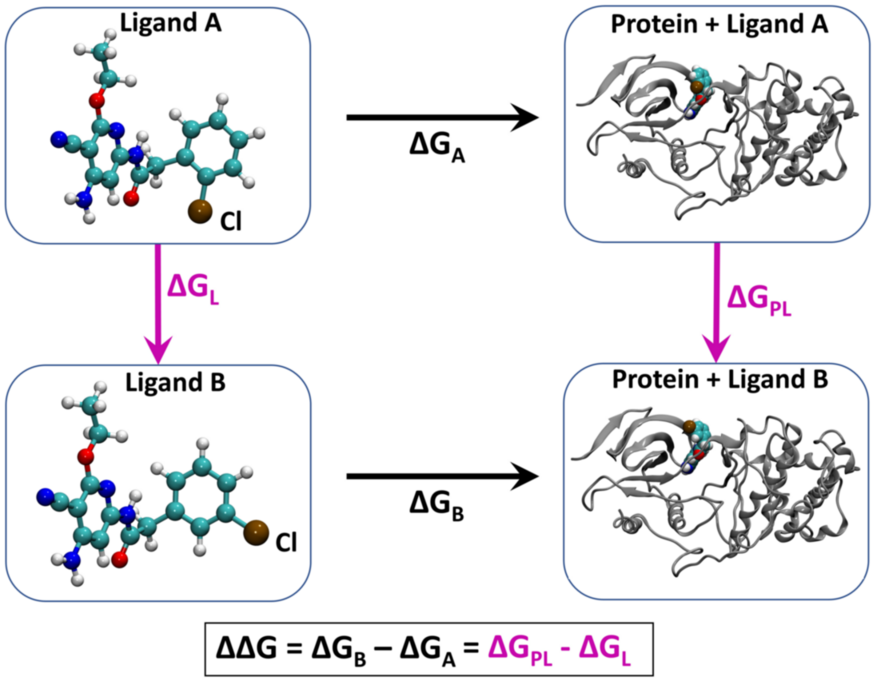

# Prerequisite

- Knowledge of basic linux commands and python.
- An already installed GROMACS and a basic understanding of GROMACS simulation set up is required. You can follow [this tutorial](https://tutorials.gromacs.org/docs/md-intro-tutorial.html) for the same.
- **PMX installation. The steps are as follows:** <br>
-------------------
        conda create -n PMX python=3.7
        conda activate PMX
        conda install numpy matplotlib scipy pip jupyterlab pandas rdkit
        git clone https://github.com/deGrootLab/pmx
        cd pmx
        git checkout develop
        pip install .
-------------------
- **Input Files:** The [tutorial_files.zip](http://pmx.mpibpc.mpg.de/Tutorial2025/Istanbul_2025/tutorial_files.zip) contains all the files required to run this tutorial. **input**: mdp and topology files; **workpath_precalculated**: some pre-simulated files; **AZtutorial.py**: a script file containing various functions for smooth implementation of the tutorial.

------------------
# Method
------------------
We will set up the calculations in a non-equilibrium framework.<br>
Firstly, two 6 ns long equilibrium simulations will be performed in the physical states A and B. This will be done for the ligand solvated in water and protein-ligand complex.<br>
Afterwards, we will extract snapshots from the equilibrium simulations and run 80 rapid (50 ps each) transitions in the directions A->B and A<-B.<br>
During the transitions, we will record the work required for the ligand morphing. Finally, the work will be related to $\Delta G$ by applying Crooks fluctuation theorem.


---------------
Workflow
-----------------
The overall workflow consists of the following steps:<br>

0. Initialize the working environment
1. Prepare hybrid structures/topologies
2. Prepare equilibrium simulations
3. Prepare non-equilibrium transitions
4. Analysis


The workflow in sketched in the following figure. The protocol is followed for estimation of both $\Delta G_{L}$ and $\Delta G_{PL}$.

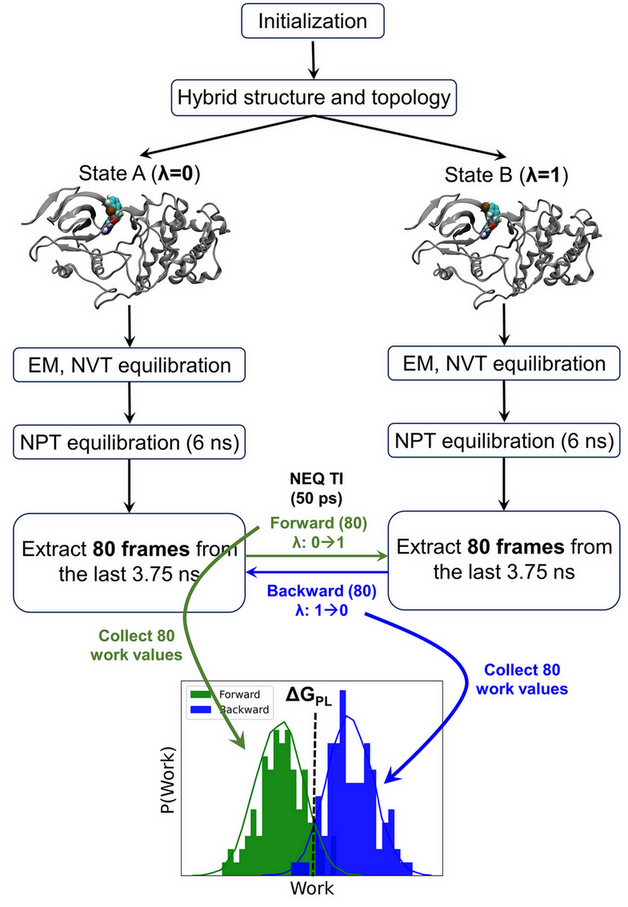

Download and unzip the input files.

In [ ]:
import subprocess
subprocess.call('wget http://pmx.mpibpc.mpg.de/Tutorial2025/Istanbul_2025/tutorial_files.zip', shell=True) #Download input_files.zip
subprocess.call('unzip tutorial_files.zip', shell=True)

import essential modules

In [ ]:
import pmx
from pmx.utils import create_folder
from pmx import gmx, ligand_alchemy, jobscript
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%pylab inline
from IPython.core.display import clear_output
import os,shutil
import re
import subprocess
import glob
import random
import pandas as pd
from AZtutorial import *
from IPython.display import Image

----------------
Step 0. Initialize working environment
-----------------

Here, we will define the paths to the protein and ligand topologies, as well as to the molecular dynamics parameter files (.mdp).

We will also set some main parameters: water model, salt concentration, number of simulation replicas to use.

In [ ]:
# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AZtutorial( )

# set the workpath
fe.workPath = 'workpath'
# set the path to the molecular dynamics parameter files
fe.mdpPath = 'input/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 1
# provide the path to the protein structure and topology
fe.proteinPath = 'input/protein_amber'
# provide the path to the folder with ligand structures and topologies
fe.ligandPath = 'input/ligands'
# provide edges
fe.edges = [ ['18625-1','18626-1'] ]

# finally, let's prepare the overall free energy calculation directory structure
fe.prepareFreeEnergyDir( )

`1a. Firstly, let's create a hybrid structure/topology for the two ligands forming an edge.
For that we will establish a mapping of atoms to be morphed between the molecules.`

In [ ]:
# this command will map the atoms of all edges found in the 'fe' object
# bVerbose flag prints the output of the command
fe.atom_mapping(bVerbose=False)

`1b. Secondly, we will construct a hybrid structure and topology based on the established mapping`

In [ ]:
fe.hybrid_structure_topology(bVerbose=False)

`1c. Finally, we assemble the ligand and ligand+protein systems, i.e. create structures and topologies that will be used further in the step 2.`

In [ ]:
fe.assemble_systems( )

------------------
Step 2. Prepare equilibrium simulations.
---------------------
Prepare simulation boxes with solvent and ions.
Subsequently energy minimize the systems, prepare equilibrium simulations and start the runs.

`2a. Build boxes, solvate, add ions`

In [ ]:
fe.boxWaterIons( )

`2b. Energy minimization.`<br>
Prepare the simulation and subsequently either<br>
 a) run locally (suitable for the tutorial purpose)<br>
 b) create jobscripts to submit to the cluster

In [ ]:
fe.prepare_simulation( simType='em' )

Running energy minimization locally (e.g. on a laptop) will take 10-15 minutes for one edge.<br>
You can use the command below for that.
If you do not want to wait that long and have an access to a cluster, skip this step and proceed to the next step.

In [ ]:
fe.run_simulation_locally( simType='em', bProt=False, bLig=True, ntomp='8', bVerbose=True )

We can also submit the jobs to run on the cluster.<br>
This, naturally, requires some knowledge of the cluster available, queueing system and some dependencies. Several jobscript parameters allow to define the environment on the cluster. If there are additional cluster specifics, the jobscripts can be easily modified.<br>

Together with the jobscripts, a script `submit.py` will be generated. This script can be used to simply submit all the jobs to the cluster.

In [ ]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2024']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgpu = True
fe.JOBgmx = 'mdrun_threads'

# create the jobscripts
fe.prepare_jobscripts(simType='em')

`2c. Once the energy minimization has finished, we can prepare equilibrium simulations.`

In [ ]:
fe.prepare_simulation( simType='eq_nvt', bProt=False, bLig=True)

In [ ]:
fe.run_simulation_locally( simType='eq_nvt', bProt=False, bLig=True, ntomp='8', bVerbose=True )

In [ ]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2024']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgpu = True
fe.JOBgmx = 'mdrun_threads'

# create the jobscripts
fe.prepare_jobscripts(simType='eq_nvt')

Again, prepare and submit the equilibrium simulation jobs to the cluster.<br>
This time the calculation will take longer (we are performing 6 ns simulations).<br>
On a node with a GPU and 8 CPUs simulations of ligand in water will take ~2 hours, ligand-protein complex will take ~10 hours.

In [ ]:
fe.prepare_simulation( simType='eq', bProt=False, bLig=True)

In [ ]:
fe.prepare_jobscripts(simType='eq')

### The calculations for this step (and for the following step 3) would take a while. Therefore, I have already performed the simulations in advance, so we do not need to wait. ###
`To use the pre-calculated data, simply change the working directory of your tutorial object "fe" (command below). By default, all your calculations were performed in the "workpath" directory. The following command will set it to the "workpath_precalculated". We will also set the number of replicass to 1, because for the brevity of the current tutorial only one repetition of the calculation was performed.`<br>
Note, that in the folder "workpath_precalculated" only the final results, i.e. dhdl.xvg files, have been generated for all the replicas for the forwards/reverse directions for the solvated ligand and ligand-protein complex. The raw generated trajectories are only provided for two cases: 'water/stateA/run1' and 'water/stateB/run1'. This is simply due to the large size of the trajectories: all the simulation data would take more than 2 GB. This means that `Step 3` can only be performed for this one ligand transition in water. However, this is not a concern for the final analysis in `Step 4`, because the results from the transitions are present for all the cases considered in the tutorial.

In [ ]:
fe.replicas = 1
fe.workPath = 'workpath_precalculated'

--------------
Step 3. Prepare non-equilibrium transitions
---------------
At this point we already have the trajectories for equilibrium ensembles of two ligand states in water and in complex with the protein.<br>

`3a.` From these simulations we will extract the snapshots and initiate rapid transitions from one state to the other.

In [ ]:
fe.prepare_transitions( bGenTpr=True, bProt=False )

`3b.` Prepare submission scripts for transitions.<br>
Each transition is very short (50 ps), therefore, we can reduce the number of required CPUs and flood our cluster with many small jobs.

In [ ]:
fe.JOBsimcpu = 2
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2024']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgpu = True
fe.JOBgmx = 'mdrun_threads'

fe.prepare_jobscripts(simType='transitions', bProt=False)

----------------
Step 4. Analysis
------------------

`4a.` Firstly, let's process the calculated work values and estimate free energy differences.<br>
The `pmx analyse` program will integrate the dhdl.xvg files to obtain the forward and reverse work values.<br>
Subsequently, the Crooks fluctuation theorem and Jarzynski estimators will be applied to relate the work distributions to $\Delta G$

In [ ]:
fe.run_analysis( bVerbose=True)

Let's have a look into one of plots (workpath_precalculated/edge_18625-1_18626-1/protein/analyse1/wplot.png) generated by the above analysis.<br>
A nice overlap between the forward and reverse distributions ensures convergence of the free energy simulations.

<img alt="" src="
gD7vCeiSMIJsRuTCJs0emZqIW8TJimQG3nrE4Qfg3FzQ+9caCdikovQk4vDdPphMANjslGw5vv+4+jIcPW7qMxsgvqrzVdIktolQMMRfUpdibkV3u6NAQApYzRn7iv3sT/rlZgfAEbaIvAAcyE4cyitZJ6ydh3YK1ZAA4OSWySoJB2rlQQK2AEyiCCQ4nBxoAAxSIxmsADekSGJuCdoHnMmEBfghTQIwbAjSA5IXl6QiJKywafjIzIP9BhUt2bYoCcgzieMFrAB5EmrAAADWgB1AR3IUgJm8wDYfM5IrzhhIncTkEhtIs6XV+NuWOSQ7ENl+vPOK5EqiA9II2pA0r3qdMZLFiA1Pij9b+cnOIQkSyNxDMgUaKTTJ/kOmIxqpCcniRJIQ+/zyAsBrDqyR5OcMAGcfDbqkZ22fpSBLAQ9sxIezD8tbF7wlrWJaBb3XXeAoEC4KOAAOF+WL2G+JScDGSYBDe8fBHTJ983TBXgYAI0EEKknoBeD4+NpGaqplgOe4cTSoYKRQbKRFfCnPbTyDZxEfT1IaM8x8z/WGbQE2pNsDoABHJEYbukUmLCRgUt1RUYWwGpLgo7q2NT4BZLLdkEeZJP7EX5OejwxSABcAi8qY1H4AHdl0kFBR5VJwAfUt0icAy/3ce9NNN2n2KO4hDR9ZfOCASdJOhRikX1IGkm7PxjMiqZIiEBU0VZZ4RysdMwYkcMZWUDpJngdTgtSNJoA0e4yHXMDcC6PCfPPuMC6owJlPmAskexgEm3i/3ABw6lpJJhVlAQBsqySRmGP9rvXSoFYDOanhSZKemS6vnvOqtK/bXt8TUC5Ms/dYSaYoZonC9Oeu/eVRwGuWCrR+HABH2LwDwEzskhVLZG/6XmkQ3aBI6jULpilpKTJjy4wcAG6RrBWIIgGAkSABVICNdwG8ADZAiM+waxJ0D7iRtg6ARgpGIiW0BrCxDkkAsI3DJictgEc7/fTTtUIKIE7wPmn8ADAkaoooIE0DwDhw4TzF8xkT4EfOZ1vkHIkaAKRPxmGrrlhVMapu8uzyTkin3qQGADDSNbmqkZTJff3qq6/q3zADqNG9DToA8qjWqfoCoJMrGsma5/Jv6ppazQH2aELfSHFaftBdXEQAACAASURBVAA41wlr9+YcG7AcNpxYwdwdqujFOxbLjtQdklgvUZrXai6vnfuatIp3EnCEHXG/quE6AI6w6WbCOGy+mf2NzN00V85se6ZEVzUOKNRJLURVBAvAWw9slVlbZ6nzFQBc0LPKmwraFshmClE/Y4fFPkv6RPK8Yu/ERoudE1U0ki35XFHr2sY7AbRI0yRTB+hsvViKGVCQAHspgEtSelTXACWfA+YUZqChPsbWS1J6pHL6HzBggDpRoeYFoGmougFnpHWvBAzII5mSAtLrWY2kDUCSUJ6xYkfGq5K/sQ3TUI/zXKR03o8ShFRtodE/pQqxKcOMoKrHbowanQYTAaOCJFx+VNAAcFtZtXtLyABsJdV52+ZJWkaatK7XWl468yUF4qKYarinZbzxjC/AJBNhR4cbbjmkgAPgcjgpBQ1JAdiUZvtq1leyYOsCGZo4VOKi4oJKrb7PtIfS5tTNMmerqT5iAJh6wLHVYoM+qzw4YQGC2C6RdAEOqgsBwNh+UQPjhHXuuedq7U7Al9AfwJJSawArTlbYfK+++moFLaRnQByQphYs0ixqYfqghitqZA557kdKRfIF2HBoAjCxJSPZkscbpydstthkaVRL4hoqqgDwACHP9IYpAao8j4pL2JFRa9M/4+f9GCdl00gk722o1gF9VN4wGt7vrRqb+5BueT6e4qjkGSMNaR0VNf+26v3wq6BzAXjXFkl+cZBZj8ElYKuKxvY7e8tsia4WLZ0bdJasY6aIRO5PqFudeT6SfURGnT9KOtQzmeeMQ1dhVdih9uWu+3VTwAFwhM2/BeAvZ34pC7YtUM/lOjXqFFkC3rh/oyA1VKlUResB16peq1wDsGUciLEDSLDj8hlSHADH36hs8RpGGgaUcHxCGsZ2CxijpgXU8ArGA5oE7UjNOG2hIqakIMCLlzAqW9TSSL5UTkHdbMEL1TZl5QBwVMEAOiFNeC7j2GXrOQN+jAdbNSCIFIvHs30XC3yAOc9Bxc2YR40apWOmIQUjiZMCtKDEGt6SbNYGxWc4iFEhCWYAGzUNsIdRQK3ufWZ5AeCVBoBRQR+vEByAeR9AGOaU7G4wlJhVAE4AFM/oUO24XJeZnSkjzhkhSXWTHABH2BkZScN1ABxJs2XGagH485mfy8KtC9Vxqn7N+n5Bk/CL5buWS0JcwgmSbZ462TivzE+ZL5UrVVYAjqseXJoOpwRcnOkKluYx2Pfevoui1gw0dguUSNXvvvuuStOhggXPtKpsfwn4/fVpVc2EXgHGMB/lE4C3GgAeGDIAWxAmVzRgDF0xsSAN142qK5nHMkMy01gAHnnuSAfAxdlw7t6gFHAAHJRE5esCC8CfzfhMFm5bqKDZKKZR/mo9ufbgfRn75NvV30rPJqZmZp22fiv6rN27VhbuWKiSw4CEAVI7qna5loDtbHC4ep2VODR9C6pzrU3AYb+zjk/2O773JqHw2mVtHzhJ0XxzydpnWbC01VF802J6x+o7noJWl2+956IWcPftv6DSbeUnE1ZbWbnTADAq6AoZQZ2w8jFHZgUDwoeyDsmsTbPUZ6JLoy4SHxWfp5IuiO4OgMvXmfdLHo0D4AibXQvAn0z/RBanLJYBzQdosgGvRGYdskjVN2n9JOlUv5Mk1UvyC8Cr9qySJTuX6IHFswpSZ5cHJ6wIm65CDdfG9xa29m+hOvFc7Nufnd/wq6BzE3GYMKQhxAEXkIgjoFYhF4RJNLN4u4mBNk7UnRt2lno160nWURPnVkBzAFzUFeXuKywFHAAXlmJhvt4C8MfTPtaDhXR7zePye3rm2UlNjC9pJtvXa68OKflAOjcOeMXuFbJs1zIF4JObnawHVLAwpHXr1qmzT2yscdjKfU6YyeK6L0EKEN9MzDMx0+GphpQDwGvSVkvyv4aElIjD3+uzjqtWrCq7M3bLopRFasvt2MDUg2WNE2AeoDkALsHF5B5VIAUcAEfYAmHCAEsAeOn2pdKrSS9JjE/0C67b0rbJjxt/lFa1W0mPxj3yAasFTsAXEOaZ/Zr1C2hPhkz2HpJckGCCNI956lcjYnDAFXSo2VCRgg6/8jgd3iLd5XF8JUlz5gYPcjzGcVjDsY01VxaMlu0D4ASAV+9fp8UYiiIBW5rYwg0UHVmQskDTUp7c/GR10DIJO/3ahB0AR9Iqj+yxOgCOsPmzAPzhjx/K8h3LpXuj7tKmThu/ALwpdZPM3DxTnbD6NO3jF4BRP6OGxlu0b9O+0jC6YdDDloMSj1oSPVSvVl2OVjwq2UZNSDrLQOEa2EuRrEgQgWdvJIEwHsg0PKEjqRWF5swLIVEwWIRlkVaTikllC8A5YUgrd2w3NuABpsrRIcP9FS6TlXeevCBMmJJ1WrQe0raAg73HAXAkrfLIHqsD4AibPwvAH/zwgazYuUK6NOiiKmZ/6mXS8xHj2zi2sdp38x1KuarjRTsWCY5YNo9u45jGQQ9b2xfZo2bOmCkHzU/akTRpHN1Yyxr6SsJIkIAvBQlQXZOg3Do0lXfycxgzblqTJjm29khoRaW5nVtbYYoQLMKryqL9LAHnArCRxIe8aLygKx0sFgCr9ibXJsw652/qYBMDj3aI9Ks2XphrHQCXxWy7PqCAA+AIWwdMGJz7+z+8L6t2rlIHq471O/oF4NV7V6vaDY5/cIucpBC22cNuwfYFAlBzMKHO9nXoCkQee/+G9Rvkx5U/yp6MPToOvKhtSIsefOThNQBMTC42RcbfqFGjfNeU9ykg3pdm43/L+3iLS3PuR9q31aLK6n3zAXDbNrJy205J/rdhHEsAgC0I0wcx75v2b5LVO1arRiapfpLUq2Gcs0zSDgfAZTXbrh8HwBG4BhSAzc97P7wnq3et1jhFvDsDOVgt2bFEwy+IF8bO6wvAP6X8JCTjoPVs3FOa1WoWVALOe0ZuuNO8nfNkY+pGDYmqWzV/piZ7LQkzyGPct29flSQjqVGQgUbWqEhqkUZzLwB3MAC8YtsuBeAKldLMmiy6CtrfnLEXUg6myIpdK+TY0WPSsm5LaRnXUqVj/ss8mikuDjiSVntkjtVJwBE2b23bGQA2h9E7U9+RdbvXqf23W6NufgF46c6lsnz3compGqMZs+D8TwBPkwULWzENR63C5s7l0KScIQkPejfprfZmf8wAmZ3IWUyeZbJJlYVNsaSmlprDNIo2REKztC0uzVHFFiYhSHFpcwIAb9ktyS/1lwqVDQAfMwBcAtW2vGMkPpisWct3LpcDhw5IXEycRgtUqmjqKJtUlABwh7ouFWVx59XdH5gCDoAjbHUAwBVMZZh3prwj6/eul8S4RE204Q0dsgfZwu0LZc3eNWrj8q31a6/HRgx48m+AvEVc4R1uftz0o+Bx3a1ht4AOYYABqQ8BYLynIwmAKZBAI51lJDQvAEcSzU8A4K25EnAVA8BHSx6AbepKfBaIBDhy9Ij6VAD0R48dlZHnjFQbMeYZlws6ElZ+5I3RAXA5m7NgwGQB+K3Jb8mmfZtUYrUezh7xViUX1Msb9m2QqpVPrHRkAXjWlllCSUL+3aVhlxNCmkIhzw8bf1B1HvZoktcHkoAjCQy87+0AOJRVUPxrfMOQ1lAPuIiJOEIdDesekw77xRZdIFRp/Z718ulvP5VejXtp6BIA7EA4VKq660KlgAPgUClVBtfZpPzW09af+s/WAwaAt+zbIngtE9eYTwLOtc0i3W45sEVtv1Q68uZ5ttfP2DxDdhzaoYcP6rfWtVsXWjol2cfOQzs13SUgHk4Ath7YoR6WwRgept0BcBksftPFCQBMIg4AOCtwfHlJjsxKxLvSd8mizYukUa1G8sJZL8jFHS/WbkJZKyU5HvesXz4FHACXszmmUk50dHTAUSkAHzsu/5v8P9maulUa1GwgAxMG6vWLdy5WsEUKpc3cMlO2p21X7j5Qlivstxw4ANdJ9U86QYUcjDwcWlPWTxHSXlI/NVDCj9JWQVuGAqk/PTNd81qXVHMAXFKULPg5+QC4TTvjZLhVBms1pMLlgi7uaFlLezP2qoNW1v4subjPxfLUaU/lOGm5zG/FJa+730MBB8DlYDnYKjwUXaeAOokq+JvSczSbQYq/KX3H9aMmjZKU1BSpW6NuXojR2DVjtajC0FZD9T4Lrnh1oqb2LdrANaiPOWwo19axXkdpV9cAfCEOGYB78obJQuEHQphI5uHPHm0dgijXV5o2YHJfZ2RnyPDWw4OqDBknsaDkv65ZpWbAFJyR7oRV2jQvqS3ktQF3bN9aVqxNl0Ev95VKUXuMDdh48JewE1ZB48bu+3Dyw/L2wrfl9SmvS4UaFWTcNeN0b3nD7ELVtJQUjdxzflkUcAAc5vm04IuU9dRTT8mYMWPkiSee0JqxTz/9tNattdV4LACjqn77h7dlx4EdEl89XgY1zwmP+X7D91r5ZXDznJjf6Vumy77D+xRcsWU1qtnohLedtmWapB5O1WtI6NEmrk2hKTJl0xQh1R/xxv2a9PN7P3HAvFu/fv0kISGh0H2EesPUzVPlcNZhOS3xtKC3ZB7PlK9Xfi0nNThJ2sa3DXh9pAGwfZGyonlQQhfhgg4GgJevPmQAuJ9UqrlbjmeXHQDD8LKG3r7wbWkV30q+WfWNvDDtBRl5wUh1UvQ27MN4TQPYrjkKFJYCDoALS7ESvt4C7GOPPaZAe99998m8efPkb3/7mxZ2t9w2NXgzMzPlzDPPFLIUPTzqYZU6a1auKb3r9VYV8oydM1QF3adeH5X+5u6eK4eyDym4to1tKwnRCZJ9PDvfYcE1h48e1s+b1Wym1/leE+iVOXS4ds7uOZKenS6xVWKlZ92efi9n7CkpKVKnTh2JiYkp8YxSjIX3nL17tiZUgAbVKlbLiev0aTYrUmpmqszaNUtaRreUtrUCvze5kWkNGzYs4dkv3ceVNs1LbfQGAH9z4TmyYUtFGfhSb6kcvdMAsCkJWUYYZzNhvXrOqxpn75VyWTt3jbtLUvalyFNnPCUJtXKYSbymAWLXHAUKQwEHwIWhVilcawH44YcfVmC64447NBH+I488ogCsm9tIvAD07t27tWB7jZo15OanbtYYxuoVq0uX2C56ACxIW6CHRZeYLqqK5t+AUtbxLGlSrYm0jGqpf1tuncNkUdqivGsaVG0grWu0zndNQa9sAXhh2kI5cuyIRFWKks7RnQOqfr2q9JImJWPh3RgL79w5prPUqFhDE+77A2DoszdrryxOWyxNqjeRNjXaBHxv6wxnneNKeuyl+bzSpHnpjbuC3PbHG2VLSpQMeLGXVKm13QCwiWGvUDZpQH1TUcLQ2SQ2rK3LP7lcPpnxiVSJqyIPJT8kd/S7Q6KrBvbbKD06uSdHOgUcAId5Bq3n8+uvvy5z5syRV155RYH3gw8+kPfee+8EFXSHpA6ScSRDRn43UvYf2q9VXYYmDtUYxokbJupBcUqLU6RqpaoyYd0E/U1hcjJcdanfRSVlCyj8PWnDJAVk7KbNYs01Jg7Se00w8lBblWcgRVOMYUiLIVKloifhR649ed++fTJlyhTp1s3EGpvk/l47Gn0Uxu7sD1B5BxLtMxbUgoMTBktsNVMuMdcj3HuPpmo0jMq2g9vUTk6sZ/eG3QNWx4m0TFiWlsFoHmxuy/r7PBuwwdmuXdrJipUi/V/oJ9XqbJJjWSYfdZgA2IYn6TrNXU9jVo+R+ybcJ4tXLZaE5gny8CkPy+UnXa7lDwFp9pg381xZ09L1FxkUcAAc5nmyUhWH5ZVXXqnJHrAH33vvvZKcnKxARS5lfnNtxw4dNUvPm5PflNT0VN3wp7U+TcHn+3XfqxqMrFdRlaOEQ4LczNhnqYHao1GPfG/LYfLduu9yQDrzkBZt6Nqga6EognQwcd1EZQB4zpDEIar69W283/jx46V3796aCas0WnpW+s8AbHJfx1WLK7CbLWlbZPqm6TnlGn1o470x0ryg7djLgualMY88ExswTlgDnh9oJOBtciyMErAXgBmbN174tXmvyd1j7pZaMbVkze2mOlil6vkYXK53jlqltUoi/7kOgMvBHFrOnzJw48aNk06dTIGFjvkLLNhhtm/XXsH2jYlvSFpGmm7u01qdJhlZGeqNDOc9pOUQzX41etVoaRLTRB2x8PIlXhiVLIkHaEiKE9ZOUPUZ1YwaRDfICSMyYU4VKhZscLOSAP3ieWyTFZBxi+fZfgrKysQYVN1n8u6SSYuxki7Tn9Ra0DTZ62E0iEmmT95Vy8758ei2n1EFau62uepYg5e4lzaRDMCRnwkrpx7wmgNrcuKAs4+W6S4NpRqS1+ZLrH3qkVSNIgCcn572tEYDJLdI1nFzLc90QFym0xgRnTkALifT5AsUVvL1HR5hSIczD8vrE1+Xg4cPqvoYCfhg5kENKWKTU/moZtWa8s3Kb1S6I8yI63wrIgGa49aMUykZT2jCcaiIFAoA2mtU6jQAjNoNf6cTEn7kAqC/OGALwKTCBDhPTTxVmYDCqqPtWIhFRqXMIcgB6C/sij7t80k/uGj7Imlaq6nGSQdqkSYB/zIAuIOsSVspQ55PluxMnbUy26mhAHDOiI6rZso6X/FvMs8l/itRxJSQvqz3ZfLg4Ae1SphrjgL+KOAAuBytCw5OaxtF7eyvAcAZmRkKwOmH0/UQGNZqmEqw0zdPV6AlCUVMtRgFYDY/wITUjK3YHhzqtGTstwAwkiJSMpmybFrLYGEVFvRQXWN3pQHo1B0mNtl+H4oETCwuGbmQWpvGNi0UAHuzhpEOk9SafFZQZSc7piU7l8iyXcu0jnFBiTscAJfNJvHagDsktZKVG9Ol/z+TpWr8FmMDDp8Tlq8K2pcaNvsawI20y7p6fMrj8sm8T0SM8/aN/W6UP/b5o3Sq1ykvz7RLbVk2a6q89+IAuLzPkM/4ktonyaEjhxSAAWI2PACMBAv4cAj0a9ZPalWvpQDcvVF3BWBClk5vfXpOUo9cRxLstgAwql+kZFTH3FsYCRjJGwkYByzAuG+zvtIwuuHPaQVDkIAphzhjywyVWotSDEKFI6MxB8hRKdO6NuyqmbkKUkHPT5mvxSr81Uv2kt0BcNlsEi8Ad+rUXJYti5eeDydLraRZkp1e05hFyiYlZagScDCqUKTkscmPybjZ42R4v+Hy7RXf5tmPudeppoNR8Jf/vQPgCJtjAPjgkYNqA0YVjdSJ0xX2z3mmtCANKRZplgQCAOqe9D1a8eiMNmeouswCLFIxAEws456MPQqi/Zv3LxQAHzhyQCavnyxxUXGyN32v2pC9NYVDkYDX71svs7bOUqk1lFzUdvyAPwCaVC9JvcHX7VsnVICiURiCUo1+ATiXAZm9dbaWYqwTVUftdYFK7zkALptNciIAx0mPB4dJXKcfDQBHRwwA++YjH7NqjJpDqDbGnnth5gtyftL50q5OOyWsA+KyWV/lsRcHwOVxVgoYEwCcdjhN3pj0hmRnZeuGxvEJCdeCDyAYHxWvXtCDEgapdAtQndnmTPVUtgcd9tvxa8arnZh80IQPkVe6MBIwzidIwI2iG2lFJAo6JMb/XG4wFADGGWrOtjkaAgWYBrMB2+8BbtTu2I6RurHpLt+1XKnXvm77gM+y74cHNGNGW4DjWqCwEQfAZbNJ8gHwSUYCXlpbut57ltTtMUGyDsVEDABbauEXYSst2c+Qigcaz26pKXJLn1vkT33/pOlfXft1UsABcITNOwB84PABlYArHq+otl9AE5BdunOpvg0ViXCsQro9JfEUBWe+G95muHpH24MOlfG4teOkfZ32Ws0IuzOAXRgARvIGgFEdowLmMPHmkw4FgFfvWS3zUuapFylpIQsDwAA3qmvKMi7esVgZDRqSdLBnTd0wVXZn7FbVO1oE0nj6aw6AC94kmm3M/BdIgxDqFjsRgOtI5zvOl/r9vjEAHBtxAJwHxLle0BqrbuLlcZb8x9R/yOQlk0Wqi1zb61q1EVNPm6YStDGpuDjiUFdO5F7nADjC5g4Axt4LAFerUE3BtV/zfqr+XbnbZC4wDccrPJq/W/tdjn3YSKmop7EBa3KKXLssmbSQgFHXbj9osg2Zz5GmQ2kWpAF+VNBt67aVDfs3qDrbC3yhADDjXrB9gZYzRE0XKgADtth8ieFF3UwlJOzJNBiCgp5FHziPQUtipmFU0A44AA5l9kvnmnwA3LmpLFvSRJKuu0KaDP+fZKXFRSwAB6IWcfvPTH9Gxs4aK9cOvVbeOO+NE0p5AsYuxWXprLfy8FQHwOVhFgoxBgXgjFR1woqpHKOq455NeioAr923ViURJFAAGGBE6gVoZ2yaoZVckIytVyf22/Frx6vDUkpaiuZQRhIMpVkAxr4MkHWu31n7J4wIx6+fD1MTU2wcvwoKQ0JtvGjHIlVdhxIGZZ8NcM/fPl8ZCP7HCW3HwR06/IYxDaV3k94BpXls5xPXTxTU8AAv740N3AFwKLOfc41dA/gX4NDH/BWneQG4Y4eWsmJDBel+94VSq+M0OZpR4xcDwL6qacp5tohvIQlxCaqJuv+7++XqLlfnCxvkHicRF2d1lc97HQCXz3kJOKoO7Tuo1AsA16lWR4ETAEWVyt+AK9IfAExMLHZfUlESZ4t0S/1gC8Coj0nEgfPT1jRziJoMW9hTQ2n28N11aJcmAOEZqJKxp3pDmUKRgFGP8z/OW6F4YdtnEkKE2hnpF9D/ceOPGg9NIwyrIIcyTd1pMniRBATVM7QJVJLQqaD9rwi7Bph/HAPPbHtmsZJN5AGwgfakViYO+OAKGfLiIMnOoBJS2ccBjzh3hBZjCBaGFGi/BAvl82cjxiQ0/NXhykgnd0iWP/f/
s5zd9ux8XYRiIgplD7trwk8BB8Dhn4NCjQAARtoFgBvWaChk4elQr4OGGiHRclgAvsTizt06V85qd5aWViPlJIBEnK09UFAf8zk21C2pWxSoUVmH0uxhuePQDsGWyjMA4KqVq2oscGHigAHR5buXqyMX9uxgzfbNfYAwkgP9Y4umX75HbWczEXmf5y+BCAcl1wLa/g43B8AFz8jUjVN17ZGRLZAaP9icqkSdaxphDnIyYa02ADxQso+UURmk3EHaMCRUwphFSrtZIMbuy95csWuFekqPnDtSxPCTXVt1lQeGPCAXdbhIaUQMsfOcLu1ZKZvnOwAuGzqXWC8AMGpfALhZdDMNo8GLmc9Qq7IxcSoir/PMzTPlnHbnqJSHQ1avpr2kZVzLPAAGtJECSYCBAxUOXWTVCqXZwxLbMQfwwOYDFYA5TPAoti0UCRjv7VV7Vmm+arJ1BZMc7DPtfai9AW6keetkhoRrE4/4A2AAA60AfXHo0S/SuwPgUGY//zWYOvYf2a/0Zu0VVULLp4Lu1EJWrKomrS++R5qfNzIsYUgvnPGCAnAwnwRfirGmuAeTBqlVi9rw8h8xb4T8a9K/5M4hd8qTQ5/Myb6FXdgUXaE5IC4qdcvHfQ6Ay8c8hDwKLwC3iG2hTkdItUizbHZb2YiMWgAyxRHYpGNXj5XODTvrgWIlYNTHSI2AF0BONixN1hFC4VV7KJHDGdUvoAsA+0rRtrLSvr37ZMKECdKrVy9JTMwJU6IhbZAQg1AkQqdQBQezddm+cbpat3ed3of3NtI80j99ol4/vVVO4hF/AAy98EYFsLEDQwPs4w6AQ16KeiG0RgW9P2O/zl0gGoby1BOdsBpLva6vSJf7by7TMCQ7VtYGa7GwDAXRBDj33TfgPl2Dha0VDE2tFoexwOTGVI3R9LJois56+yz5XbffyQ09bpDGMY11uIVlEkKZD3dN6VPAAXDp07hEe7AA/NrE16RNXBuBS0bdbFNJcmBc++W1siJlhVzZ40r1rARgAGCcs/CQtgCMwxJSINIfAIxEDACHkjTebnhU4MTT4uCFVzKSuL9n+HXCMtgI2OOhjQc1hwwMg7ecoT/i2QMRD2gYEKQu1OtIYuR15sDj0MIBzRfM7b04uzBuaMd7k4rSm0LT269TQQdewtDaepMzB94saIVd+P7CkGonvStdH7xejmUaB7kytAOrdJmb37yw74H5A4bk70P+rhqowgKw7c8XiFm7M7fMlKs+ukrWbllrqkRVkZt73Sy39rlVQwnt2laVtlFTh8JIF/bd3PUlSwEHwCVLz1J/Wh4Af/+aJNVJUgkwulq0Ah/g+u/Z/5bnJz4vVaKrSFZGljxy2iPycPLD8vnyz9VWirOSBeA86dWAHkAGIJMtqzAADHCTxxnQhRkAkHmGjanFYSz9aLrUyKqh5QjzScC5ADxn6xxVgUdViVJJOpA3siWuPWjwesYDl/vwngZQW9dprZI/Y8EpyBfM7SHPfWTCQnvAmCnGEKgQhAPgwMsaz/lJ6ybJgcwD0qtxL11jRZXGTgTgeIlpNkZ6PHolMp75v4xtwUXszwIw+w4HqqICsBeIrSYHUM0+ni2fL/tc/jX9XzJz5UxT71DkgeEPyGOnPKZMg1c9jTTugLjUj+Uid+AAuMikC8+NXgDuVLdTTuiRaQANSeDvGnuXAhAqaK06eETkL8P+IsNbGWnQcOYAjQVggAdPaRyvkEABZE1XmWtfKugN7WHJfQAh3tYbUzfKmj1r9BnVKufUBMYOvfvwbukd31smf2+8pXv1/FkFnQvACqTGC5t0kjhDoWorSO1nvwP4kXRRvZNFi2QehCNRZIKsWIwDMPc+yztuVN8k7Fi9d7U6caHO8wceDoADrwRs7ZgxSOoC7b1JWAq7Q/IBcKcEkws6RqLq/iA9H/+tVI4yhUeOmkQpZSwFF/YduN4C8CPJj5QIAHvH4Ls+Uf8/8f0T8puuv5Ebe9yoe5uYehht2zgP2NPFTZRSFFq4ewqmgAPgCFshXgDuUr+L2k5xsqIu702jb5Kd+3dKjRo15M/9/qwOHDtSTVysER5uH3C7XN/tej0kASSk3GDSaygATP5l9bZue5ZKkjABw1sPVxCl0dAGJwAAIABJREFU4SGNBNwlpov8MNkcpj1PBGALpEjNqMM1WUhuvuaCxkBaP+zYMB9IvsQTc/BAD+KKUUH7hhbZAwzQXbpjqWoN8KZGgvbmsPb26wD4xFmw82PrUGPmIByMVKQlIgFrMYZY0/ES6fvP30qNxpuMGtowdb9yAGYm1BHLMNiqZvbxcUBF3e+FftI1savcM+Ae9ZyGsXWtfFLAAXD5nJeAo/ICcLcG3dTuCoeLFPLEpCdU6r2h1w1ya69b5adtP8k9E+6RfYf2KVc+8vyRck3Xa/R6wA7pdfaW2QpUqGxRQ5/R9oygNlg9BHJDRugfZyhUbaiwscviSV2rWi3lxvGyzjI/naM7y/Qp06VHzx55ErA9PJDCAVL+jTMVTlWhADDe14Rk8W5Ir0jgSLIAMGrtvMxfHjD3xhAjrZO2U7NpmfzZgSoxOQAODMDEXeNHgCTcLLZZSIlUAi3un8OQRDq0ay0rtxyQdpf+Ver2GmdMKgfk+DFShZZdPHBRj4bSlIB9x4TK2aqY+Q1T/cKMF+SVua9Ixp4MaZnQUu7sf6dc0uESqR9dX29HJe7KIRZ1dkv2PgfAJUvPUn+aF4B7NsxJfsHh986id+TtOW9L9ejqMvLskSr5aWad9J1yxv/OUEDDQWnuzXM1GQcN0AWosJXyN9IsattQYjntYUn4EOFAOJvgzIQdlmQeeCOT2IN0exUqVZCONTvKrKmz/AIw3shUY6L1b9Zfw5FCAWDUb3ibol4jhpdnEA4FPRgHqnVfMPeGMGF3JosYDADJTAjnciro0JawnR8bzgVTx7wRA17Ulj8O2CTiSFshw0b2lCMHjBkhu+zqARd1/PY+C8APDX5IzmpzVj67bHGfHfB+zOOGN7FpKzEnjZo/Sl6c+aLsWLtDLjvtMnnnwneUKbZ+EXlOZrn35j07998wxKH4g5TaO/0KHuwAOMIm2QvAfRr3UQBGCnlq2lMyafkkadqgqbx0xksKYLFVYzXH8bMznpW7v7lbfVgGJA6Q73/3vW5C1LDYi85pe47akr3222AAaA9LbK2onXkGntionAe1GKTesLZUYZUqVSSpRpLM/WGudOvZTVol5gc67uFenkkWLUq3BVNjMj6Vro0TkOXqkXwJhaFCFM8kvaQvmNvnIvXuPLhT+jTrI6QC7NSgU8CYTycBB5aAcbJDE0HDdAD9i+r0kx+AScSxRgY+OVyOZhvHouoZBmDK1gmrqEcDIAhdnhr6lN9Y9KI+t6j3vTP/HenSuIvmaKc9Pe1pObfduVoxzLXwUsABcHjpX+jevQDcr0k/tQHjiHTfd/fJii0rpFerXvLEqU+oZAgIktoRLvbyTy+X9396X7nkq3pdJW9d8JY6KmErZTMi/ZJbGXU0xQmCNa8qF9vr2e3OVkccCkAAokjfqJWx01arWk3aR7WXn378yS8AW0kW7pyUloFssd4xcS19kXkL6Yu+GdOprU7VzF/keUad7QvmXgcuGATog5SO8xAZxZwEHGzmc763dETrwRxTdg/HO7QfgapKBXuy1wmrQ3ujgt6812h0lkvtLtMk6cYnJOsgBRmOBntM2L9nv2EThynFJl7UVJbFeRH65H/mBO0Q+4N9wl6954t7pHLNynJllytzzEUmAY16V5vv+Y3ki/YKB8Xi2PSLM/5fy70OgCNspr0A3L9pf7XbIoHeMe4O2btvr1ze63K5qbtxxjJxrgCZzctMersLPrhAVu4yFZOyRcOT8JpE/Xte0nkazkSQPw5UJCBAiiwoHMgelvSNGhonLBxDqEEMmOHshT0KB63qVatL26i2smDaghMAmIOc+F2ycBFegSrYW0840PSgPqOSE4dH9tFsTURCyMWwxGGSkZ2h4Ay4BgJz7JYcOHiFkyUM9bNv+UL7joWVgINJ76W95Gz//mKvS8oT1vaB3R8nOpvxCa0DYWHBvNihga+k7LUBJ7VtI6t2bZFKGYekZvNl0vPv10v24ZoGHIx3fwQ0mxAHj/xwNuZBbb5mb1h1MnSG4d6/b78OrXpMdbXfs5ds9aV96fvkmm7XyAMDHyh2GFU437+89+0AuLzPkM/4vAA8oOkALSg/ds1YuXfCvXL0yFF58swnpV/TfuoQ1TK+pUqUNFTVxL1SaWXz3s2qjr6u13VyeafLNRWlBXKAlA1LVik8gwOF5tjDEgka8La249GrR0vdqLrSt1lfBWY8jAHgNtXbyOIZi6VrD2Nr9aig2fA4kGG3zczOlA71O4SU/g/wJLkIEi6qZ+iAtyd2XwAYUOXdA4E5Ui+SGgAM04DEDvg7CTi0DWHphK0RR764qDjVuqCCxgEvmAnDXy9eAG7fKknWZ66Q6JorJG1LI+n/4oVSsXK2ccQyXoYR4AnN++V5KZd9CPOJ5LW+a7mhf8wPGiBywKekpkiTuCbKNMMEs49QoeNBfUffO/LZlkNbHe6qUCngADhUSpXydRw+R4/mqNeQUipVysn16tu8mbAGNh2oCTj+O/e/8uwPz6qz01eXf6USLN7BSHXUxKUBhoAwjljnvXeebNxr6uYaYeKmk2+SV856RaVfwnJQJWNTRoLERtS1kX9QsoclNmTAG9U1GxfVL6BKXmDAmT4B4MSqibJs1rI8ALZqOVUlG7C3EkOr+FYaGhRMikSyADjxXEYaxokMxzMLwDAlqM/85fLl8EF6JoMWAPz1qq+lSUwT9YS2/cKEMH7KxC2cvlCl5aFDhwZdBYwFW3qT2Cb6/LJsjF1zR/ArQAnIkpaA0XLgbc/7EoZGRrF6NQI70UFXvOZheOrXrH9C/VvGx/y0b9lJNsoyqd/2a9k8/uyIC0Uqy3kvbF/QlwYDyr4DbDHlcG4QVsZewgx118l3yR96/UHj6rFrO4eswlI6+PUOgIPTqFxd4QXgwc0G6+a597t75aOfPpK4WnEy87qZGo5z4PABaVu3rYIQjYMSW91FSRfJhtQNkvx6skrJbKxlty1TtSHfn9f+PJVkUE1zkGpxBJ9YQ55ngYrDFC4aAMZ7Gimb5wLkqJ/xNK5apaq0rGrqu85ecQIAcyBPWDdBNzzAz0EeSBL1TgQ2KgAYgOUQWbprqarQUIGiPkcCJi4VMMc+6X0HQBLpGQctagZ/s+obfVfU9d5ayaNXjZZujbvJzkU7VUIfNjRwpSgr8WH3psYyz8KGFoyRKI3FVZYqaA5rmDDmYeWelUpPsov5vrelD6YGtCQd63UMqPL3AnCr056VZSPvlJP+9BdpcPL3xg4cU2Z1gUtjbsrTM/OAuELlPE9tbPoLUxaqmapLky7yzOnPaJpZ10qHAg6AS4euIT9VA+qNfWb9+vUyevRoycrKkvj4eLn66qv184ASsElFObh5DgBf/tnlMn3VdOnYvKPMuG6GgidFEZLqJelBR6NWMADLAYlUN2XjFDn1jVPlaOZROeOkM+S1c15Tz2HCibCnkp0KBw4AmBzNvipF+2+8iXk2MbcAMOUBcfQAkBekLFBbdOXKlSWhSoKsnbtWOnfvrCpoC3RIlgBWXPUcFSb5mFF9BwIubwKIb9d8q45TeHQzDlJJ2kpMACzJOQBBbMTelHyorPke+zAaAoCc/r1ZwijmgGSOXXjn4hwAHnpq4IPIjhdNw/zt86Vbw24hqdJDXSjBbKo2BhQtAAURrAT83Xff5Ut+UtISMHHgmBl4X94bhs9fOJcdP3RF/Q9gB7K5c21Sq46yIcswbDffIrMffFlaXvS6tL7sZck8EG80PeXfESvUeS0P13nXFusDKRhtxpY9W0QOi5x20mly/+D7ZXDCYD0H7Fp3EnHxZ88BcPFpGPITvGpme1N2trG5VKsmI0aMkBkzZsjNN98shw8floEDB/pVQ2s9YAOQ/5vyPxnaYqjmQk5+M1nWb10vF/S6QD67+DMZv268pGen62GYWCtRu0rNStWDT1Mu1sypoHLTmJtkxLQRmrzjr6f8Ve13/Zr3U/U1BRLYjKhl7fX+XvSnHT+pt/Ppiafr19vTt6tTDqpIvKpTM1KN7a6iNKvUTFbNWiXde3eXFgkt8j1q7NqxCp4czqhtezXqFZSmmZIp3676VhNpqPRuKjI1jm4snyz7ROZunqvZt+pVryf3Db5PvaG9Lduw99+u/lY1BO3i28n3G75X9Rte5balZadpeUMqSKXMTwkKwPa+edtzCktwH8UyyrJ9s/obaRjTUIgPpx04cEDGjBkj/fr1k4SEhFIZytrUtbJ853JdN6QdRevQNj5wDd0DWQfyALhj3Rzm0F+jHvDqtFUy6KnTJXV9gkQ12CpVaqaVyju4h+anAKppvLhxYkRAeG7cc/LgOQ/Ko0MezXehTehRUkzdr3EeHACXk1kfOXKkfPvtt3LppZfKsGHDpHZtUxovN9sUQ8zMzNR/d+3SVXYe2ClPf/y0DGwwUNakrpGLx10s6WnpckP3G+ShXg/J+M3j1RGpQ+0O0jK2pd5HsvwfU37M+wwJdM72OXLDxBvkYNZBiakeI3/r8zcZ2nSo7MzYKSv2rlAApuZwpzqdVEXl9VqFEyYBxryd8yQ1M1UGNh6okujew3tlxvYZCj7bD23Xvo8cN1mSqjSTzJRMadSskdSrWy9HAjY/mccyZcrWKdKoRiNJy0pTO1Pfhn31e3+NfrkGdfXUbVOlU+1OKqkz3okpE+Xtn9422Qhy7zSmrsrVKss9/e6RG9rcoDbv48aBB+3AD9t+UKBoU6uNTNk2RSobNVy/hubAMT+8F/mrZ6TkvEflXZV1nO3bBY6btEnyZ26fqbROjE1UWuPUovVhPRmcihInm3U8S6pU8F9blucdPnpY36lO9TrSvX5OHuBDhw7JihUrFHzr1q2bVwKyJJY87wPNVuxbIesPrJc+DfvoWqhfo750rtM54Hphbc3ePluaxzSXznVPvE7HZuzYw5KHyabDm2Twc4OkQuWDRuo1bNPhGnI8K3IScpQEncPxDMxSMOHXdrtWbut9m2o4msc117wC+Io8OflJuWfwPXJS/Zy4Yi05yqT5JvQIx+DLWZ/BmBMHwGUwYRZI9+3bJ6NGjTrhIPz9738vKSkpsmDBApVaXn/9dfnoo4/ypBa40AceeEB27twpn3/+uVSMqijXPX6d9KjRQ5YeWiqPbjKcqQGbW5rcImfWPlOmp06X9GPp0qp6K2lUrZFukIxjGbLw4EJpUq2JJFRP0ANyS+YWmbh/oozZPUapMDR+qPy+4e9l65GtkpKVIpXND6DaqWYnv8kVAKplh5ZpX11qdlGnjoyjGbL40GKpUdGEMh07LNGVomX/0f3SIqqFtIptJYeOHJJjR3PAlU0LsM0/OF8aVG2gzwGwOtc0+YQDpBy0wH8w+6AsPLRQEqsnSnzleJmaNlXe3PqmSvNRFaKkYfWGsiZ9jdqyAN5OsZ3k4dYPS0XjRbsna48sTV+q9zar1kx+OviT9ke/ADDAwjW8W+NqjaVjXEcBADOPZAZkCioZ1E87mibL05crbetXrS9totrofbwntIJx0LAQ8706TAVp9l2RxpceXCpta7aVOlXq5IE6t9trDmUfkkWHFkmtyrWkQ40O+h6o3dGuwLxZB79gfYb6Pf3CEKzJWCO7snYp7Xj36hWra9Yzy3jY59nrd2Ya5i59hdKnXY12J1xnAfiu2+6SXRV3y6Bn+0tmWpTsXdLT5IPeKDEJqyMmJ3SotCxv19lMXpefdLnc1e+ufMN7d9G7cuXbV2oc8a29b5V7B96rDoyuFY0CDoCLRrdC3WUBGHD94osv8iRbPsfb+bzzzpOYmJi8Z959993SvHlzuf322wUVNTbUPAm4c1dV+b709UtyesLp8umqT+WGr410ZwSDsRePlX6N+8mkTZNkz+E90qthL2kaYxxizA+OSd9v/F4SYhPkpHon6WezU2arOvsvP/5FNu3aJO0btpfxl4yXtftNcg8jvSLNbE7bLMnNklU17LUVqSRqfmZsnaHq7iHNh6jEDLj8sPkHlcBpSDpb07dKXfNzcN1BadWulTRtYmr2Go9vNjr3Mq7W8a01FjgtM01OSTglIH1tv2TOmrxpsnRv2F3fMfn9ZFm2c5mO8YuLv1BQnr9vvry75F2Zs3mOcuenNj9VvyNkaermqarqhh5Tt0zVUKbk5snaL+/FNTO2zZC2tdtK1iaTzdp4glJK0V9jHgHXjQc2yqJdi0yUTAU9lMjVrdKBoQv27V3puzRdZ1LdJHUYC+agZZ+77eA2HUv3Bt3VpKDaiFzHOEsPNA8/bDGOc1H1dA3wvqy3OXPmSFJSkjRp0kTVicE48lAXtq5dw1TM3zlfGN+wFsN0jPBNg5oNOoGBstdvSjOx4Slz1VGL9QmjYDUCP4chHZe+PfrK+oMb5dT/9pa9y0wWtYdHStNhn0rSTU9IZqqzA4c6T0W5zmpz6kTVkUbRjXS9WXsv6weHx4XbFkrqvlSJrxOvvhOEAxILbhnLomh5ijLW8noPdOLM+MvAv2ikRqBkLA6Ay8kMLlmyRKpWrapOWNdff708/bRRMRs7sHXSssPEBswh/taUt2R4y+Hy5LQn5f4v75e4OnGy8raVCprTt0zX7FjYYetH5SRgp41ZM0Y3CsBAA4Siq0TLWwvfkhcmvSBVa1aVRX9cpOCIEwZOMtM3T1dbUCA78LQt0zRrziktfgZN+meMSMSAzap9qyQ2O1ZSFqRIt17dpGWLlnljQj09dtVY9VYGfEkPeXqrHHtyQW1/5n4NJaIM4uSNk+WcUeeopHt9v+tl5DkjZdLGSVKtYjWtjnT+B+fLuGXjVDq+pf8t8s9h/5Qxq8bI4JaDlT4zt85U8CeJh20ph1I0R3T7eu2N9LVXAbogJyzuW7xrsYZwAOCNYhtJj4Y99HGbD26W+dvmKyjhdKZ5p+NaBXvFvO+3HNyidnXuaxPv364Mw4UTneZjbpaTjzk1NVXGjh0rffr0kRYtWoTcX2Eu/Gn7T7rWzmx9pszaNktjS4e1DOwtvunAJs0/TjgcqVQDtaQ2xgaculqSnx9sHAWPyYy7PpKKVTOl7zO/NWUJ/YfoFWbc7tqCKQCAkubVpnr1Xo2/BICMIECCn8yDmZLYJFEz71mGE/twnlr6V0hsADgzK1PeuvAtdYR1AFwOFgHcodbp9TT+jYT72WefCRmXuCY5OVltwf4kJAXgQ7tl1ORRckbiGXLdl9fJmz++KR0SO8jCmxeqVDJjywwNDcKDmVhLGgsAb2Py9cKx0kiAgQMTm+nk10yd4MPG4eL85xQAyZSDR/GENRM0NMgbI+sdP2kk2WykILTSFV7QZMhio3Zt0FUW7FwgMdkxsnvJ7p+9oHO9v7HlEjKEMxXp8giXIqlHoHSGVgrHuxqnMqow3fjNjfLh7A+lcYPGsuTWJSpdAp5InSQWQcoeNspIaBtyJLTbB96u9wH6cPh4fBNPfXqb0/NqIRPbTGk3HLXSVqQpN3vqqacWuIpsDDRzSjnG/s376/WE6eCYhacwscXEwIaS4s/OP7HUhHvBDFD32Lsu7N+bD2yWWZtnaREMnM7Ujrd3r5SaF7QhJAcsjAHaCBghxohTINnUbGYsSzDvu+AtDd0HJgzMR0+vBNyhjSnGYHJBD372VGNy2S3L/vuQbJt4nvR89Dqp1XqZZGfUcOFIpXym2bSUvt1Y/wz2KADN3iF6oXIl47yVma4SM1EF7JmCvPdLefhhfbwCsEks9Oo5r6oQ4gA4rNNR+M4DqSc7JHWQXQd3ydtT3pbhicPl7PfOltE/jZZBnQbJlGumaEfE367fv15jYjmQ7SYguQYHI8BsAZiFgfdz9xHdZdHaRdK/fX+VEAFGkmkA2oAJVW78bSYFHQM4xAriOf3iDy/
KkPZDpEGNBno9XtdImFGZUbJv6T7p0qNLThhSLgAjeZI0g6xVeF4CNgAwjlX+mqULoU8c/hRROP2d02Xjlo1ydf+rZdT5o/Q2sjOh8iUxB+FRSOR9R/aVtbvXasKSZ057Rm7rc5vSw4ZSETplK8XAgCCpEcqUttykyQyQiMPSBBU/75FQK0GlQD5PbpGsYyFRxda0rRqqBdNAmJBNEVqQqs6+K8zM0p3GZh2feEK5P3sNOcHnp8zXjFTJCcl6GJZqKspcALYhb4AuYyQW2KYzzWeyyHUotMwZjKFdh74gzX14QecA8ClSoWqq7F3UW+Y/8W9JOPdtaXv1c0YNbUKtXDhS4Q+WErzDmj9g9tgfMP/sJSIf2tRto2YG/BBsjukS7LrcP8oC8MhzRzoALvezZQbolYytbdjfuC0Avzf1PTm1xanS77V+MnvlbPlNn9/Ixxd/rLcgcZGNCVCEE7WHNNKqAokBVhpgAAADUn+f8nd5+NuHTahHFQVggLN3094qASMlI634A2BiZXFaogJS11e7yuKVi6V2w9ry8lkvq/RN3PGUzVOk2uFqkros9QQATj2SqhJwnyZ9NNQHj0sAGOnZX3/2XZCUsfkifV3x6RVyPPO4vPPbdzS1JovfmyAETh0pnyQhg14bpJxp89rNZf7NOYBFvDLPs9m8oA3xrTAUxLQeXHEwMADnAgvJR8gvjboe6Zl3QSugzIDpF4n9jNZnCHPAQQXTE6zZ9+ddAFjSglqp2he0bFUqPFV5NkzHnr175LsJJqWosV0nJiYGtTkHG4+/73kfJB3WEGNkrPyt6y4XpLnPzhvzy1iRmABgbyypVwK2AJz8XLJWQ0J1Mf2OT+VoutEsvHyOqqOFtJSuhZ0Cdp5hJikJytmTnpEuMTVjVIMEwxnunNhlTSQHwGVN8TLqDwDGTvrRjx+pE0u3V7vJ2k1r5dZTbpX/nPkfHQVqTmJw8wrS54IEalnsrKiYWSDEucK9IinDuSIhkpjjkq6XyIODHlQbMNdwmPtKK/Z1iadFRY3Eff6o86VmbE0NfxmeNFyeOOUJTZQxceNEk1S/khxcfvAEAAZAAXmAC+aAcSBBUcGlIABGQuX/95e8L2/MeEOiY6Nl+R+WK9dtaUCOatTKZNlCVYZ0+8SPT8gD3z6g9uJbBtyijAKSI6AJvWA2aNAPRoZ82ukrjXd2IAk4l7Zcb5kHVKwkMwCIaNjRUYfDWPjOQUHLxr4/KnJUzBa08oWD5fZv036irUACrl6lepkAsNZ7NmuJNcQY0Uog+QdKMwmtAWoYnyEthuTVr/WCtFcCBoCzDXNFDPD6z6+Vw7sbSqvL/mtiy/FIj4zyhGV0NJSLbqxamv20Ye8GHVNinUTVDDGvvxaVtAPgcrEcS34QCsBpJhxpxufqyNP5v51lz+498tjZj8kDgwywmAYw4RyBBIYq10oWqFSR1AACgBcnJg5qbIZ4Q/cc0VPW71gvHZt21OLdOP1YCdefxMZzx60dJ/HV4+VP4/4kc9bPMUKJ8Wo1Kt7j2cfl/Uvfl8s6XabOXxUzKsqhFYd+TkWZq4KmX0AeFTfSOAf4sNbD9JkFATDOToDOfd+bMoybVsigpBwVPPYnJExUnfxPuTX14DZj5WfJjiVyxWdXyNJtS6V69eqy+vbVKq0iuSGhAmA0MnpxbfP45pKxMkPt3P5yQVvaLty+UJkQbMvQGcn+tFanqYRHvVwAGYBHHY2DG3PgaycNtFpQ8+LwAlOCXd5rH7c0gnHZtH+TzicAXKNqjTIBYEwUVM1iDSHlIxFTDMS3ClXeOI15hFSp9l2syr8gAM6RgA3cmljgStUOy7Fs422bXdk4Y1WOmMIMJX8SlM8n2nlmbZNYZ8n2JbomyTinlZbM3vQNUSvoTSI125azAZfP9VnsUQHAO9J2yOjZoyW6crT0GNFDvRBfu/Q1ua7bdXm2GCQ+JFfvwWYLJ9jKRaRjjK4WreCHJ/NFH10ko5eMlqjoKBn929F62KuEY35OSTwxNAi1EmBDJqtHJ+XEIl/W9TK9Z9eeXTKg3QCZePVE9UjOSsuSw6sOnwDA2Ga5ngOcRYsaF2kKb96CAJgc01+u+FLunnC3HDl4RP5+5t/lr4P+qqouNj+2ZEARAMbxjIZtFoDHIeq2MbdJVnqW3DXkLrl/4P3KaOBIZK9FmgXAm8U103EHBOBcNSt0wBuYVJ6+Tl04u8EYoPq3qToBY9/QLn+LA4CftGGS5vaGmWJOvGUiLY14L/pnzqElALdnj1FBm1SUpaWC5kDFfIDTG459mr7T+BngUEdGrHzOYrl0wrFt24FtyiAwz3aN2nWqv02ylA6tc5ywflZB6xfGk/2YHNlbTysjVY3bbYDYJeYo9qFSCg9gXcIowtwSlseeRIuEb0l8VHxIdmHWF/dHYnNe0JE4ayGMGQDefmC7jJ83XpNaUFQBderXV3+t0hdAgXTrbfYgVCcZoyrF1omNlVAcNgPqXwD4kcmPyJNTnxQxAsebF78p13S9RsGRzWTtxt7nsqGQzm4dc6us3LZS4mPjJeXuFHls6mPy6HgDyMaPau6NczUZxfad2yV7dbZ072liWY090jphITUBUKgtGbcFY8Kl/Dmi2c8og/e3yX+TEbNGqMQ9/YbpardmTGx8ABpQwjZNeASNd0fSPbf9uXL5p5fL1wu+lrj4OPn0kk/1YMC+ir2KBnjjUIR6/ciqIzkVnvxUQ7IAqKpl41AGba1Tl/XmBpR4N8ATyZ3v0U7QVzCVHO+DoxsSNNIDoVP+cnMjZZO9iH4AYECxtAGYtYbjGapxnMrIMIZWBfCltJ2/+SMfOdI8TARaFcwDec1Ttq996/b5APi4OcQrGbtvxo7GMvsv/5M6XaZL57v/zzB2ccYb2uWGDuHoKPNLrJOWBWNMD+v3rJd2DdpJ89jmmoQnkBMi+4285sTQRmJzccCROGshjBkATjmQIpPnTzYFy1fJJe9dYvItGkefG2erh6xVwfoDYCsVIn0hIX2z0lQBMpImhycA9NHSj+T2sbfLof2H5O6hd6szFoc/B621Z/oO8bWfXpObvrlJjmUck/uH3i9PnPqELNyxUHq+2tP3P6jgAAAgAElEQVSEimTLSxe8JANaDJDVm1eLrJUTABipDakXcEIaQqJCmvJVYdp+7aGOjenijy+WOevmSGIjU+rw1mX51O28D2CAF7OG/Jifiesmqi0YGzOAOfA141h29Lhc1OUiubnHzXJSw5OkQc0G2pV1fIIROLI6hwsvKAwJJoJDA2DlXhgAJGo4f94JhgdHNry3YVr6J/TXZB2BvN3t++JdzRwAxFzLM3yBm34nr5+s9n2avaa0ARhtAwUxbClHYqV5V2iGV7s/5oJYZRx1mGuYLlT+lgYwgTi/1Y82HtJdBsvK1JUy5LkhuU5Y5sUMCFesYjKnPfGi7FveTXo9dp3EJi53IUkhnBvhvESBmPSxRw6qp3z64XRpWbelOjiyrn0b18LM9WjUI8+vJZzjL82+XSKO0qRuKTy7Y1JHjbX8ceGPMnndZLnt09skKjZK418JU/EXb2YPOFSveOSScALJ96uVX2k8JsCN+hBnoXvG3yPLNi2TAe0HyA/X/qBgQXgQqlx/zj93jbtLnpv6nFSoUkGZABtO1PmVzuocdnnfyzVd3apNq4xxWqRHzx75JGAkWfoAuJCKkMp7Nump7+IPnOz7AXJD3x4q+/bsk9/1+52GH/lK/17pHfUztuZ2ddtp/C/vMvzd4TJ+iYmNjouVl854SYEZaY6GlIq02iCmgWSuMpy6UY8HAmAOGBzJrD1d7cHmXhtO5dU0UL0KdTcJQvxVDcpjNHJVtjASgDu1lpmHvs36qkTvpQ2HGO+Kug769G/WXxmr0gJgC6w29KplXEtVO9tYcyR0tAm+AMy/YRSwj6snuAFgdbbLdSRjDVICEt+DywZcJsv2LZMhz/8MwMeN13PlGgcldWUXkxlrhNTtPk263neHKVEY62KCS+GsKelHop2BycK8k3ooVZrEN9H96Jv33QIwWe5wLA3GpJb0OEvyecEyzzkALklql8GzFIBTt8q0RdPk/UXvy+PfPi71G9SXFX9YoaBakNqWWNRpG6ep6o/6twAwXsMk2QAYsBG/PPdl+eSnTySmVoysvX2tegejJgac8oWM5ALEsLeHyXdLvpOExgmy/NblKoVy3WWfXCYfzvpQ2iW0k/+e818FSlTQPXsZcPWooHFImr5pugIwUiIHMJWEKFfn712shP/Fii/kgvcvMFUqREZcPEILUVj1s73Pegaf2+5c9dAlPhpbtgXZz1d8Lhe+faFqEO4dcK+mjUN1S1PPYyPF1ouuJ5mrM/WdAGB/Up1VxRJzjRqcuN1Vu1flATDvBGjC6JBsBMelgtS09G/7wUt8yvopWi0KBzrqE6tHqadQh0rJRronrSOlFxkDVZFKG4BhCJB4mSuYGhrMAmPHvuvbmDu+hwYcTJS3g96WqcIfAMaH9XhK11NOAGCliwHhKtFpsvCf/5RdcwZLt/v/JLW7zpDsQ4CwU0WXwRFU5C5YFzBerANCCHft3yVN6jTRBDPeWGEvABOlEMkAHIxYDoCDUaicfZ8HwIunyfPTn5fXprwm7Vu2l8W3LFbbZ0GOS+qlaiQQ1J9IvjgxEWaDxEGYDIffnG1z5P4J92sRg9HXjBakG9SCZJSyAGz74CBNejlJNm/bLJf0vkQ+/M2HyuECwv+e/W+5/bPbNb3lv8/+tzSu1FgTWvTp1ScfABN/Sxk7YpZxSkItbqVUfxvPguxTPz4l942+TypVN8H/N83Vd7AHub1Pcz4blSdOZgAwNlJvtivArd1L7dRhbFDbQfLFZSaHtGFiaNiPkc4B1aw1WXkA7G858M7YQlGbI9nivEW+XJgWaAEAA5p4gqK25VoLyIFswPZz5oxSiwA23u2EdVkHp5wCNBXUfACwwcBghwbosV17Abhlokn/aWyswTjyUJa7HRsqb9T8gG/7ujmVoqwtHI2Jrwcr6n8YBejFM6yq3Gou0MD8Z+Z/5M4Bd8rvBv1OVuxfkU8C1g6Om0SfVQ9L+vZmMuved6Vq7F7p++xlOUk5zHf6kq6VWwpYdTTTZOPB0dZ4pWAHwOV2+vwOrII5cH81uw4Axot08oLJ8tD3D8lXc76SkzueLNN+Py0gp5gnTRkpd8K6CZoco1lsM/ly5ZdasB4bKYcp0jG/Ke6QujdV7j3tXrmh2w0KJjh4Wecurxq494jecvTwUfnPhf+RW3vdqmpQ1KWAOd8dzzoutw+6Xc5scqamouzXu18+ALZqcUJ2UF0ilVumwK8EnOtkdtXnV8k7M96RFk1ayLI/LFNnHl8wQzLEASq2eqx6QMN02JSaGhJhVGKXfnypfDzvY4mNj5WZ183MAxKchZA4AWQAGPV4Um+T19pIttjMNfF8rhYARgRJEMahQ/0O6uyFGvq89ueprfPz5SZkzNi7UNNy8KCCBph96xR7x2/fHQ0B0jjgjf0MpxRbyN4C8AlSsrmWdJe+EnBJbWs7Tpg2pHnGxjqikbwETQshXb5hVqwNABgmCinIqsptjPaDEx+Ux79+XGo1NFLxv4w0X9FI8//sq3Z6bzt+rJKRglNl41dXmcpalaXZ6R8ZybiSYS7gMH41R0FJTWfYnsP+s0e3t9ypA+CwTUmROi42ALMIfHM0F2YkVDQqq6Ze0GnGC3rueLl99O0yY9kMuaD3BfLZpZ/5dcBSoSEXKJCOiNsln3CL+Bby1YqvFDTwWMXpYdK6SVK1clW5d8K9snDdQk1LiQ2GuE0cimz8qZVCrZRbuUZl+emmnxQYrDSDerL9f9rL5pTNMqzzMLmzy52yZ8ke6d+7vyCNWS9opDoObZs9aczqMVKrWq2ANkTeB/Ds9ko3WbxusZzX8zz54tIvAr47EhlSJI3MXtbxSVXZ5gB4f/H7csUHV2hOh49++5Fc3PFifT4ATM7tWlG1JGt1ljoL1TupnszbOk9VpxQTsIyIDb+xqnOcjFCrQ1eAG3s1IEUmKxo2b6pFwXQEahaAsSXPS5knA5sPVDrhoKQOTrk8JxKtSslmvNjNN+zboAxVYu3EPADu07uPxDWO0/KBNs65OOvVridiuLE9I3Fbb1XU7zj74ehns5nRF5I6awJJ3cZIWnu2lX56jeyl665Hmx5y8MmDsiLVSMBeJ6x8KGwcsqplSEUj+QK+AO/RI9VzsmM5EC7O9JbZvVYlzTrCQ5rzw4bYcR5hA3Yq6DKbjiJ3VGwALnLPYbiRYgyEcXw6/VO58csbZeWGlXJT8k3yytmv5NlAfYdlD0xCWVB/ArpILEibVOpIqpekYS5IZqiBR8wbIR/M+0Di4uJk1HmjckJGjMOMJvUwPzag/jcf/UY+nfOp2nlRgVup0H5/wYcXyBfzvpCWzVrKP07+hxxbc+wEFTTqbVJBAsDYAzW3sJEo/akwLeAB2p1e7iQZBzLkH+f+Q+7rf98J724BDDUX9ibNEGVs30jn/8/edcBlWa7vi72RDYIMZQmIOHDvWZmrLDOz+ts2G2ad1bJxWqd1tKF1rGx3GpZ748g9UMQBqIAiKChD9uZ/X8/Hg58Iiooez4nH/Ekf7/eO533f57rHdV+3Mkpqc6gELxoKuadz8XD/s/NIQGNenHXSlYcr1bwQgPee2Ks8dIKOPh/ejzUphlpmhtPe3vg2fjv4G1LzUxXIs5MUwXbGoBnq+Azza0EUbdQwLEv2OO8NDRC9b33+zJFvS9+mulf19uut7oMOKdNLpvY1Q8EMf/NfhqlPZ59GzOoYdI4WtTSTI3C1cj1PS/pyHmH9PPG6WaOshTe4L95Pql0Zy1FqAG4sVM7fUz2s2yfC4pdoyluj3sKChxdg8wnhBswccpYFXe9kCbxUxCpIDcXx1bcg6M6PlWfcUht8OXe14e+olIVReVjz7dnwDlKIhRGTAycOoI1LGxWB4rNPY02RsG7+7yZhXWy+/tA5YO2FHTlyBC+++CLKyoRFWq9bUUMTqPNoFBonoejNN99UVv21IAsQgJnL/Hzt57jv1/uQmZmJl0a+hBkDZjQKwPoaWCZC6Uh6K1zomW+l1cmfVb9g8WYIEOymxPA2xwuDXsCQtkPUwq08mlrg4gsS9lEYjqUfU00Qvhz7ZZ33qz3kdza/gz8t+BOsWlnh9d6vw/eUL7p2PZcFzXAtvSbmgAk8JE7RGjb2oDT7Wu/3pwM/Yfy3Un4ljs/a+ww1xPXLrzRIsFMLw6S8ZtY7G4d59XfG/DAGC2Ml9N2mbV05E0OlDFsTuAnAZOu6RLgohTHWJ7JsSjeMIAAyZ0zi0f0L78eC2AWqPzPz6Grx4s9SyTSh1wR8P+57FZ4+knukrmkB55mATAOIJVgEeA3AnA9KapJRzRwpB49tbETQSyboMbxOIh1JUTSqCMBr16xFRKcIHDUX9SkzB9Wi0ngOeBzul+H5C7Gyjd8D4xw7DSbm2Ondcz5V/bU8P1TjIhFML968hwxZUymLJDiCdxfvLvBr5ad2PWPtDLyy/BVYOVhhz5Q9uLPPnYjLjsPgfw6+IACrUPSiSTj09ZPw6rsCHZ54XljRrVoIWRdb+Zvwez4bjGhdzaG8YDFSWZ3Bnufd/brD2sxavXuM9Hw66tNrsq5ezWu80L7/0ACsmsJL+HjLli3o3bs3vL29YWFxtql0YxOnLDfZ7uTJk8pLTEtLU10/rgUAh7UPU6pIby95Gw8ueBDFZ4oxZ/wcPNz14YsCMBdIql+RUcsWWQz36vydzs/xpeNC+cjSR1CQX4BRkaPwTK9n1GJJL1CHmKloxBaGNWU1dflfDZAa2Liw9/mXtOQTI/rhjg/jBpMb0DGqIwIDz3ZD0pKR9JgIcmRdM+dJkKmvhqX3r0qf1rwPN3c3JDyWADYOb2zueT0EJ4aMWeNbv3yHL/+83fNw30/3KTb0uvvXqRAzc7qMCthY2igApkJWq/BWOJItxcwyuDiQdMVBj5y54Tm75mDBXgFfESAjy5w5YEYFfjnwi+rGxHaPc26bgwkRIs8pc0/RDkpuchC42Ee5u3f3cwBYK2wxB78pbVNddICAZuzlcx5pYHDuAp0DVZcoDcChHcVDtDgOGxMbDGpXC961aQkaXiSJEQhpZDXlGTbOT/Me0wAiqDJ3RyOPhgS9YubPOf80TvmHoUbWfHPeaLQwFUJjg89U9L+isefwHvQOM/AZQgJDkFyQfK4SVkMvJAU6bIoQ//4byNo2GMF3z0TAmC9Rni/dklpY0ZeFK1zLCksLVRRqYuTE83qSX9ZOG/kSnw82c2H0546v78DYzmPx5tA3VcMUrgf/rUIcTZ2jFgAWAN68WYCiTx8cP34cPj4+TZ07zJw5EzNmzEBeXt45HkmTd3AZG7YPba/CM3/+8c94fPHjqgznt3t+U4t9QypY53gusuiStUowoedLb1jXo3LhZH6O+2Ynm+dinsOWQ1sQ0iYEM2+YqRir9AY1Yea131/D80uel16tpoj5vxgFWhp4tYfFkGPIByE4kXMCvdv0xtMeTyOqk7QjNAJgEouSspNUiJb713nFhupk9cLf74t+2HhgI/qE9cHG+zY2CTQammrtZZIIFvFxhDJmnr3hWbw2+DUFkJwT1vYyB8w5cQhzQEpOigITb0dvRWbjIJg8tvQxLIgX8BVjo1ObTvhr378q4hqjBl/Hfa0kM0/ln4KVpRW+u+07FWkgc5tsZQ56/QxNE9iZHtDnxhw2vQF6wErLuyhTec4MXRt7ycz98h79fux3pTLUqXUnBcDr1qxDYGQgMiwzYF5jrhTNFPmlFoB5vxkhYG5cAXDt5xd6NPV9oLGkOkxJ6J1GHQl+n+/4HGbmZqrhx+0dblfpC+NQPT1miqPQa6eXTm+9rhFISRVm3DQDLw14CUHtgpBamNokADYxr0BViR12vjwHxelCUpv+V3j2XNPiCV/G+sKv8Plg+uWeqHvwZI8nL3Mvl/61kA9D1Ppz/Knjl/7l/9Jv/KEBWIeg9+3bhwcffBC//vorvLy8Lmrxac/5xx9/xLx587B06dJrCsDMF06eNxkzVs5QC/6Wh7ao2s+GVLDqP5cMM5OZywWTuVd2OeLPBFYCML1rPyc/zD84H2+tfkuJfHx000fKEmbIVS+mA+YNwIaEDfD38se6/1unLFVj70mfy+jvR2PR3kXwcvLCWwFvoX+3/ghoF1A3xyzKZ96QoMJORPTI6H3qkh69T/0ve/yydIh1xff1uQ+fjf6sSYYH5+FCsnddPumiCEA9Q3sqUKehQgAmKY0ATG/OJtRG9WJmJIBRAtYU85xJZhv77Vi1/w6tO2DhxIUqzEwyFIEyPiteXdekXyahpKQEwa2D8c6wd1Sult4qBzWiGW6m4WFcA22sI60FPug5E9j0nBDAqCjGqAFD5wwHMxxNAF4fsx5+YX7IshEimoTEhwQaBE/0d8l6p0AJv8Nn6FIAWBkNYhSMCx+Hw7mH0fXjrigpLlGRBMqZ9gnug5h7pROW1H5yUdc9nDVTnCFvEtUU+3nlazC1NsWqe1epUH5wu2CkFKZcHIDlUKwNNrMuRnGGP3a9MhsV+c7o9tpkOAQkCTHLpsUTvkRw4r3KK8nDhMgJmN5z+kXfr0vc/Xmb68gWqy9+2vsTEqcl1kWr6svqXumxrrfv/6EBuP7N4KLUlIomnQNujprKS30gQkNDldjCyI9HYta6WbC0tcS+KfsU6aYhFSy9f72wklxE8OD/E0gIwAQOes8k1JDRyxKlnNIcjPhyhPr63wb+DX8f/He1Ha+Z9bH0bIsKizA6cjQ+G/OZCkHWD+8SfN7d8i6eWfCMkGMs8Ib/G7ij7x1o01YYxLXdkHQXIQKwAgb5w9Ihhm51Q3ueg35JWbs89pux6rzevfldTO8lC0RtB6RLnUtur+ds8m+TMW/bPNWIgvrVzMlyLugBU4iD8o+WwZZq7giQJD2RxcvQbf95/
bExaSMsrS2x59E9CHUNVW0SWWbD66CU5KSOk5RG9gvLXoCJlQlmDJyhPAyGYDkYJmckgKVKJKIokpUMY4UtErIYMWBoUOlB1+bjGQYmw50ATDBl+JuMbw3ArUNbI9cuF1UVVYqIxgiI/i6vhyFjykcy/3wpAMzz4V8ytAfNG4T49HgFogwp0qCrKarBX4b/BW8OeVPtV5PFmPZgpyl6wrxWRh8SjycqSVEaP6yRbnIIuvam11SZSU1wHrJEnOPkpuEIvusDJdih7rF0TjKRJg4to2kzoAH4zsg78XSvp686AOtnjkYk1yE+i/+tXZCaNsNnt2oB4EudMaPtjUtBrmA3l/RVDcB93u2Dr7d+DVdnVyQ+lqgEIy6Uv9MPOUOGlLLkoMfDh10DEb0tgg57uTI8SHYwm7qP6jhKiVRw8MWYvXM2Hv31USEXCZAMeBFTu0815GuN1Jk0KNJD6vFpD9Xh5qHWD+HVG1+Fh79HHQATeJj/pFenO+Mwj0lPV4daeVwdXr9vwX34YssXsG9lj/nj5yu2bVPylo1Nsv7urG2z8ORSCbdVAB+M/UDp0NJj0wDM+TUPMkdBaYFiITN8z5wrvc9bvhZFLlnfnxr0FN4b/p4KoxN0O3t1VtfE3O3okNGq1CtwZiAKigrQJ7CP8t5JgOPgNTMUTo9Qq0rVb3ZwXiOH2vmmuArnmwCsuhMJmY3nSADeELMBbsFuyHfIl766laq8Swsf8F7yXHnfmR8nQaspQ88ZyXN8lmbvmm3IfYvN8NzQ5xSQT10yFUdzjiqDbcP9G9RxGemgwcU6aqqSkVdAr3/Ul6PkwQLuj74fH9z8garpDg0MxZGCI03ygPU514gQh5mFdN+RtoU11RKiF+CtKGgFa5dTqCy1bfGEm3JzZZtrDcBNPK3/yc1aAJiLu5CxiouLm3SDNduZJCz2k73WQwNw+GvhWBy7GEFtgrD/0f1qob+Q96IXTbJkD2cfVmFnveBqQg8ZqlyQ6e1xMR/y1RDE7I9BsG8wdj24S5EiVInQ18Ox+fBmeAoJ6p83/BP9fAdJLtP7HCA0Ln0iW/ro6aPo49wHP4/7GV4BZ8P8unMQAVj3hiXTmOIfSpxDjqm91DrmdeYxdA/srgBMdd1pQt7yQveJ3ydwUdyDoDWi4whV2kTiFEPQ9IAVyShQROKlA5UK9QrAcs4fXvIwDmfIfLp4Yv/U/YpUpSUaSYTiNfEayfLm7ybOn4jvt38Pa3tr/Hj7j6p9IY9PtSsqd5Ecx/w8h1bYopdNr5FgRzBnrpesZX3d9Hq1sIdq/GAujR8C+tUBsFOgE4odiw0sU/GMKT9qnJddf3S9MrrqC4NczGghoH639zvMiJFUiBggN4ffjMUTF6t6ZZZMPbPiGZSWlCKkdQjipsQpD5gGF49Dg4O57qnLpmLdgXVwdnFWqY6RoSNVZEYD8IB3G2dBN3h+QspieZK5XQGS5j2FrO2D0fnZJ+Dgfwjll9k56Y8m8HGtAVg/i1ybEjITcHPYzQ12/LrWa+21ON4fGoB1Lnf79u3o0aNHXSnRhSbe3NwclZWVeOihh/DJJ5+on/nZtRokYZVWlMJvhh9+3/87uod0x7YHtl3UC9QAzJwrvQ6ScQjCdTlWWc7JUGXZDr09hn9Vbm7Fa6o0ZPfDu1W4kIzfaBFMyMvPRS+f4fhzn78gWggzbRz8zjsH7QWP/2k8for9SYVGN07cqMKL2qOlR85aXCon6XwPQ9wEJBoIzE3q8DNrbYd+PlRN9dReU/F498eVB3mlAMwFgKBBotSGRPEYXdzw8YiPFYGK+srMAdNrRDsoZjSbWdCTe2/re/h619fK83th6At4ZdAr6lwInPSQeW4EYM63Znmrzk+fCxNZ8rFT+07FhyM+VOFakpNYXsZUglLMkqE7OlErlxKUuu62h08PpXTFwTlecWgFXGxdVETDuPWh9oDt29qj3KlcATD3zdyrXvQI+iR60cDQ6YiLPcv6maHgxuQFk7H5yGbY29njwGNSyyngTp4BDSemNCgXqjzjYc/hiR5PqDIk5ngZSqdAyTMrn0F1eTXGdxqPqd2moqtPV1XmpQC48BCGzBZug4TOL2nQExaRjvSY0Tj4yfOwcDiDjk//Cc5he1ROGCZND0cTfKul53B1udSP/0EEPv4TOWC+J3z/3lv8HuKei1OG9YVSak19Hq73UPYfGoDryimE/Tx79mxVSlR/1M8Js2ypoqJCAfaYMWMuSthq6oPS1O10GZLrs66IPxyPkZ1HYtGdi5qcB2UnGnp2mvxjfFyCAxd5gh5DmFyY+34mYUlhWrNx/bvD31Xt50Z8IblhWY8mOs1Ed68+uGOkO7xszwdgDZwfbv8Qj/8qjG2xU1ZPWI0hEUPqQJXlTPS6WfdLsg5fOrJ+mZfkS0jQp34yc6nTlk/DzLUzYe9kj/eHv69ysI31nW3qfHI73mN6Zl/u/RKzNs1S4dDXhrymQsz55RK6lTIkGg817WpUeQS9WSpd3fzdzSqc7O3ircLh7OLEaALPlyxqKlNxMWOtM1nMzHETMKn4tCd5D9r5GNoocpHg9TK6wJwwiVgcTAfQu9WMcOZryTQmuYt5aA4SxVhaRuBjSJeeeU11jSJbUYqSJCwrfxFQcZFzFwDWOtt6caNXSi1uAjiNrqYsWPq7PLdR349CWWEZ7ux+J7679Tt1TvT4KZdKb5ZkvY2HJD9uY6lEFQJaBahmG2RQT106FTtTdqJVq1b4ZOQnqpyMOWo+B+1Dg6SDVh6Cx70uEarzW9Zd9P6yCbx9vsoJ5+ztqboo+Qydr8C4RkLTTQFTgm+VAK9jOyl1k4YP/Fl5w//j4z/Fgu70SSfVajX96fQ61b3/8anGHxqA/1M315jsZQz6JCbxd/ysMYIXtaApRdnqL62QciwF9/e7H3NHz71oDXBTrpVeGIkQBAGWw3Cw5V/MgRjYO9rj+PTjmLFuhgEEpVvSs63XSx64EPfdEggPWwmJGuWA+V3tAZP41f/z/qpmeNaYWXis52PqfGn1kkBE5jWVnkja0te9KHGR8sRZT0ovlPuOnB2JhGMJGBA2AM/1e079nuB0RTng2vA1PXFGB9gPubiwGOM6jVMEFJb9EIAZoq1qW6XAlaHxl9a9hJdXvKxENqb1noYp3abUgSKvjR4wQZGLGXO3lPLkzwS4j7Z/hMd+e0wJiaycvFJ51FQlI7mODHQ996p5hniMWmlKh7bpwRKEOfRnursSjSh64CRqaQA28xUWspuZAmBKkHLONIgSCJmnd7JxwqCAQXVRiAs9L9qw+tuav+HNNW8qw4qCKNqDZm6YaYRbwm5RxLLOszujvKIcvi6++GTUJyq3z+9SMYzKVw/1eQhTuk5Rc01DjCqbEeHtcDChBq3arREjVxLzlzF0+8LKYjsUpgWrfsJWzqdg6Xxa9KVFO5quuVQRNDZI3KoochCBj+VoN/5T6bjk8Icgc13TOmBZ8/heMEp0x5d3YEKPCXh54MvKsLwiBrTcWn6f7woNuut1tACw3Bku4AxH68H/Z1hZg8GZM2fUr2ipc/D3BMvm1IDWrGDjc2gIhCPDI9WCbvcnO2SdzMLfbvgbXh/yepMB2FjCsP5DSaBUDGfxrlijykFgGPPVGAU09PAOiOBDsbCfo9v0x1PuS5FYtAWP39ERbjYe5wGhXuSZu+z8aWecOn0KI6PO9di19CRzwBwMBZOly8WYgMywKsfW9K3o86n0mK2swZsj3gTDsGyyQKJTcwAwlayoz0wDY1PiJrTxaoMvRn+B4spilCSVwNNW+gIHlKv8qvLMhaCWmZ2JcN9wvDH4DdU1ijlfDl43JT/pNXMRoDdID1gvKIwy8Ps52TmY2GMivr7la9WZioN1wcb1xTRQWGOtSsXqdVLi9owWsGRK61CrumExaG4KuUkR6FgHjDaAractKsor4GbnpkhS+t6wlIgykJxz5rZ1Hr6xBUuzs5lC6PyJNIhI3Y+odtKf98Gd6n2hgaHlRbk/GkmvbngVLy59ESbWJojwjFDKah9s+0BCu9WwsbJB7COxivDGYzPtIA48OigAroJr5H2LahgAACAASURBVCJpuHB5AKzeVSlRYqekyhJblJz0g7XrSVi0ylVgbLhZqqVUg4MAXFksEqQ9YkTc4yv18x+JTX2tlLD4nlOII784H918u6kaeePmDI09i419rqJQYrSRc/Hj+B+v63xyCwDXu4t6Mc/PF7Up6Tn6ww8/IDU1VW3Vtm1bTJgwAX/605/g4HC2DKSpD4jed05ODhITE5Xoh5+f39ma2Ph4HDhwADfddBMcHc+Wihjvv2N4R6X3a/9ne+SdzsO7Yw2lONoraeq5GG+nc6hcvAmWzDcSTHi+BIu+X/TFkVNHZK2S3Jn8Z29ji/cHfg6LYzfhSPEOPDkhShbac8uQ1OJX6xEztEpd6FWJq5RIw6YHNikykJJBlFAuj8985/ub31f5Q2tLawQ6SfcgUUp6afBLyhq+5btbcPj0YVSbi7KV5KMJavQWrzQErc+RpCACHMOnTy16SqlZUQiepTLZ+7PhZeeFYt9iFUJddGgR/rpYcpvi+c0cORMRbhFo7dhazZs2cChuQVDTTGN6dvxZ3ydV9rRlHpxdnbHm7jUq8sD8MlnpDH1zUIKSjRiYr2cdMkGP+9UsZ27DdALDzgRt1mIznEwGOcldfM4oRVnpXQm3Nm4K8OgNUA1LRVrkfKjgtTdrryI+0QPW8ppaQ1L3GaMkMAfPn4YEc83D50kzCYkO/3PMP/FkzycNddNCTNNylDQcmDvneVM8ZVvSNjWvqsJKnBIHCwf8OulXBchUC2PInmQzYwB2iVhyRQCsTppgS1UsyQ0bQsg1woq2U6xoM+uSRkPSGoA9RNQjQKRW/2gAzKm72lrQBF/yTnYf3w1XR1d08uxkAF/9wF3GgkYA5nPqZOWEb8Z90wLAlzGHl/KVZmvGoPO9BF82X9+1a5fSLo6KMpBi9u7di507dyI6Ohpr1gjRREC47iGtd8baSz4H6GQ1o9f8/vvv46effkK3bt0wa9YstRiuWrVK/Txw4ECsW7cO3377rQJhvX966Nyua8euqiGA7V9tUZxbjC8nfol7Ot6jwrTSKfVS5u28bclcPZZ3DFGtoxDiYsgxMmf87uZ38eqaV1VulGU5b9zwKjraD8HBnV44VXkIT06MEmvTEB1oaNCLnLt9Lp5e9TQqyyoxPHw4VkxaoTZlyPTFmBexIXmDEm9Ql6A5MrJuco4JGnlFojYmi/1fhv5FKVWxxR8JRcEuElpshkEQovFB77/Lp12Qn5ePMVFj8GSvJ3Fi7wnJcYuusWhmMExMwYC0rDQEeQdh7qi5KodN4GDPXz1IGGPOlwtJcXmxAlEOfZ/IPB742UB1zU/2exLjwsYhqzhL5d8ZcuZIzE5UjSS0LjY/Yw6YZTrUX+ZgpGDDUUOZj7e9twJsGicE4LzcPKxevRrlrcvh39ZfuEcmymPm/rQoiWr2ICIgJD4ZN6tobEr1+XMO5v4+F67urjg49aAhR14bzj9dIhrUUtpET5sKW/o5enb1s+q+nThzQoW83xvxHiZ3mqyeMRpeNKZ0bjs8zOABNwsA17sYlivlH5JohXi49m2ShTGdLyHp84mULQDcDC/WRXahvVUabYzy0BCkYX4low6ARb3u23HftgDwlUxmE77bbACsGc0vv/wyXnrpJQWKQ4caFs66hVWAl59xGzZwuFQWtGZe//bbb1i+fDnmzJmjdn377bfjgQcewA033ID77rsPgwcPxqRJk1Ro3DjU3S2qmyKuWPzVQvJTFZg/cT5GhYxS3tvl5kyMa4TZepA1sCRp8XOyZMlW/WTXJziceRhP938Gga6+Ev62wOmE9jhVdURC0B3EA2YHn5pzLFe937zyPJVHfm/je9iRv0OBzqK7F6ljsB8vBRzoGblYuqgFmQzaBQcXYG/2XoMQP70vcVye7SsykUKOYm6UAMcweZCzQbbxci1m7QkmZCcoxSoC4R2/3IGFcQvh5uqmyF7maeZwsnSCTbANvor7Cp/t/EwZCk/3fhrD2w1XAMxQOcFGnwtzt/qc+Bm9Sw7tcdPb7fJZF6RkpsDP3Q//HPZPFTYjG5kCHlxEGJZjbTBzzrpNG71d3md6l9zmeIE0gpDmBxTDYGlS7MlYRXC6OfRmFOUWYf2G9ShwL0BQ2yBYm1jjWP4xdc70dPl9XvOhnENq/9wnmd8c/B090YMHATc3wNOTaRfD/aWqV5e5XXAkXRpKRN6IpROWqj7QKgQtf/LK8hSg8v7wHtMb4fF2ntipvGMaAoVVhUoyk/PG+eN80YunEVMlz1HnqFAkJFZfFQDm9ZXnuaI4U7S8xTu28UyT0LShZSVD1nq0AHATVt/L3ESVPtYabDp1Qc+3Pun1cnbfAsCXM2uX/51mA2Cdh+3cuTM6deqEL774QgGs8WBuePLkydizZw927959Hgu6rkTj0CGwy5JehPm5h4eH2i8/o4e7cePGOgC++eabVVelsLAwFfom8D7//PPq+CRF/Otf/1Ka07Pen4WMygyYTjNFdUU13gh+A50dO6OoqqhJDNaGpll1JBEvM6EoAZllmQi1C0VrK0OdaU5FDvYX7ke4fTjcLdxxsiILicXxqMptg9yUUBSZZ2JUdzsJ99iikkBodAC934LKArUPWzNbvJHyBsqrDRKPBKbS8lLl8Xa074hpbaehbau2KheYmJ+ImKwYpJakIrU4FSM8RuBO3zsVKzm/Mh9xBXEItg2Gj7UPKmoqGpWZvNhjxXNkn9y00jQcKj6E/s79sS5nHWamzlQgO85rHG71uBXWptbYU7AHH6Z9qDw2LysvTPWbivyqfHWIMNswZUBU1kiIVuZyb8Fe9TMHlaF4ffQe1SIvfyxNLDHr6CyszF6pDIx7fO5BgFWA2jbSIVLtI6koCacrTqOrY1d1jhzcL/cT5RClts0oy1Db8Tselh6Sk0/EibIT6OLYBTZmNupYsfmxsDG1gaOZI1JLU9HZobO6FwxBHyo6hJPlkheV/Xew7wAHcwfkVebhWHkq/ExDEbfDHx6ehfJc5qFMUrH2ZnaIK4rDXxL/ou7b+NbjcX+b+8F7zP3xT2l1KWLPxMLR0lHtk8YT7zXPg51u+rtJHXDuNuSU56CXUy/1zPHZ47aulq7qOXrycYkypNvBJWyhvGOXwYK+yI2nWEdlsYPSjq4qt1ZtDG080qXHsDyPtfnhFgC+2Ntz6b/XoMtnhaRHPvsd3KXkSP40JhV7qUdpAeBLnbEr277ZAFiDZ/v27TF2rHTlEEAsLS1VnY84WH5E8Y2//vWvoAebkJBwPvGoVmKR3nNMTIwic2mSV0REBO666y4FwMwtb9iwAR9//LHatwbgyMhIvPLKK+o4f/7zn+sAmCHvoqIiTH9iutLINZkuT644hz8O/BEhjiEoqy677BA0Xwou5vG58ThedBydXDvBy0ZCrjJyynKw/dR2dHDugHb27bBXtsmQxbnghBeyUwNQapqNOwd7wVkkHKvoIdW7l7xWkpti0mPgW+WLtQVr8VXCV2eJLzK1Y0PG4uXIl6UyRDyjikIFwJmlmUg8k4jubt1VCInnV1RZpH7Hc9pxegcinSPhY+ujgO5yX1597enF6YjLiUM/z344VXYKd224C2XlZQhzCcOMtjPgISSzz05+hm8Of6MA5dUer6KzU2c1ZySNdHbpjFaWreqY37uzd6OwslDNhr25PTq7Mrd5FoAJsGtOrsFzu55Tz1WYcxieCH9CbdPdvbsCM+6b19rbo7e6fs7lruxdaj67uXVTnx0rPIaE/AT0dO8Jd2t3Zbgk5yejt1dvWEj96vETx5FUkwQ/Fz84Wzira+zh3gPOVoYuTPty9+FkyUm1L56ji5ULUguOIv7MHviaRSA3oQuc3YoRGSlCHpJDdpS87T/i/4F5ifNgbmWOd6LfwWCvwSitKlXnrI2utOI07MvZB29rb0S5Ral52ZK1RQFwV9eu6jzOVJxBf8/+OFp4FEn5SeoaCNr0gMffNhIpRy0FgIWEdRUAmCBLchbZ0CVZPijLdYe1ezps3E8oIQ+WKfFZrpQmD3/kHPCVLc3nfpvPBg00PsesA8/My4RbKzeVemjO0QLAzTmbF99XswGwDidPnDhReacEWFtbQ0hOD4rpE6DZPem77767rBA098UmDuvXr8dnn32mAH7atGlo3bo1pk+frkhY7LLUr1+/8zzs6Kho7ErZBfxZmK2mtjgy7YghP9kMg3lQMliZC+RCzJFfka/CiWRA+9r74sDpg0gpSEBWigdOHnZHuckZTLurE1rZGoyUhgat2x92/4AT8Sdwc8+b8WX6lygsKVSiE8yPMsTKGlbjQeBhuJX1yN623uf+Tjwnyi8y7+lp49kMVw6cKj2FDSkbMDhwsPI+h385HNtStsHcxhxP+j6pQHBa0jSkZ6XDy9ULKdNSVP6VrG02ZFD5UxMpjq4dDAXz9xyUeWRz8frjwOkDmL58OlYcXCHCEWZ4dcirqiQpurWhBGznyZ1KnIMhYz22pG9RIeBB/oaQdnZptiojIrGKxz+UdwhxJ+KUmlBVQRUWLl2IotZFGBA1QBkRJE8NaCvkKAFrjtjMWJX7NhPw7CcKVSRGHZUwdVzWLliWC/P7cG95LiF8hbNn3/PznopQFewTjN8m/oZw1/AG78GB7AMqv8zOTEGtgrAiWQRDRGWtW+tu2J25WzGfRwSNwMGcg0qdjUxxc9XJgWVIgThwsPKqhaDVQRQ5i+kLKTcqdJS2hiUSbapUwhuGEqYikbJ0ggdZ0LfM+8ORsHRoWJHmLlCu1ZQXkE4IUyck5PGZOHnmJHycfMDGHHVlmVd4DH0exiSsr279qiUH3JQbdAXbNBsA6xA0yVYMFQcEBOCpp55Chw4GC41dk/75z38iJSUFcXFx4hVENirEwX3xr/Hgg0awpffLzkuFhYWKiMVcMms26Vkz9ExPmUxr49IkXSPcNUq8h7Q4SUBKz1kbdyQ9loRWQoC6olKc2twtxSgIwFQqYvkIB9uSUSRCi0HskcX9qCgUZRzywIlUaXxuVobHxneEuzM77JA1efaKdbiJuc2fdv+EtH1pmDRwEtoESF1M7SAJi0xIzfzlx3yB6otQ6NwQFwUu3Gy7p/Kewhq+omuvzUOR7U3Ap8wjB1m5rFUtLiuGvZW96qVLzxgSoZx560yl6nTszDEFfixNYskN85z6XAjMzHdyDsjWZl5d/07/y/wrNZGnrZiGgsICBHoGKnlNkrAoPEJWOrsVsbWf8ixlASMDnpJ9ZE0fzT0KZ1tn5YGz2QN7HpNRSiY0c8Cl+aX4cemPKPAowJCoIfC281b1yTSmyDjmYJlTVmGW8kr6BfQRMQw3IX4lIkk846I8aT95pC+C/ezRq48wU4W6TFGRjrM7okLi0eM7j8frg19X+6p/D/S935C6QV0D67z5HNEYYdtD8go4PySLca6Y1yc5jM8Cn6MOEYFXjYR1/lojT5wwolX+VwC58GgwqqTkyNY7FaYW5fDsvQp+I7+TmmXqSV8ZQegK1rlr+lW+g2S109i7ksHnQPX8lftK3gNLKIvz5Z0SMR3qzfN36tm5UoQ3Osm6MiSpHFhw5wIVVblStbwrmYMLfbelDKne7GjQI3t0ypQpOHz48DlbBAcHK9UssqTr1+429SYZE6vqk6wIyvb29o3uqnOHztiTtkekqYSUKwQXMlC5WF/JA6YXT60TTdlEgjoH1ZdY+kJCDT3W2AxpnlB0BMcOCAAfs5EQu0gqCgB7uhJ8zgVgfREMP/64+0ekxKXgroF3wcdfmLGybZX8YQ0rRS4o0K9rTPkCaRlGvqT8awzAVG9S9bFspSgLenMAMAGf50JDgCFessEzCjNw7y/
3ipEhhBGWr0inPYpGULWJ50pGMdm+JC7RaDGAh4GoxLnkYsNBgCJjuz4AU7CCxsS8PfPw3W6DitSLQ19UQgRcmFiXTdlRercMvfN405ZOU0zivEIDK1w5jEJgIwGLUQQaJAUlAnjBQ1SuNX6bhLHdcjAwaiACHKSEKmmRoQORtELkYB02QVvI+Whv3wtuVp44US09mnMTcOaUDXISOqBbsB969KmAuZm5qt998tcnYWZrptjot0fc3jAA186DbsBARjRBl+dHY45SnpQ1vTnkZqULzYWezx3HWSGOq8OCbvjlqmX6yS/LpZ1haZa3eMKWMLUshe9N/0b7+99GWY4havC/PphKoMALSXGMyFyuJKT+Hg1TisOQOzF92XSMjxxfK7hiUBVrTvDV94bHpmHKlqEXq23/T97PFgBuYPY1sBIcY2NjlcfLwTpgErS0HnRzakAbA0x9UDY+RQXAxwWApXFPF58u2PXQrisCX8OCZwANLopHco+okDDLATiU0IMAcKRHpJIx3CEeW0bRUaTEeyIrw0oWbhM8eltHtPaQZhCNADBD0D/G/ojDcYdx98C7VUkMAZi5W8oosvxAN4PXL6TSUxbZS9a2EvyN54eeJyUsCXqqDWKtF3s5L5L+Lr00aioTxMjaZbs8AsL0ldMxd9tcFYIbFTZKySmyVzEHPQTKMZJBzBddN7XgXOo+x9xOq1TVB2AynAnUZLA/sPABFBQXKI92xb0rlBoWQ/9cDOldc7t7fr7HwBgnUVcA08PRQzGIWdpFudC6UCFBWc7Xyd4JgeaBGBE5Ao/2e1RFTBYnLVYKXewXzGunh5orvV8tLESqMqUnWlV7walDHE6UpuBMphMOxjpjQPtIDJSIt7mZKW785kasjF8Jv9Z+SpqU+6nfC1o9U7X3JLtExEAkXcA5oMfLuaOKF3OAVMniHPNecrHU0Yf/DACffXroDTMMXXq6tYCuB0zNK+AzbD7a3f6p8oA1U/p/1RvWUpT3droXT3R/4nJeq3O+wxQHBWY4GOmgwd0yDDPQAsANPAmaNNWcANvUB+5i3lwdAMt7MSRIwnr3rL5sC1Wfkz4m5eC4KI4MGVlX9kJgomdIj4meE/vgZhSl4fAeL+ScslBh0Udu6Qif1uKFNwLAPA494ITdCbh30L0GAJZB4CHIsnxHAYJRGRNBkGpSfFlpiWuBC4LbeW35mgGAGR7juUS4R6j5ZKMBhmo5Jz9v+lmxg4d1G4Z2Lu0M/Xprz5U5VXqGunex/px5LoZrOVRrR6Pv6G3Yc5herpPUKzI8++YGkXWUOXS3d8fPE35Wx2AE4qDk3d/Y8AbOFIkimwBrJ59OmDFohuoqxO8xjM37RA+TZWMsAyKYs7UiFczsLO2w9J6l6O/XH5T4ZB6W+XNeJ8t/2EvYxFSaSCT3gItJa1iH7BBy3SmY5bXHwjUn0DMoAuNHOcl9T0foB2EozC/AuM7j8EjXRxDmEabuX2PPLe8xz5HRAXpVBGIKluj6Y84bAZh1xDTCFHjXSVFeSw/Y6A3VuWEBYopvFKW3g73fYXR98VE5NxOYU7xD/qXEJe8Hc8j/S6OuGUOHCXiq51NN1pnnXKgyPPnD+02Ow5SFU7Dh8AbsnbZXdfri5zrsrKLOV1NaW/Z/PctQtgDwRd4alhExBE3iFQcXf9bk0kNmfrhjx45XFP68nJe2DoClt8H4qPH4923/braG2VSsoser8qq1oMbP2OJOd+TZopSWhKG8yxO5OdJ1RghLD46Jgl8bQ+6uMQGbn/f8jH2x+zB50OQ6AGbtKD1g3W7PeBHn8Qn8FIigPKExADOsyXw1PXWV/74CANb3gN4s86MMF2uQZ43qxrSNkgeVbkiW7sj2ya5rhKDPlQDJ7al6ZQAPQzSB4EsQ5iDLk8BT5wHXni+/SxENhl8JiHN3z8WM5TMUaBLU6S0ybJeTl6P2Y2ppige7PoixYWOVnjIH54H3jOF4DobOtQjIqkOrMC9unjou53jd/etA0M+XnsbDg4aphTUmea3k5oolxF6FkkM94GrmDbPArYBNLtyL++HLpfEI8HDHY3cF4vM9n+H+Hx6EqY2pUgmj50vQJKA3dA/0ZzrPzEgIIymcCxo4jBKwoQbVxyjlyTaMhvsskpW1UpRXQ4ijqe+dbsbg0nGbSFF+rfoMV5Xa4PB3j8Gt60ZFzqqusESVyFwqb/h/pFHD5bYjNH4GZm2dhaeXifBOSSUeHfAoZgycUSfW0pSGH029R//t27V4wMaGb63uHpWwKIYxf/78Ru8vy4m++eabS2ZBX+kDUwfAouU/pdcUtRBeiQxlY+ejX6Y6sX9RnKI85Sbx2M6I1vDBHa2RnVsmAGyJ+0dGIcDf7IIAPD9uPvbs3IP7B99fB8AEHnq5XHyNc6T6nEiK4mCo2RjcKJ9IApPuF9wcAEx2Jj1gKlFxgWDYjPng39N+x+mDp+FqIfWpbSvR2bOzEnhvzOPTn1Njmd4zB0PobHBR/zu8fuaQme+mtjUXvmdjnsVXsVKmxZAyB70ECSnTG399+OtKqo/fYbcjF2sXRUbj96m0RRlIgvGqw6swKGgQXGpccPtnt+PnrJ9VvriDTwfMvGmm4Fu5sKiHqftFZS2eFw2QgsSucDeXXsEBm2DbqhDuhUPw9co9cHO0w/RJYRj7yygs2rkEoQGh+GrsVyp/PUyAnMpcDQKwep9MlLebIF48B+8zjRzmfxlWp9wo54ngy/7A1xUAUwtaGjB4CAkrYPTXql6YBK2dL/5LXYt7t3Vod9tc1S2pUtocVpf9b7QsvLR2hHLHJAKgjG9RGKOu+FNLn8KmvRsQJC0lPx71sTwj8v6S89FAoIDcgz/yaAFgo7uvy5BYEjRz5ky8+uqrGDBggKrJpVdjLKrh7u4Of3///5wHLAD8whBDD9rmBOD6XhoJScyNMvTK3N0GkVAsLivHwe2tcbogH2Y1Nrj3Rukx205qQBvygGtLGBbsXYAd23fggSEPIKBtgJp1hn0JwOflSGs9RIZn6YETaDn3+tzIBOZfsmYZXm0OAOY+6OkzHEzSBnNVJA6tO7YO2QelR7IIRFQEVCDaK1p1FDKeJwNOGujf+nPmd+mdcjC8Tg+0PgDTAyWYkmlOD5a6zlSxsrW0VaF+5mtZG/1EzycwNnysqqHU3j9ZxfQ8GUJmmJctEnkOijQnkYMonyi0lj/zV83H3NNzsTFro6ob7+45DI+FvIXbB7cXwDdX29qIvGh+aRHyEjrDw9wX5W3Ww82zHM55Q/Hdmli4ObTCqOGO6PFdCHIyz+CJIU/g0ehHlVQmSVSNhfn0fckpy5ISL9H8ppRq7VzwOhkyJ+hSiYtpBuamrzsAFrEOzz7y/Ev+l8IdZEWXnGyDlF8eQMa6kaqW2GfIr/Ad8QPsfFKNJC2vZmz16kKWuaBibnEu7o66B49F/U0ORo3YhpDy/M8XpnyLCd9Okv7Pf8FzPV6U77GMk2xBfr+Z6oyu7uVf0723ALDRdOsFUtf5skb3ehvGHvDMUYZymOYEYH29uvSvPhlqnTRZL5O2gge3tRHFJKlzLXcQIY6OCA1pGID1nC6KX4Qt27bgwSEPKjIbR1FFbXhb8qOqkUFt+FYv3CzxYciUnZKYO9LtDckeZgiTYVjW4DYHAPN8SHqiF8m/ZEVTEjLmaAxOHTwFFwsX1Y6wu3f3BsG0bt5qr4GEI4ZWCYoM05KE0pDXrFtA0sg4WXQSe0/uVcxifT4kqOnm5LxOeubMmZKYxbwpz5nGiY4S0BumwRTpHYk2pm0wZ8EcuAW6YV7yPKxNXKsIXLe4voL5j76AEtNCrDq0TnoBt0J2YT5O748UhS8/FHmJaIof4Hh6ML5fFwsvRzdU+q7DU2vvVepXq+9brQwVEqx43g0NbYwdT4OwssuQZh6DwtISFXJmlIFMduauvRy8lCdNAhYJdQYjRrcj/A/lgPUFSUi5RshYVMiyD0hSP3OYiVoWgTd7bw/kHugiIWg7yREfQusB0jiCPYPNKw1ELf79LwxLMwJE47izsNUHSc14laTcKDJaN+jxyh+LSol6Caam+cyFbWE4XM/0RpVZjfBIDknZXYjU+MvyIJGl+gYa01Ss0LSxAe6/X/TlrQ33/Ar6L1xvy3STz6cFgI2mSrOPe/Xqhd69e+Pdd99V6lOs3dUsXL05c8H/CZKWcQ74m9u/wV0d77oqAKyvs67hu9SYsnxkbepqlJVYIGmHHwpMU1Fd7IxxfaMQHk4P9fyXSIPOkn1LsHHLRjw05CG0bWcAYAUW4nVqgld9ljBZ2Sl5KQpotRYyv8fQJT0oesDGnzf5qW9kQ9YkE+QtTS1VXpYiIKtTViPrYJYC4Oq21ejp09PgqRkRxox3pz9nW0eW1xAcWddLIK2f4yY409OlPjM9yeNnjiv9Z9b9snRjSdIS+Dr6qkYPdB64kKUXpKv6YN2ikAx1Moh1DliRySSX3d6zPdqat8UHv34AtyA3DIochJ6f9MLpwlOybxusnbwOPXyj8fP+X+Argggn83JxMj4cPjb+OOMeg+BAU9ieHIhfNsfDzsoaC0r+hE3pC+Hv6Y99U/Yp8hg1uxkluJABJGJw0odYmmqEb5Ta5UwFtCTWEXQ5P6yxZpqDZKyzefTrBIB5Y2tBuIrAWgummgVtblOkgLiigPXw1CyXLLfkhCsKnGHpmCM5+zKltKXkAEjWutIH9Bp93yBkIcaPaAH4OHrKz+fW6bKxFKci13kjjgQ9i2rv32GVeguiJM1UaV4lKQkziVxVqVROQxrtBFoRf4OziLEtkC6c7DnTAsBJ1+juNv9hmk2IQwMwOxWxBvigKNEz1Hw9DeMypGV3L1PgxPzl5TZiaOza2B6Z+ZlKEdFYJkQpei0MH65JXYnyIlsk72qLIpuDqDjjLlrQUUJIa/gl0qCz/MByrN24Fg8PfRjt2hlEIOr3sq0PwAwzk8hEoGVZFOtVuUjzcwIzlZPorV7pMCYL0ShgCJqfEVxWpazCif0nlM4zxG7o3UaUuWQuLgbA9NzZY5gLEAlW9cul9Pc185zN68nuZtia10XDYnHiYhXuZg5Z11RyvzQUSEzjeRBsOSc8BgeJbcuSliHQLRBBlkGY9dsstlMf7QAAIABJREFU8c7sMXXQVMWAHv3NaCEMSYmS9Er9aORHUj/sLZ2J7HEkMxOZ+8PQxrYtcpzXIDLcSppQ9MWq2FTRyd6Hz/ImSR/ofDzYl3XQc5RQCXPhukSssWYYa9fJ4l1lAteIfdh3aq/cyxtV6Jwhfrai5HPLv/TgtTF13XjA+sGiLGUDnuzZcqTaVodC0qKkZVF6WxWqtnbNhLVzLiytBJhlEw3EV5X5e6UvA20FeWYZVfOQGnt/pzYKjOmeMh3CcHSxbSKO+r+BDN9v5d4CASl/hm/ak7CooCIfm3gYWl02NgjAlNh3cgK+EroDm8q1AHALAKvnRdcAU6P5ww8/xB133AEvr7NSj2yMwG3YNKF///6XLcZxue+JsRDHtge2qdyZDs1e7j719/RLIFogolMt8oOiiOjmUYnFCcslVGio1V2dsgLlhSJXuDsIZU57pFbSEzd0jpL66AsD8MqDK7Hq91V4ZOgjki+Wvn4EYOmStDpFmsm7dxFRkSD5xMAg1uBEog5VkhjmZK6XHiFDn3y5dVs9hqavdGgAZsiYAEdhE3qVBGDKJ6bvT1c6yqaS5+7r2xde9l5nw+W1qT4dPtP7Yj6XXiK9if4B/VVz8IY8RebYC4SV7GHvARK3mBelUUUPmDlgtlskQUkDsOr/mxyjCGJkSXMbgjsZ2xxUHSMAU/s5xCoE789/H55Bnri3772q4cLjP76JD/dKXo/TJud+R8QEvDj4WWmvKMS6ne5o6xCMLIc16NbJDlUpvbB9XzY+z5qCnWU/CboD6x5cp8D/5/0/o7NXZ4S4hVyQBxETUyMdrSQM3y8faQWpaO8apuaXxpSeH6YRWEetQ5XXHQBf7AEjMBl5x5SvLM1uLeFoEfIwq0Yb3xq0liXESjha7DClAPi/wCPmM00cNRMvnoNiNKVW0n2rt+Qn5Frc029B2+RX4ZgfIaHnuh4WF5stFWrWACw9aVoAWGYsKakFgOvCzJniDZAFvWzZskYfpnvvvVfpOV9qO8KLPp0X2aBLhy7YfWy3akcY/1C8Ese4XKWa+ofSACyXjxhJF/bqIdat5D0XJy6XxupuSq1qVcoylJ9xRUZ8CMrdt6Ao0weDwzsiWko4LxSCXpOwBsvWL8Mjwx5BUDuCLZCRfQZL9q/DMHGfA4QJXd8DZp6Q4VaKNdBLImGJ2/B6Gf7U6lNXOqf6uAx5kzzFY6mm9wLAy44sw/F9x+Fs6QyzdtIG0M/QZL6xsGsd8UgEMpjfpbHA8DC91IvlqukB78jYoULQygMWcGUNMfPj+h5raVAaQywDWpiwEN6O3kq4g4PG2PIkETdp5Ykw6zC8++u78A32xeS+k9XcxcSYYNbu17Gk6BVUVQiiMt/qE4bRAfegXe4DSooy3WY5+nZzQs3hblh0YAdePT5AGtgLczp0EGLujVFGCr1wbQQ0Hg2Q56g2BC1dNkVn+Sz4MMdOERCWJtE44Rydvf/XUQj6kh8u8f4EdCsrTWFX3g6FWU4oKIIwgiWAIoGfSgm9mksqmU6lZgVfb6Fp5eiKa2sqqCpOPQocjkpoOU+AVtTcJMyeGvAmHAq6wiPrBpXmrpLwOxnQTQ2ytwDw2YeqJQds9IJpMH3wQWk2PneuapTAXDBZ0Bw6zEYP2FESF66uBr3kazkUAB/dDccXHZE4JfEcb+xKz0MD6MmTtR6wgGpbyXsuTRIRfVFoope1MmWJWPeeyE5sjwpv0fk93gZ9gzuihzhgxgDMEDYXXIFLBULrktZh4dqFmDJ0iuQXg9WprttcgF837UWfsCD07uQJb29ZvEzPesAMUxJ0mR8ksDBk2dGro8r/0rOk19QcNYV64We4myUz3CfzlMzdEoCPxh9FK4tWsAq0wkD/gUon2xBmM0FGhiHvzYYFhqobQ76MbGQylAnmA6UXMOuZ9e/q3ycNruzFvC1tm9ToSr9e8cDp8dP7NTayWBdM5jLz8SznWZCwQMKE/oY8MfFNToLMchc7F0TYRuDt+W8jqH0Q7u59t/r9opVnsD3hGAK7pWBuwhvYdEhqfmsJriM9p2Fy63dw2mY7+vcW9mpiFO7bNAFbzvxbNjHDpgc3KSNMGwoXUyJjyFUD8DBRmTQ3N4QL+B4xgkEApsfOiALB/H8DgA3lOJU15ZIGCICrNL3IOFkDZyfpOyykowLRR+H75S39Rag4S4+4qrbb4vVCQqKuCFPaJTZZOOHzKVLavQKLMlf02pwsT7Y1zCWiQZCuNDfUFRnAt+mjBYDPzlULABs9N3oBCA0NxdChQ/HRRx81/am6Rlt27dAVsamx8H7NWwEwc6MX86yaemoaQNPTRSNYqla6dRW96aAaCWmuQCsbRwGk3liZuggl4vUWpkSgwm8Vzhz1Q3e/jujd9ywAc+GVRk+SP5fa0w58SU2x4dAG/BrzqwLgkMAQdUqrNgiY7NmLDt6hcDTxQJ9+7Jmsc0gmyC3NVTWtXJxJ1GHt7+jQ0ep6yyvLlRfcHEPfdzKrybAmgFKMhGDD2uDk+GQ4mTvBOlgkJ/0Hw1lE3vWcr1hBYBFVsiGGM9GfU5mKxgPDqkOkw5J1bW/ehnRv9fGNPX5NwiLQslRHg7QmrhGYqQW+IHFBXZhaH1sJmFjbIdIuEm/98hYiOkRgYs+JyttdvlpyxPFb8fCt4fBtY4bHF07Hjwd+REmZiM3IdYRa9sewtiNxd7/++Hr9JsxO+quEUiul8cKd+OF2iRfKoJFCKcmL1WHTCJMumopwQwC2lHS9vlaWl9FAIcueNdI0IPQ1Xnch6EZywI09e7obD6M6Xg7yEojKGMPwfE5SU8WuEYE08itotLWRviQEYs0MVs/QNWYEK2Uq+cOOWHxIyi1OIMPnX0jzewfldkVwzI6Af+rf4H7qNgFbkZytVf4yqbm8It6WHHALADf47mgSVt++fVUHpDlz5qC4uLhBtjNzwf8JFnTXSAHgI7EIey9MhaDpYTU3AB87Jl1yNovWtHTQCxGsXHFIFnQrWyEg9cEKAeDiDH9UZHSQspxlyE72EyJOR/QfIGfBHqu1+Z2lSw0A3KuXAYA3Hd6En1YLuW3YFIRKgT7H0jVnsDl5N0b3DcaJgz6I7lEDH5+zAKzBhvXHDFmyYxEJWc1NOKtfu8sFlGVDDPMuP7JcaVjTA7YLtsOQgCG1jSoMiTzp2aE8/cEGrZC6e0GDgSVCFqJo1ddniIg4WKKVob/FecOYOc2wNWt86QGTYMVzIEBpcOJ+6eFS1o8kKBKrGKLWDSvoXapyKgtL1eD+H7/8A50jO2N8j/Eq7LkqpgKr9u3CqGHOCA90wK7j+2AlLP8nljyBfSf3GXSma0laeVILqqi7Eqn+ccQe3NavozJOdCeji5HgmOfj/BCIxZ5VOVB9rWRrE4B5Pfr8r0sAboAFfVGjT94DRmy8xYhzsXWSOm1DVESDbJ700UiT8izODwcDaXxXlEdMQa3ad4jPlQrbX4WhUtECvIzk2FtKRYccp7BM/t+0GLt7SntJZznBU5HwPfpXeGSOh3mVOaTqqKlR5guecQsLugWALwjA7AU8efJkLF++HIGBBsLQ9TKiI6Uf8OFd6Dm7J7b835YLEmAu9Zy15c3eE9u2iYJTJ+mQ0x4S8lylxBoMHvBiFKYFwiy7A2oClyDzkB8iXEWsf7CuHDaUnaxcaVhYNABvTd6K71d+r0hYYUFh6tQWrcrF9qNxGDcwFKlxrdG1ew18fQnAsvDIIsRSIJYpMcTK3KfOpyqxBrUWNE/2zNgDZe0xB4UzyPpembwSiXsS4WjuCMdQRwXAhnIZg8GxapVhwSTA8F89Czz3VaITbSf9hN0LhuLIIXPcKOqRDdU86uOzxSBzq6q1oQAwgZbeP89Fg5OqyxZgDnINUp4xAZjqUiGuIXXbsPkBw8qR9gYPuFfnXrgl+hZZ8CUHvLYGaw7sxND+DugQao+YQxtxe8fRWLIzHm+tmo1ELBNjR9ou1monBLqEo1PNZPxf1GSMHGJIuRi3SWyM/czt6PlqAGaEgCFY/YyRrc0IAT1hevnGRsb14gFrKUoHUbpy67RFjKizpUgXerf4nPK67oy8UxTOuguLuFqMxrNISu+X15gjCqOLFgFSdIFnnxWGfe9aprTsnAxhkiFLpRtgcwNxlQAvT8BOgFfaUAvv4JCkdVKVPCk1N7aYvg9X+1YILpgsOWAxJiRnTanSy/V4G5orGho0yGi4iv33hx0tIWijW8/cLheUVbKqPvPMMzh69CjGjRsn+RrvuvwvPV/mirt3744xY8Zccxa0AuCkXRjx1QgsuUMK/+Vlao48KKdBL47swLhzJ1RpUbgYw6uPGDy5ngLAq48uQX5KCOyLwlEeuBCZif5o7xiFgUMNOVGOMvGYCMCs8+vb1+ABb0/ZgW9WfK0AODzI0MD9txU5iD0eh/FDwnFItKW7RNeIuthZAGYpBOtcGWZnzpCi/wxVNkb6udy3WO9PlQ4dNxg1JDjxWJRqPLD7ABwtHOEc6oyhbYfWdoqSsKKU1xBgOAjAamFVhoGh0cQKCQXb21jC4fQQpKaYqjBsQzWPOoKhc94kJLG8ip2W+vr1Vd64vs+qgYUAMI0SesBLk5bW9ffV29CLrqipQIS9IQc8IHogRnUZKYaRNF9YJ/n4hFgh2JmjU4Q9NqfE4qawQVixNQWp+z1k4a/BTyelKYRTMsKr7sLtHcZh08EkeLs4Y9KoADU31Jo2N5EGFG0HXnDK+RwwBE0PmABsK2ll/
Ywx90s2N6McNDJYUnW9ecDUd6YUpWdfMcTHf4oK+bkpHZCoEZBXnIfXhvwdQ33GyBw1piRlmL59IhkeIrQISwGiLZKSf0IarTwmSncTJ5rAgq6pGnyPmktdyxA6TivdL+0lP8SszXNgZW2CrKeyhNwsyK8o8vqYtMSaTrA694Hgm3CVXPjLfdmvs++1ALB+1AR8CayWkqh66KGH8P3336ufc3MlDMdHXzFsmO+TUIxsx20++eSTa86C7taxG3Ym7MTdP9+Nr0Z/1aw1wHpxZI5qt6goRnQQL0r+rjkSI+BiKtZ8T6w5Kh7SoTB41LRHWJ807N9tD5NSASYBF63rSqudAEwrvn9/AwDvSt2FecvmKRZ0hHTX4fhlabZSfpo4PAIHtnkgqksN2rU9K+jBBZleEsOUBGOtI9zsAMzyJ/mjS2NYV03vkoQvCnGwiQS7IbmFuWFowFBVEsXFsFK8AwIw581AMjoLwMp4kMiBnbUlbLMG42iqiQIhGiX1c3wagHl8dg6iWAUBmKFkljCx16++ZqVZLQBM5jNzwIwQMFdNQNYAxvrjosoiAwD/+jaGdx+OGzvdKN5UNTasN8XGw6K9HFWJrpG22JW2H6MjbsCC36V5xH4zySeHIqNyL+4aIQ0TtrjA3rscK/dvlz7BrfHgbYHqPvCYLH3SPZwbi0SwhwlJWPR2Bg0yhFj1tfM6qPXNXDlJdqqhg/zSUIZ2fbCgFQBLNyQ2XfAf85X6uUkALGkhRmzeHPImhktf5ksZS38FHnlEwDFLIkiSspj8UA0eeKBGKc0119iWthMzt8zED/E/oEby+zeEj8BTvZ/CDcFiRTbzoPF1odGiBW3gw7SUIRk9JVS/KhPznd4urdmGBtWxNDu6mZ/ZC+5OAzAbs78/9P1mVcHSi+MBscj3Sh8BKXVGVBSwNnmdYvB2l4YBMUdXIDcxEt4WQRgqpSW7dwHHhQl8000GAOKQtLkCJnp7AwYwqmCKPcf2YO6SuUqIIzI4Um334+JTIrSxD/fcFIm9m9zQIaoGQUHnKmoxJEsyFgfLgshObq6ct55ovT8yjBUzV7xM1rdSAjImNQZxu+JgZ2YHr3AvIShJ8wGpWyXUVlScBWCCqyHHWUuoEeOBHqytpRUsMwYi7TjnwpDrawyAuWjzO1TgYq0sQ8kMR6trrgUngixD05ShJAuaIE0RDmMveXv6dpwqOYX2du3x0aKPMKLnCAztOFTuSxU2/m6GbckH0Da0EF07WePAiSMYE3EjflmXhMQEE/i7+iC5aI8YRe2RsN0LQaHVWL1vN0zKHfHEXe1V56TlAsD0vpmbb8gY0tfH52CtlLNxESYAGwsuaOOKHjBz3opMeL0CcM81CBj7ZZMBmEYESYKNaYDXf8FpoOgSLWvxRE/nVGPJr7aIXzAUpekhsBRHctLf4tDh1iXSjckaFkKMYlcm9ixm7+LG5C71fLJWnj8zL00D6tX1r6IorwiuLq7oE9BHNfJg2RvvBe/LlQ5G5Jhi8HP0w8TIic0esbrS87uevv+H94D1Q/r777+Lx+aEyEgDOFyvQwPw39e9iud6P39VADheer4ThEnAosDG+pQN8vJWKkJQTOoq5B7sjACHthgwuBp79pjg2DETBcBkuXKI/aIAmAvugIGG/Fd8WjzmLPoEDw97CB2lbInj+4VZSMrZj8k3RyH2dxeEdaClbwBgXbLDVnYMDdMjpKfUXM0XjO+vBmDNzGX+VhOD1or2dezOWNiZ26FNRBsFwGQoczDXbRxiNc5x8hKWi6dqY2EFq/TBykgRbl9duZJxyUmdASClS/QuqZdMNS62KuTiyLInY6DjNmzDyC5SNFDoJbOUx1gta2v6VpiUmWDd1nUY3XsMBnYYgMKiKmwSAN597BDc/U8juos5kk9lSKOHG/HvNYdx6EglAj28kZB9AJNuDJeohDsiOxGA9yAv2wJ/mRypeg2Tmc7wvOpeVAua58xnrRHCHOa6dQYAHjgQioRmbHzo6AbrvHl//1cAmHPBqABFVmjMXcog/4E5UQcHeSpK7ZG7ryeSF4+D6+Cv4N5zlVLaykvsCOfwXbBslSNAbKv0p9X7otjJ8v7UCtoo/XSJNPD9Ka4sVs+L0nmW8+LzxagDUwHsB62fnebgVfAYhRWF6ObdDV+K4dLcEatLmc/rfds/PADr2t+HH34Yn376KViCNHLkSNxyyy3o2bPnOR4wt+XDRM+Yfy9EQLlaN75bVDR2HtiFOVs+w8PR910VAN6zx1AqESQlSF27moigxEZl0UYLKWmthA1zD0SLh+iHvsJ8jo83kZ7JUAQjAhAHax0ZemTIkQBsLuHrA+n7MWfJR7hv4EPoFCLsLhnf/JaJ5PwDeGBkJ+xY74zg9jUIDzsXgKlORXEMKmDRG7yaDbYJvPQ62SSC3i/rb9dL96cdO3bA1swW/h38MaydASw4GGrndWoPzzjEyt+zIQM7Dh2JbY0TWTXo1dNESGaNe8DMcxNcaehw8WTdM8FJlT0ZAd1qIXfRC2eemoQo1ZihVhyEaUI+l3uz9iJW8rtxcXG4re/t6BPeG/kFVdiy0Qz7MlJh63kcXaTMLFMouaPDbhSC3GEkHytBsLcX4o8fwqQbOmL/Tid0FzGWmP17kZJahRkPdkZmiRDFxCDr4y9et+TkLwTA0tVTlaPRw6P3z5SEMQDTe+dzdVPQTecooJ0Tgg5fKOzteiCmymWYX5SLbcxjk/Ivw2hkG2UB6bBuw9uYSGOBymJHeIgH7D9GRHeKzg9BqzWglgtYo2Suzg6lhcw/ZBTWnW7DeVzjbaqFNc1nivrS1JuuEQYyKm3E8y3ByY03IG7mS7B1zUKbYfNVpybb1mmiQW2lvGJetrmAa7mQ9bIKstQzmF+Sr/TsadipZ7f2srmecZzfLEFOtlY0RaXeGjjlC12TIqHJO9TFuws+HPGh4snwb/2h+6uru0QPvYF4tfE2je1Hr8fcT1O24XF0SlGfk/E+zjvRq/jBHx6A9c1nudFmqb35+eefsWTJEqRLMSx1oG8UZLn99ttVW0KKb+ihbzRD1NcSiKO7hmNXbA5+XrcR4wYEoVLkdAhwzTH04rhLwspHjlCEowbduplg09FNyoLuKi/U2uT1yNvfAx18fdCjV414ytLvNQEYLk1xCEAcXHgJTHaSKh04qFoRSQ6kJeLtb7/AY2MnoGt7AwB/+csJpBUn4KHRXbB1bSu0E8Dv0KEWgGuteGolJ5xKQBtpBnEx4f8rnQN6A/TK8qXfcafWnZSHx3677OJEAA7sGKgAWMtfMsfJECvXMXp4DYrKy+K1WohILD1hWRdlsBsLQTMEyPAyJR55DIaSKcpBVS7jsLuqL5Y8I9nRZG3r1oR6Gy4ulRKxWLh3ofKAJw2chB7teyDvjADwJjMcyjqOmlbJ6NS1HIUlFbg59EZ8u+wwjp4oQKivu5S5HcOkYR2FfOaAfv1ElEU00XfvK8TLD3fD8eJkbE/bJe0PDe0QG0oH6OvjNVPSlP/P/biInLZxdIO9Y+mhUcVLMdtrjQcDALfFQXmuXDuuPw+Aa6olxCLXJ22HBNyYj683ZAc11eJ+k7gk/apNTGstQ+PNJByr9qOeMxHaMTVENYyHiUkZKgpN4d5jLQLv+EY8zfNJWNXlAhxSvkOANbcVwCXY1htVknuvrpDjyGtqbisI2QB5v7JEanGFpW5iLvXCNmffZ+pNk43NOamWNqClOa44teMGnPj9NhSlOcNc3jmP7uvR5oaf0CpwPySlrkA3o/gkSlEEa0tr1TyEde2M3PAYlaUG4DW3lvmT49Uf1ULW41+ep5mNrG8NXVOZzJ9cE4HaXJj+xtekWeBRTlH46KbrT0vhSteJ5vx+CwA3Mpu7BIUWSKuO+fPnY//+/eLd2SgQvu222xQo+/j4NOd9aPK+oqNDsWtXDX75LQG3jhFGtljL5mbNVY5jyF+KwweWIvn716BHDxPVVIBhqi7e0gz+yCbkSVisa3BrxVpOShJvS/LFBGBtn3DhZeiRHvHAQTWwkiTWrgMZeOatRXjx0X4Y1ENY0PLufvFzBk6UJ+HhMV2weY0j/ATwozqeC8CJpxNV9yOGhCk+cTXDWTovmSMykgQFlsZsStuEjVs3ipCGNUKjQlUIWtch6xwny20IwPU9PCUYImHqdWtNVFSArHKG9RsDYJLNSLBibpXHiM2IFWLMDXCwdDAAlAx6VAxNE7i4sFI+k14yQ9IaDHU4MSE9AXMWz8H/DZosUYco5ORWYetmMxzLyUSh9UF06FooioOWcozh+GbxEaRl5yDE1wW7E7MwfmAUkvbZYrDkbrckHca67afx8kM9cKhgN1Jy0nBTiOhVS6lUQ0NfH/mLGoAZfneTboP1r/0cTKzLAdcgIqK9NEM5DmunweLVnMvksXafKi0BgwX4DqH0lPECX+tmCuDaeEyHqbmbMJe3ojz333IYglptWyKCrkVr2Mh+TExtRVp1sXQwEouRCEmPuvZfc7twmFk+Du/BC+R4f0d2nMy+eMVGmwhBy0naELqK91mNI9+no+RUef3dwPcmDzEkHCV8XI6kr46rbbVHrK8/cII3HPxtUXC0GEd+kHyFHrWXZGZtipC7fWHRygZnkk4g+edi5B2MFq+cLRztpPtSipxnLNrdEoKdufK+7hAOyz4TMd7cpDuRNapNKpWH6Rgk79mNouUs49jyYyg4LA9mrber/pWpdot2g1cfLznPKiT/koyybKGz156H+ldO32eYD5wjnFGeV47DPxwW4+Csh0sAZhe1kY+MxLz/mydrSQqef/75cxwVvsf2YrG/8847Em53wNatW/HBBx+oiKOuRuG/7Ln+2muvqe/+8ssvaj3W29Br5TUxUvn444+ra+I+uK/629x6662qooXHfe6551SFi45ich+DpR7qfumNqLUgmrwgX+GGLQBcO4G8Mbzh/Le+wAYfIHrF7JK0ZcsWId9USGi2q7qh7JrUqlZh4Vp4wt26yQsmJUL/fD8JT04zeF+a/HSFz0Ld4ijPrxIK8GkjHYF6mUj/2W1KCKOLd0fEJG1Fwf4+6NnBQ5i0NUhOFnAVj5kkJHo4HFx46wB4YI2Q1UwQtz8b09/+BU/c1wVj+ovHI+/rZz8dx+nqw5gytis2rHJQovWdO58LwGzIsC19m2oDSEC8mgDMc2dOleVAbHJBZjHLktZvXq/AJqJzhCpD0mVfOsfJe1AfYIyJSJwLesusqY4QAnhjAMzcHAGYxgbDgvT+2QuZMpbGAMywM8Pl9GoYHRgm9ZsapAnQeo7I4F+yYgl6dest9eztkJ1dLQBsihP52cg2i0d41zzYmDoob/arhanIOJOJYH8HxMYX4tY+UTiabIWRI0SU5WAqFqzJwHP3RyOhcDNKKypVbrqxoa/v9GmpGd5kuF7WuHp4XAoAR6huZHS+6kV24RDwDczt+gj4bEJB6qTzToNesWPgImkHGCCg94MIx0iRbb1hZhUEh7b/FkBtJcpub0pTkbnnbWPhMFjCu5/Czvsozhz6k3Q5EqGSOiA3ALpT+xsEhG8VsCrG0UXvSMhaZOTqbePR4x44hfUVsMpC6m+vy++FnVYPgX2GPQ07n/ZyjASkr3rX6Fw08tnAf9QMCYXvwOldu5E4OxFmtkIEZKhaHNBqeb7sfC3RafpoxM2egZqSv6Pk6G8wtSmT+mWZdymZo9VLcI16WpiVMuLejcPpnXKT6g3/Mf4InhSMysJK7HhhB4qOM1Jw7gh/RFpXCggXZxRj65+3Sk/ks0aSegblz8QPJ+Lbqd/K+rAL0dEGrXLjQeBNTk4Ww8wNP/zwA+68887ztiEnh2kUrq0vvvgiXn311fO24TrMyCUHHSQCdf3xwgsv4JVXXlHvRpQwS+NJdDEaDzzwAP71r39d86qWFgCuvQkafPU9MQ4xGwNyVlaWEG/WqBtOoY7VwjZi/+BLsZx0DqJ+7kLnJfiw8XcNDQ3AU6YkQRo2NSsA6+Nx0TxxAvBqXYO+fUxUmPO0lMh08u6AtQm7UHiwD/p3cUP78BpFwCJgk+WqOzdmZxs8H4pODJA8sa2teMnx+fjTe79g0p0BuHv4IAXAn/77GM6YpODRW6OxfoUdPEULOlpyzipMWRuCpjgFc6GsOW0s5NngRF3mh+zQw161rE2lh0nwX7NpDawkRBnVNUoJcSiiivxHr5bgSgBbS2L1AAAgAElEQVQmwHh6ngUYDULchnlQesLUdCGrvDEvkCIbSw8tVblngjy1qak2ZSP9e40BmH10ydj2lHZx1GVmmNrWwrbOA9YAnCNKD6tXrUZXWfwIwKdOVWPbVlNkF53Bieo4RETnwN6CufWBmPfrMWQKeLTztcbBpHKM7t4FiQct0FVIeBnFx7Fg7TE8Oj4Mh8s2w9HUE70CDGHjhqU1DZEUeVWUohqHOCnSVaypAMwQdKCEoMvg3P6H80LQJmI0KNSRMHRNtUzweYOeKtNF9GjLa0PN9TeS0KoZpUzleSN61UhCv75byvC1pB6qK6gUUSA/GwOnAdBqKh2FjeykCFCmFtLFxNQ4X127TYX0kq6S/LF4oaaWIgRdK+VofEbV5cJ0r7YW77lUtpGJqz0bA6nKII9VVeSPiClvwN43AZkni1So+YzUG5NC7WLjinA/H2FNd8fed96WjmXUtzwFz54x8BEP3t7/iKE7k6SDTKwk9Cxh7WrxcKsrz8/NmlpK9QcVOuQ9rCyROZYo23mzZ20m12sq58w8ubwARpvoHHC3dt0we9Rs5bCcOXPmPA+Ya5yz1OVxvWPVSYG8LMZOjHaGSI7lYJqQf+tvYyXlBwRzDu6D+6q/ja0UofMvR56E6Jj/1tvwOKxooUd+rUcLAF/BjBOkS8S14Y29Ft4vTzU6OkR5nMOHJ4E6xHUlDFdwHfW/SvDk4unhWYP+/cTDlZaAmYVZ6Ng6HGsPxqEksS+G9nJROdv0dMkRC2Azx0dtW45TIqQkYmKKFU0AtrcXAI4rxPOzFuDGsa3w6KibJdRlgo9/OIpii1RMvbUb1q6whZu7lDp1P7cMiYs8Q7OqmcFVHBpMth7fqhY2lvZQHILdiVZuXKlYo7TiBwcMrgNQWVOUoUEA7iFkJQrsa3A1DsMKwV6Ravwk8ieBk0YBmGE7esAsL+IiRm3qm0Juqgv1amAlMe100WnFjqaxQADWvXQ5RcYATFGZaGlVRQDOzKzG9m3SyrG0EMfKJazf7ZR0InJFf//++OKX4zhZclRy8JKb/9hD+j0HySLPfL4J2rQrwtj7D+DWES7icSehJCUKk8Z4w9burPyo8a3R186mAzTOOES35pz5aehWns+CroZLhxXnk7CY/1UrPg2hhtpRMp9cq/NIEK4jZJ1zlg1sU7vPus2oGGUo8zERaTFRSz573NrjS+dc+T2PxeeWQG1sOBv2Z2JCUKaHyG1I4Ds/ZWRiIhaaCpELqKltOCQXq7oSiQKXfF4tWd12d/8DKTa/CYiI0SCn42rvqkrQFFFPHaJcQvPWyNo+BBlrJE+cYpB99Rr6K9rf/w/x1KUszqZEvGIhalUIiMo+6tv6ikxWi8smTG81kOGq24a/rpcCqyNhSZvROdI7umU0PgN/eADWLz3DzGxDqPvRNjZlOlRNkY62bduq8ElTh+41vHjxYtXqcJC4jQyZcKwVNg/zG9yvr1Blp02bdk64VXvHzAHHxopofmiShFEYLr+wV9HUczPejl4dvVgC4oD+JqpJfIYs9B28QrF230FUHO6HGwe0gq/kiDMzTZSHJ0EAxfDlYDtDej4sp+jfv0ZywybYE1uE1z9Zge43VGP6rSNlUbHGrO9ShNyZhscEgNessIGTiFT0qtdVifu72D25nGus/x0NwDQ2GPYmKHnae2LXiV1Y9vsyBcA9u/XEAP8BdQCqSUYEV0bYjBnOGoRoyEjWQn2HBgqBujEPmDWaBGCSqzjY9YkAzGNz6GeVOfH0fOlRLIsu89VsiqCZ2cbbKQ9YIjRduxo84IwT1di5nWUopUgu3o320SflGj2E3NYHc384iWK7AzCVet8n7zCkCAyDIGKKTr1P4d0vpFlFopSwnIrGmOGOaO1zYQBmp6jt2w3X2006a7HxQNNywNLEI4IecBVcIhafD8DnIELDrOJzUeNi2zT2e/X0Gc1DY0/axbYxRrCLnQuPIakwAV7zGltYVLZCme1R1FjnwDSnPTpNmYk0m0WoEZANcPGHvRXVTcQIlGfHcKokghnY01VlVqpk6diiSRKSP4B24z8RR78V0veGwNE/FT7+xSgpNhWv0nBOdUCsMNdwzpocd96VG29jCFnVDQIwSZtRnlF4Z/g75zGOjbet76k2NMPGnmqjd6C2rq8+u7mhYzW2zbVyoozP6Q8PwLoMacKECfj3v0nWuLTB/AMVsVxqE6DGLQsbutH8/QpxXRcuXChhyXLV8pBjxowZKvfMnDJDNl4Sr2vogdAkLEfHJFX+o8O+l3bWF96aXh3BxVlyuv2EPLP/9H7xCtMR3joIa/ckoSa1H0YOtYOb5PToBbIWlh4OF1gO5v4IOjQO+vc3sKH3xJbhnU9XIWJIEZ6+fQREoBGzvk6FiWMGHh8jClurTWEvUSQC1H9y7Jca2MRTidLqcBCcLJ0Qfzoev675VbGSB/UZhF7eYmnUDoaXOVcEYHq2DfHyGA2gF8j1gffqYtfH5g9UueLIyM/AjYFS31VvJOQkqNAz877MG5MY1tDIFzr6UumK0bNnLwQE+CvDaIcAYqWga1J+LEKiM+Dn4o0uHtFSEpYlHnci5r3RBWnJdurejR4l3XuOQkVcOJ5+OxZBEUVwONMHfXqYSq/oC98pesAk9HHQQNERkqbcX4agDxysFAAWudVLrKVtyv6v521Mqi1V847WXhJ2DlqElIC/i7MrRlBMCmbPNkFIexG3qSEDXBjYmqB2DsYzrE4glgoJKyljku/S46XLnJIsaZAwB1hIbvjhR8tw32TZb4QBQAvphDfD0DwEEgmZGmkZjc/AHx6AtVe6Ttw+sp3JniMoN5aD5VQSWJln4Paff/457r5bZCG/EllIWYkbU87St0Bvs0hU2Lk4zp49W/2KbECKgXQW5QvWIJMooM+Nx6OHTsC+9dYbhZzC/sQJ+PrrBGmYkC9hcHM53wtZ8U17BXQXlp07HURMg4AoDMNuJUjMT8CJ4kwEtGqN2OTTMDnWXxq218CzdSlycyykcYODeOQlwlhkHo0esKV457ZKmrJz50JpylCB/fHWWL8tG1Yh8RjR3R/uNW3x9crTMHPKwIS+7bBNlLAsraploRZRgOoGYl5Nu4TL3oqWPvWNk84cQkphMrq5dYObtRv25e2TGuYDihTl6+GLLi5dVAcZM2HD5si179ljp9IAwcGlAnKlSp6Sv6NONPvfHj9uJffLRnkXDjKfXYV53NDgolUlf7ZkboGTlSHnlfv/7L0JfJXVtf6/TibCPENAhjBDAAEREBBRcagD2lqrtdbb1l/b29Hb0d7b4bbev622Vmvnau+tdehoq7WtdQBFVMA5CCpCcAQZBAIkjJnO//nuN4u8HE/ISSAJSPaHfEjOeYf97r3f/az1rGnvVpvRd0aoxUv/vI+ryxQytPON4JlNm9pratp84KyX9TLm91DGo+7dO6ovebbiJUlDWVX2+l6Fdo0tsQGd+9iYjpPs/ifK7Ve/GGprV8lQq3bqqRuUElHSle3WJj3GduxqZx0777VLPrvIRvYYYP37VcuhbGd43nhSkej9iGr/+rPz2ZgxuyWg7U17/DvHI2EfuPBce+2NPOsx5h8aX6eTmzy9h/eJbhOuraubzN9se4ffbXvH3GbJzgol2jbIBqz9rPV57XN2y80dBMAMsn4yeU1SjivTlN7x+6TdJCBfVuuHdNmlUfrLGTNj14zY8LbWzCNw1APwwY7vVVddFTzzcA6APnaAhWbGSQtAdtoajz5ySHPM73//e9lOVW9VAMz3a9euDY4KxB/jsYfHdWFhYegeQHz11VfLtrrZ/
vzn26VhDtA5L9iXvvSUMlC9rvPahU3/YFsEwIQV9ZKAkW357SvtuGPLtFmvtg173rZ+sjm+tHaP5aydZVMmKJVdr53h3kuX9pZ9s1wAHDnEbNzY3kpKugWhYMyYrda7l0B8ZQ97fW1729n7MZswPMv6J4vsz4u2W4/e2+2sCT3t2Wf66RlqJHhsbjUAzk3k2pt737BXdr5ik7tOVg3g7rZq5yrbULFBe1FWyAdNfuVqzQcAs2VLO8VAk8MY+270/JWVWUrQkaW1UCPHjhqFO3TST5cwP/n51cq0JgGmno0TgC0uKw4xx7Rd1btsUpdJ+9GBoY973rQ3ZK9FYMA5bHzn8WmdobgGLEqNbHq5uTW2bl1HxXd3tdy8antjz+vWZ9RyO0YJPEZ2GGW/+d0gu/vOKEPZ8NEb7LJLXhM9mbRTTl0vhmOoXXcdRTAE9rNW2ntOfVux3UmFVW1JO1ccx/3eequTvFyj2PkhQ8oEwDvC+NT3/HXrN8uu+PzHbc1bHQXASsTxbgXgALyyL1fi3yDbb46cvCQclZ0712r6brQOG1SH982vWO+3L7J2lR1slw6/6de8U430/YiBcBTSK2FPawIfkp/9zOw+lQ49Vs6BMB18Hc++qzQDEc5nAvZpNqCGMms1vBYOdlc7vM9vA+Da+QHkAEY2rGJVIiDMKFUTdo0ULzpoZGjrhTKAfkriI672eOL5MQApP65JA7J4/A1VJgY+g4LG7vujH/0oUM5kqvH2kY98JGTjIgFIqlY9efJo2YDxtiix73ynWvF1VQLLqNj3oWh46y5YoFyuCv1r36HGTp+jRBulL9nqLa9aYc/+tuT5zZb/9kl27hn51qNnjTRlqkdlhaxZ45RKkoZn9LPPoglCudYE79eFC3faPX97yXpPXW9nn9HP+meNte/fttRmTxpoc2cNDMkqGPtTFDfcGo35wXb12lolZFm61d57Wl8VUsgJ9PtdC+8KfTv9hNNtav+pkQasnQxP8adkU0UDHjmS2NVkSELy0EOi9ZTCkaQbLygW85VXEnLUI8wNzRLtuf4npBiD03bQy3OG1CXz9z6+uu1Ve37j80ErJ0kH9up4i4chsT4nTpykvgwOJosXXpAgoTSHz775og2YsMomDBxmo7oeq0IYStBRkmX5Hfbald99xSYOGq7qPBSQENujvMbjxufZWmmkVMe69tpKPQNzJc/fNFoSAMznq1cnwvPTWBusEa93m24E4k5YExVz/fJKOWG9GynoOPDKwaqq4Amr6bDRctecLmpZ7540X+y3o0q/bP3yFT/MehEwV+7NsVtugW05tG8IwMv+gYc+TeGwAeT5n+Ihba35RqANgGNj6/ZgKOAi7TQEgDs4eio1NuKTZNjE5kuijj3KR8hnuMJn0rjOS0q0jN2Y+DY0aK4HHY0rPI5gP5NYikNWv1qjWaTFRDHKxx8/Rhond1plwmn77W8bKQ030EmAlyxWJJcgjIgEGyWlq2zF26ussFeBLSneZh23zLLzz5brv5QbAFuKvrS/uhf4zTcjaZpNGJsnAPzwgnL7+93SuE7YarNP72w5u/ra7+7eZBfPPs6mTupgj8iRq1pMI/HErdleetFE0yqsSmGuqsCnvMgr7Q/zfh80zLmz59rkfjL21jZsnNRNBnAIMSKNOPZvsmMBVMT8Mlc4IxEqDjgzngcCYCoEUYghONbIk/eUwlPeMRxrytYEz3QEBkKzKFmYrhEH/KDKUk2ZMlUAPCQAMDm+e6ms7+JVL1ufsSvszONH2/MPjLEzz444x/MvX2lzz6+0nlXjrJt8AEgwggfvWe/fZvff1TMkV5HVJdR6xr5/oGUfAX7UM7yrhw/PfGaLxgytdcJ699mAE0oraUmZunous71Ft1rFaBUF3pVrXe9aIG24k2XVCJT1Lgzu3ct6d+4mIZyUlnhHwyTsX1c58xHd/0iu5cIQETz4MfDuk1yGPYVG3DbZ2/Dux4+jNnPlAR3pMumPm7q4r0Jz9ytTmcn576Zj2gA4NpuubXpQODQxweHY0nCQQnPF6eruu+8O9DEZWIJWkkYN4PNUJyz+hpJ+WAgHCPM7GbY++tGPho3ySe3m3AfNd7h2q3RJJyZNGrkPgGfKZkO4j4ciAXps7hOV6bE+b1P/nMQQgAcbI47cfg0KKXgFm7y8pJ11RsJKtq+yFzeusAHde9tTS3dZ122z7LxaAAaoAWBAFk9XmmLrQx8ZluOVLWvAgISer8zu++eLNmT6bis6cadt25xry5f0s4tmHxuA6tFHEyG3MmX9WoOW8nF56qlkcDw68cSk7JxZ9rIycf1hfi0AnzRXxeMn1855QmaDOicjBBA2K8CWOUH7xfEIL2AKrwNYaMwAMIJNffNDmklfNwBsvOaur4e1ZWtDbDZCATmgCZmKx+TWF4a0YgWZy7Sh9lM2rRdWW6+xy+zU8WPt0jNG2eOLkwLcKrv+b/Nsz7ph1i9nlHXvKS/42YTO1EgrfsOu/+9C/Z6wT39GCQ/eH2X2iq8df5X82UhRqlwaoaFRkYgkUy/osUXvIgCu1XgB3SDOdHtZWu4dVjFC3K/ekdzXZlu7ly6znM28uFHqySqlRS3sOsz6dOql3+virQHJNGmVDwqTQt5pERW8r/yPUIXzIAIUAjaNeUbIpHEM83iguTxQhxyA0a7Jn5E2hetBPdGRc3IbAKfMlVPI11xzjX39618PSTdIU0ZzT2kctkhLGXeSOtQu7OnAlz7EAZi4UoomsKHzEmHTgUpik6+v+UuDpkbNXryX0UwcgD25hDvSAMCv7Vhtz6970frJLfrZ56Qd7TzR5p6TF6Rivy9O4CRboJFHmvSUtMmTk7KPJuy++8vswfteVA3hhBVO32ibNmTZ5uUT7eyZA23EqKQEmihdI32vJwdJi7xVhFQROjRlatIKBydslWJxfzfvjnDv953yXpvYd1KwqWaJgiZbGFnJaHiAI4Cg/eP1jEc0AhIx0ggWaBNsaDwf41bf5kUmLuKBAVQScFAbOJ7jmXVGcpIn1jwRrtG/S7931OWtD4BffDFpr0g4Khwogejp123oic/Z+qXH2uc+FKmml3y2xD76n0ut5NHjbED7YdazT5SIhfbzP66wr19xjJVt6hI0fb0eQdDjOVOfxf9G22Z90gBfQPhIAuCG7JcNLchkAF55LEurBVgtlxzWisM+72yr7rvO8lbOEfB+zHI3RpJrsAGrcV/CisjElgrALfFuMEcI8rzbCI8I1ICyC/ZowljMHEhDnxthI/bzyK9x++37l6lsaEzfbd+3ATALXyvOKWZ+RxOGUsa2C1VMNZxfKO3ULTLAEL9LLmi0YpyumtLiFTu82kf8swNV5nAATiRWhUQXaBn4annxcwAYGrc+m7BvgISkADaUG8Sm5ABMWBGf03Aces/pAprdr1rxW8utd9cuCidKWJ+9MwXAuYGO5HoAOaBCOkZaSUkd9ThpkoCsMKFUnmU2/8EX7LjZih+d8rpt3phte0tOspmTO9pw2U+XLEmEFJZnqsZwaxXpjuzfUYar8cdGpRFXl74ib+3bwgYz98QLbFSXCdahE/bihJyrLMRk8x0MAAIIwgefofEitxFTzfdYE8h+h4afTuJ3kCUTF0UZWIfkd44XoPBj3t65SRm6FilWtMb6dxy0r5jBvthNncu6Ig74wQfnSTCIEnEsW5a0NyQgjBgqgWjxWhs07Vm7/ksn2BMP9bW8/Cq78a7HbcCILbaheJL1zhpqfRXne4JygbM2Hn9yh0wyWfbgvR2snQS+G5QtUW4KIblIfQDM8yJ00MiBnS4NZ/z9eWciDuKAW4+Cpn5ueLZGvuQOvNnKfpVV08Gq+i2yqu4rLGflB/Si5VrlMQ/L1psrm68WiGy7NbmRZ3yiVkNmHikMMqz7MOvbufd+GnAju9Lkw31O2UcAXNaA/w6rQ1IpWB7Pf84xmYJwHIB/97s2AGaSVkFNHaEtoRe32Tx3SNBNiBH2WTyb0XxbszkA5+SsCi8GYIktzhPf85KQFpIXJJ224Z/JPyxQpTheoJ04ACPxkrkpoqMiAF6393V7Zu1S69G5oy1/rp31r55h554jD9xasze1f7lvZC+MtB60H9oE5Yseqg3/H/8oV1rE5+2kOcdY5+OW2c5Nclh79dTgfYkAwEuN5klZw0PlUJbpPPmYYKMlrhcgHjEiKU1PDlSlr9mtD/xWBSVE1/e/yLLfHmuz5ZjUWdm94lQ7Mb5ovAhE2D2xbwHAnpITDZln9JzZ8bkJqzdkW4oKX5BcgyXdp2Mfmzpgap0GXJv6cVvFZrtrybO2dUuOnaqMZNTmjTMmdU5YpTJ3PCAha1pw/isuTgaKfNSIhD387Fu2JVli//Pxk2zP7iybdcpu+8KPHrPs/B227eVJ1rVqiA0YjM9BlJmsWEIFDMvXvxGN6uWXm5La11PdCdASasnFIYwRDZYFzflI0oC7qgRmLsXsM4754UklnCnJTLZiebd3LrYtI35iFaP+JhSTsHL/EsvbpYWg76Cjk3m1aTRrgdfXK4CPp30vRR10VqKNagSqRosBma7+Ax8Xny/mFJMT7zcUNY11j/kFH4c01QTTXrwNgOuG5ajWgH2jwquZGNx0WVnQhgHhuXPnyunpI3KkKQvHFUrtPFZGsPqo4kOz/N95lYkTR2ljEz3ZXikBZcfFIeZjH4tsj2zwACeAnFqZx6/kLxRUKdmq2BTRTByAebGgTdGuq5UD9szTErap6k17cs1z1qVDu1CibmDWdCXpzw40FA0tj5fPHaiw+wFENLxfR2jDv+eectH5xXam7I2jTyq1XaWdbfWzA0JBh+HDE4HK5RnOOiuit1qyxVkBz1o1aFBUC/k11SK+5b5bwniM6fUhy9kySmCVlINWVAcZqh2NHXsW447WhzCLWYD0nNDRzAVZshBsEFLSFSVw7faptU8Fipm/yUU9WTWY91HQtQC8o2qr3SSHtnVrc+xDF3axyQPHBc9stPIAAbUa8Pr128TaLFFceZHo38GhitYGMR9Fo5Q+9IV19pvb9tiCu4aG/l919V4b855HVeSgzHaWHG/5uwbbEHktT5wYXZP5ITuaErSFuUVwwyMXBqU+DVjBBPb669FMoi0dKA92vN9cr7VtwIxhUe+xAkDV2c1EvGeYEDz0s7v9alsz8Ke2dtBPrIZ0kevOscGvfd267yTLjD5wlfoA1w0gXGtnbcl3oaF7scRYLyTqYQ9BaKbB8MRt/Afydm8D4LpRPqoB2J2uqAM8E/WlEe3SSy+1O+64o8WrZ4wfP0obf43yK5cEj9v/+i+z76nAittdAWCo0HhhgPhj+WaJZgJgA76AsAOw5+8lL/lOxYGeqTCkrbbWFr/+tHVU3c+VxT1tSN4Jds7ZStheG04DsCAMnCbPYe6v/CQBhGhFKtgwShv+XXeVS1svFkiPtPPOK1ACj6hOLhmk2JzZrHmh0YAzdChvxGwd+ND4mLjzWF/lwZ6uSlBvbn/T/vdf/xcBcI8PW/bWETZrdlIUs+zDeka0XcYBDQBw5Tko5YgQgX0dOpq5gKolYxigHM8ZjbaN41v37kENNvI8k4uaVtitcD/t1oF4V/X2AMDr1yXskvf2tEmDRu8HwG6jfvnlcrvxxuelrQ5TX/ppvpO2eUvCJsp56qFHdyvWNtu2l+YJ7MyuvqbCdvd9xDr1LLc9r06xrO2DlPChrj4zdmye6UtfouRbVPtZy9/OP79+AMYpkDkNz1KYHqz3X5sRdX64APBIFcXolKdiDBFFkXYRkTIyqybHsiWAVuUoEY88lp897lTbfswj1u2tU63w9W9Yz9LIh6QqvC+ZoHl0q9bSeht6sRgOZ6lgjdh7MEc5k4YwzlphT0kHxHEAZg3BFh2IGWmoP5lS3w1dpzW+P6oB2DWFndoBKX2WqgF7DmKPD/b6kZzXW9wLtSpbWgMuKhol257KoHUrCVQQG+DfxHDFQQ9QS2ebC69/LT2InTbKKR05VzgAQ02TPhCNbuu2pJ0hAC7PWmeLXn9Sxb2zbVVxHxvRcZqd9R4qNkVLFq0RiRj7Ji9m3PY3Wpv4mDEJeTuWSwMsFj0+0s5/b19RWEnVyc0KIMXmDF0JcGEDdttyS71YPib0m82EZ+ikWNmT5QGMx/HN9/5aMbHaYLp/xHK2D7UZ8pDu0ycRPHyZAzYbNF4YAMYO72jGhlAktEW0X35UFyFUTWJufLwBbGzJ7zlLiTraJUIN4De26wO1YT2GhdrA+2yjtRrwnuod9ou/LhNjkLQPX9A3xOzGNWAH4JdeKref/7xYmdpGSCjrp3lKylSRCLb6715t9oProvn7hqr1zTq50rZ1f8Q6dt9uNWumWdWmgVY0PqlNNQJEfngmha+HNUf7zndIoVo/ACPg4fnNuTz/gQpRRGvz8ALgUb1G1wvA2HkT8gjPrVQln3Z7rLTHg9Zzy9mWU5Wj3xdbpaoe9d1wQRinqhycsdCOa1+Y1tjpD/E9g0yi5rnofT0jiCN4wfIQMoUwjakslcrmM5ihP/85eneO1nZUA/DBTro7bzWUfvJg7xM/f/ToUYrXq5FTTUnQqABQgAAq1O1taLXpCr9Hm1xkn/NzsM2xMfoLhMYCMPMCbdwYAfCu3PX22GtPyA4qAH62wMZ0nSKg1EWifwF0cOoCPAEjt/1xLxJUjBuX0ItWLsq7WDTtSKXTLAjXXrgwEbR1AAlNEo0SDbg++/WhHMf4tXxMoORxwGJD2LNX2r88wNftWGc3/ePmkPlqVNfLLW/HYJs2Ixny9CL0ANi+geDhjDAC6KAVwyxAweL9C0VHyAXCjsfDElLCHLIZnSxau0tnCl8stde3SRJRG9lzpI3tMzYGwNF471X5vJ/f+by9ta7aPnLBMXbs4MK0ALx8ebkyrRXbhz40QqDbTzb/ZEicAtkDXQ7461T70x/M3tqg8mxDHra8zuWWvX667VzX3ybIgQ7zQByAoaFZc/yPuUBuEQGY4xus/w79DkvD37AACFsH0nSOHABWOKFSjQp/7e0+f7FXhn3ddvcosQlPzLdem+eY0jDXasTiLAJQHyDzSnMt6ha6bnw+WQewOfh/8B4BzrBbMD7uwOXdci2a0KamOl26TVrBKkGIb47KcM09jG0AHBvhuGzQdv0AACAASURBVDd0QwN/oJq9DZ17MN+P0u5XpRqec+aUqIB0BFbYItn00aRoLGpiNNNtdnFtjxcFKZWN0RcvWigASnjJmrVJO/2UhFXkb7RHX10icBXt+swxNr7X8UHb9Wul0sfQuFyH78l+dOyxCRW6KBc4FYuCHalY6gLbsCEZYn+9ihICAf0BxKE3D4aSaur4oqGiffODdjn33IRq5K63X/z9JsvWZjKq88et3c4BNuWEpMaHlJ3RmNNfKFr6Dh2/Q06tbA4ALt8jzOCEBSBDQbNZ8L07cSG0nDhLmdK6Jez5DctUjUmorja61xgb03v0O1iWypq99tM/L7O16yrsYxcU2vjCY9ICcHFxudZIsV100UjR4wWy1UfhU/QHQQAB4CtfMVHR8gd4sso6FC1QAfcy61h6om15ta9NJhRLHuw+F75GzlE1SeWNCRsr2k5qnV8/Hl8CKEr+9jC1IxeAmZHI0JulXOXbuyyxV0b8l23ru9Cyd3eywle/Zf3WK6SospcA2DXedy/w1veOOSuGKYv1zXvBHsWehMOWO2qx/lkLrEHXphv73nINTDjykd3Pj6Wx12nN449qAPY43tVCMDJSXX/99bLt9WyQVvbzSJ6BZ/TPf/7zMIctQUejAe/ZU2NXXFFiX/5ytHTQorCj4MHMJslmV1/ZuzhoQkOjfaKF+uYKmKPZ4dn4yqtJm3OyNuCOm+yRVxdZjtIPrnp6oOySxwUPX7+Wa99OH6NBuzAwZEjkTYwG/NRTxaJgRyrRSEEAuMcfj7QxwB7tl+ugRbZGYD7enYowC88NIL78ctLOEwBvrVZmsnt+KQcnAWLnT1q73aoeJGAapFhaBA0oe+y/hG9hAwd0kPaVujtQzvEG8EK5ES+M1ovGjSbJpjVjpswavZS6ceOLIfMYbXzBWBveTfE7ePbEbJDEiP7kT8/b2vV77PL3DbdxQ/qmBeBnnimXk16xBJ6REtgKVJqQdKhKwiFPb2y5bGDQxJ0lQLy4otraj1mgkJgyxXnPtrdW9rRp06MkKj7P9Jlnu/FGsy9+MTqfZ4R6Z2NN1WS4Dxswa4s5hX4/EgG4Wi7MVB8KJQJlyF0z8Je2aryykWg8BrzxBRv8xpXWYVc/Uc16vvSm4tbc41vl3qwT3inMMQjjvFeAsK8hvmP9HExcswOwIkUbnx+7VUblnTc9qgHYnbDIanWiDGNbtBt6WcFM5gfg/epXvxoKMbQUAI8ZM0qbfY3dfHOJsnRF2pbkhqBJstGxsGkeEpT6HL4B4tXKi4EWAwg6AGPT5IeXBRA6RXbQ7C6bbcEri8LLsuqpwTZl0ESFY0X34iUAsAFzKEnigbk2Lx4Nb2IoaGzAzzxTLMFgpF18cYGAK0q+gUYIPQvwo0mjWdfnwZ3JnDT2GB8PKDPCbPDq5ZnwGD737ITtztlkP7n758H6OqbTpyx/r2yuSi6CZoiggaRPzC/eoIR/8Rm2UeKJaXyHhuwCCZnHSPWJVkAGMYAJ2m6atOpAa7+9Qsk/Xo5sa+snWa+sQpuq73JyYkCoEnQ//eNyW7Nhp13+3lE2bqi0Lj2Ie0G7DfgJVTi67bZi2WxHSjsvkKBGUYaE/ed/Rt7ZsCTPacyfUka0LVuSljdygVVkbbN+e0+1V5Z3s5mq5UzWrFQNGHMBWb+Yf9UhCeFIAHBq+Jh7x7O23Cv8yALgUdZRQc9ZKlwv36ogA+FstbX7k7am8AdWuPo71m37+AC8NYrnjajmNgSO9sIIXFkT7FE4MfI77xk/7Dv1OWll+g47AMMENrpARaY3aebj2gBYYvsT2o2mC8EAYeJ9G9Jk0YApnlAi1CFX9BvaXd1h61BnxEqdf5ywNm6s0WYaATBOPvz/iU9Emz1OEJ7QIp0TU9w+B0hCR2IP9M+hgbFrYkNe/oIckWYlLK+74klXR2Faq54qtOlDjg2ly1x6JXwI2hogB1BIcenhCQUFEQDjBf3ss8Wiu0cqo1iBskhFyTcAcuyDCAMAd31xss3lkOXPTX8BTQQXpHTspWfJzl3TYbPdePfPVJMWAP6Mta/qbeMnJm2YYpuxfaPBMoYA7HnnRfGxUGI0xlCFrYJW/9//rUo2ktRpaII/+UkUdsUxABoAPEC09suqRfxy6Yv2+kvdLG/7OOXf7mMnnZwUiMcAWPEpAYA37rDLzxtj44Z335edi+s7AC9aVK6qW8V29tkj7ZxzCqRxJzXGCQmNEXX3ta9RWCF6bsA0Z/gjqrizzcbkz7GSZZ1turTyrl3r7usbKxsnggpOazwbgks6+xvMDFox3/F/QyH0h5UNWOrtqJ7jrHuivW3u9qStKvqc9d7wARv66pUBcAFiGp7PkXNVG/CmwyreL8+qBbPEmsFfBDqatY+5xwX5xmJdGwA3dsSa5/gmJ+JwKpm8zB9TMC3e0J4Rq6GuAkbkbaZow++UzgUP6YaAu6FrZvL92LGjpF3WCPBK7POy3eEEg1YF5UmcJVQoYNBQPC1UqWtvgE6cTsYRCw/e555L2kknqpJPr2320OqFOiZhK58YaqcUjbOpCmmEQgXEcTQC9PGIRdIFgPmb1qNHREHffXd5bZWpkXIKKlB4SlKCT2JfXCx95jyobfLOtpQN2MMkXABg3EJWsQUR/Z7fs9Ru+OtPrUrerkWdPmvta3raWHkHE9tMf/H+RoBgU8EMgBbMhoLN94YbIk0XwEWrVyh5mC8az0k4DxsRADh1WpT6cvXWVfb3hW/ahteV8nFgofVs18dmyD7cLQaECAg//eMLtubtMvvYueNs/MguaQH40UfLRXkXi1WQ5/
n5BSEM6fvfRxiKhCds1Ko7EkwYUOw5wx5VEpCtdvqw06xdoqPs3vtT3wFwamnoK66I+s9zYb9PtQNzLPS0p0llPhmbA7XDCYCtQhna+vW2zaOvs9eHKO+m2tBVVyus6OtWrbKZDrjvJs/mTPafgz0GwY93DZ8V9gocRnnfnblrzPXbALgxo9V8xzYZgJuvS813ZQD4zTdrpPmWhA3w+9+PbL6qaigtJ8pQAyUMkBzImxj7HB6qbKAAMIuZH2hgNDMchp7Uhj1rRsK69N1u8wXAlXp53lg63E4dJ6FDRb1/+MP9pX60PaqbkJ0L2x+N0ndjxyYUvlIum2mxqMuRdumlBQLtpAAhsQ9wAXIA3TViB2DAEIDHc7g5E3S4FzYgCWX24IPKg6xn79Z/m/3wLz+2ir1ZNq7z5619spuNVtnB0YptxuMZOg2wRWiRG0Ggdgm9uPnmiFrnWgAPdmKEHkq8eYy0spvapz9t0lIjAB4+TAzDplftlj+vV2GEaptRNMy2rD5GIUJR3PE+W6wA/id/fNHWbtpuHz37WDt2dKf9ANiBbIEqUN11V7HmN3J845k+9rGojCLZx/74x0iTDUCpPmcPfcw279hqZww/w/JzxATtg5m69ey2XtKPYvOnUT3n3/5tfxqavnKMV9ph422o0lXrA3DdE1f1fcYqpv7AKnqvtm7rT7IRK39iXcsmSONNNyrN976/266M4McPaxDBDQEYc5eHTTbmeR2AedcOFwq6sUzdUU1Bxyf7YLJZNjftHO8nALxmTY1AtiR43CofSFjQADFaicfxQg0eKBsW9jm0VChjAMIdaKCBAXG06UWLkjZDySh69C+zeasWWpWozxWPj7S7blJNYqU1jNNu9IGX6c47o4B8ChUAmO3aKaNQUUJes+XS2ot13ZGKSy2QFBzRoWiCUOdeRchtwk5pohkjLCAkEEt6KDVj7oHtGZBEg+XaZ58dger99ysT1qSEFQzdLgC+0XbvzLFjuwqAE11C8YixeiYAlXOxpZIMheLmNLJFAcZ4CjO+CBXYxjkeYQLnOShv5od5YKwK5azGNUvefsP+909r7ZjBFXbS2JH2avExIe64QPZhH5MKeY7+/E8rbO2WrXbZGRNt4tgoWURqJqx588qVArRYpoHI7v7jHyfVt0hoQhD4j/+I2JP7H5BzVhelfShcbJvKS+3M4WdGJRHTNB9/3B7QXpx6JxY97ohFX6GmmVu0G47Hvl9fizxhWysOWDfH0U15mo0CCtm7bdv7TrGs/L02dMWNNmiNXiyxP9WBbj76PJsbA4qZHMtcszfwnuF4icCKT4FXZcrkGhzjANwcNZIz7cPBHtcGwAc7gi18vlPQzz5bEjZ/Fi4LGq9UKE8AmI0eu246WpDustC96ABaMiDo2qXTqoSpPPpolIy/z8Ad9sDKRwT0NfalC2dZyXKqdCflUJUIHrHc88MfjrReHI5+8IMozIVNl/hZkjk88EC5XrZigdVIaUsFsjMnRXEngucwST+8OAR0LRqlgw3aIt7GaGzp0h42ZfjjjldofwgPPD/3RfCg34DSaNHMQ8eW23V/+ZHtKMuxid2vEAB3smEKrYJWRwCCkkUwIJQLOhrAxRGLZ4LaZTwQcNhkcL7iexiKj3406jnOc9iH+/VL6t4C4A1K/PGnN61w+B479dgiW/FEQQh7Giivax+TPWIFfnnnSntLbu+Xzplkk8bnC4AjGjnAmB4QofD++8vl2R3Z3WEdLrkkKa03EYSBH/84Al88sv91n5ytlFikesBiW7d9s80ddW6oNVxfc6D993+PNH2eFV8EbOHeR47BqxwWAO2XcCTXmOsH4VYAYABXoJqo0hi232iJvT2Cx/Pe/vNDwpm+26daRa5qccMQvYsSaTTlvTmU5/AO4pRFGBJA6vuPm4TSZdBKd3+uQyhlSyfvifeF/rP3ER9/5ZWNUxLaAPhQrqoWuBYAvG5djcCxJLj2E+iOI9BFFymhwp8i7TXYFGszTKXTGAENwAF6FxsdAOyFnaCB8coF2LGDTlU+5L6DdtniDQ/agn/0t6s/rQsLfC+4ICHbd3Q+x2ODBnh5cXgh/qDkDlEISlLOFgndr1wOGMXSmkYKfArkwJYUsCb2eT17vz0xh2/kSMiAMJs8WnBTg/bjU5MKwNBXADzX9uD++wRKA+UUNea4HXb9X2+wbaW5Nrnnf1h+VgcrHKocyQJLB1QEHrRe2mcUncI4+Bg7ALPBeMawwsKIraCIBU0pxu2b36qloNetFwC/biOKdtkZk4614kd728TjooIW0ZgkpY0n7Ka/lNi6baV28exJNnliXloAvvfectHAEQBfdFFBSAu6enUiUMHMF/OGdo6mPlDCx5CxW2yHJm1AV8WFHaC5HVhlsbUOogNxPEMIc29ojgGAEWrQgFmjAHC6sBPmg7XSvn3EqvB3i+SCVlhRolpeQMqcsfvYX9recbdap/m/sJxNKjmpThCH3aGDkmmQWaPNyeqQ727uKe3/E33BnoQQTItYkYZbc9RIbviudUd4AhLqf//f/7UBcGPG7og7FgBev75GG2tJKPhOvC+xnGyk0JloGmh10IP1FUBnwQIeaCYAAxoaEiQNrY7PyY41T3Gj0LCDhuyy+0sW2OfmzrI3V3cRrZiUxpMI9CIbLhowntNswtgDab/8ZdS3zZsjAMYh6MUXn9Xvo4MGDAC/9FIieNGihbNB038XHByAPbUj4Ag9DRAfLA3t5zNW2Ck9O5V/zv+BlpXj08Rpu+yGu6+30k3tbErvKyw/O98GKrTquOMSwdYNiAGmJB1AE4YRgH3A9kmYEQCM4MBLStIKbN1ow/z9uc9FFDiawF13JWXDl5Pb2k326ztfsTETdthZx02ypxf0tNECTlgEB+Cd5Qm7+a+r7a1tb9sHT5pqxx+nGFVY1H0m+QjIqEA1b16UfWzQoAI5g1FqMxE8sJlzaH80YIQxbP5I8Jk0nxuoc8YOUwbpKQFk145ZQwAwwhi/w3BA7/M9Vbiw+zFeNI89P+20pLRzPae6P65oqK14uRnLEVJ9qqKzVXd+w3af8G2rHL5YGcCGW4fHrrWcbaPlaLXTRvcssk65sq8HJGjzcs5kbTTlGIaX9xubMLZhnLK8clYm1zuYWOJMrt/QMQ7AKC2YoRqzP7VpwLHRJS4Y+s5zPrekbbehSfbvHYD/9a+SkEADKvPWW6MNjRAiFgOetmjHqZRt3H6HluybJQABLUkDBGkAMDa88QLyUWPK7dPfWmu/ulqqorTfq69OhNhPNBsA3As4oO2QSpKEIGy2FG0n3heP4SVLytS/Z/X7GDkC1YUhQUHjREbDOxdaFG3UpWI2a8CZvvJS+neNcXZwSdrP8XGAMkZY4cVh/OIvDjGzJB6ZNmu33XjPD+3tDe1tWt/PC4Db2TEDojJ9UM3EIP7qV1H/ySqFlse4I5wwD07x8z3aPIIK2iHji+CC4MR9T1WJw4fmK7/066X2v38tsfHHl9k5k4+3JfO7W+EwZRMT5e3At139/tf8nVa+Z5cdP6a3HadrpQPgv/2tXIJWVADjyScLNB+K9c2Lcljz7DjheSEMALlnL7Q91tCBwcbvxZwwzwgx2LOJBWfzpCHkAcDMFwCM4IGDm8db45SGJs4zIQBE2njkbMZn48ZGANxz7L8UAlYb3J7pS9LQcdh7q/OsquAJ23nSlVbTpdTyl37Y2j/3ZWnEcj7L2aVxSFgmxRgaulXb95mPAIIoexiCIXsJCkRTQ5Qyv+vBHxkHYBwr2wD44Mc0XOFwBGQAeMOGGmk3JSG8hSRcaFIsXmylaL733htpiqmZh3xhYDsGaN3OAgCjsdHYDAFVtGuoyYmigwr6VwUnodLNuSHkBqcovJI9vpONnE2YDRZgxjsbjZr/SUXZuzflBsvksPO0NtgiaUNRXuJVqxLhOMAIzZdNnA09XskJmpYFziZOH4k1bswCT10KcTBGUOB5eVY0tfh39G/3LmXqOnmP/fRf19mGNZ1sev/PWTs5JxX0FzU/JdKAP/ShSLujzx7nC6hi6/VawDwbjc0Fmo1GmBcaJ/Hb//u/fJK0++9L2LHTttm1N6+0KSeW2dzJU+2xeV2tn+5HaUQHYMZ7iUwFuCn3lY31nTmWBaQyWhJ7vWhR5Ph2/fUFMgFEFZ4wM+Ct7TZrxgEmws0QjXl9SMSBDZvG83/yk9E4QikDwDwnYIzzGVoy92RcEELQvjkWloP1O12ZtyhyUQfAVdZ1zD8OGQCTl1kIa4nKjlbdfaXteq/sNhU5li+tN++1uaE+bzIRJdRIShIZozzcnfM6tmnAjVkQB3ksmjBMEesEwZh9jLXSGIH7ILvQ6NPbAPggXJg9G9bXldH7BcWinKdsCiTlGC3xK7XIwuEAyA7Af/97SQAjNlIHWuhf7ImAIRsatt14c+AiVhjw8AB5AAONhO/RCNHa2BzvuSeifble5DSUtI9/Zqd97zudQvyqAwIUJMcA5NC6aLEAJtrttdcmdVxCG/BWaV7LlRrxeAGxbpAmyIWXDc9cSiwCBki/0LikqqShRaFhNxYoAEieFYD36i280GjWUPEAGIxBHIAJwXp7Q8JOmlNhN837gb31Rhc7ceBnLE8F2ntKy6OiEHZfnJlon/pUZIdHw+O5GUP672EX3A8NkUQE9AX2AqclbN+MF1T9WFWNuu3OMvv9AyvsuOlldt7k6QLgTtZVsdTTT6gDYJ4nqlucFPAn0qR4jMb8zjsjxzelPFDIWIHmJKlY7UTI1AXooWnQP8ad52lsY/5ZL9SjhgWBoWDzZIzRaJk7PMQBYzR/ABiwx8zBeDBGNJzeuNY0hWL17x8959ixQySsZNmI4x8LgvBBNa1rwDcrmacEGh0CvSwy3nYXqcrVhhmWu36mHLCoGhHLZMXYdiqwdjl5YZzbKOiDmoGMTnYqmrWDMyisnAuXGV2glQ5qA+BDAMD/owBWfvxl76Pd8SQZ805X7AQZsiiC0JJVj+pbS6kADI3JxgcIAgLYXtEwWMSpTi8OwL4JssA5DpCFBmbjA0gBY7RSKFQclD72sShmt1vvnfbf15TaRWcMtP6iYdnkWXwAuttSoRwBdDZZNGnigtES//a3nQqVqhbtKtVQDcAjEw73JfbYY2P5jvPZ2Nl30cLpA33iuaBK66t1HB8zf1aeDy0aKRqHMShXqC0AwB2/vCCEAzDjgFcvoHLqnEq78d5r7ZUVPW32kE+pnHqWDSoUeEoAATgBXJyq0PY5j2eGWo0LCd4XEhBAW6P18xz0h37AGnzve9Em/4FLy23CaS/Y0DE77IIpM+2xhzpYnkK5TjqpDoABTuz+NKhu5m//lhT4R+k/V64slsY7SuMpFR0t+/5EWBdeMIPz0MTRVBvLLHA818Hu7dm/WDOwGKwJxh0tBsca5hcARnvHrMAcIgBxDX7H9jdZKT4HDYqes6ioULbh9jbn1BX7Evg3dX/FgzlX878rf7OtHaSwoje+qqIJWlD6TNMpyjkMzTsa/cjQD6ipXWuV8w5nbZL1gACHsM07hHDoOQpaZbAyuGkcgGEkG/MetdmAYwO8VSi2VDvKQqmHC2QkJUVlBaqcWi8ZtwDiOCC3a+nK8eqHA/A995QErQUAYAMmFSRUKpqNO/uQjCMdEAA8eO4CfoAx18F2B0hh90W7xbkGEAUcr/watsGEnfNvq+x9c/PsrGmF1n9gHQC7XQ9BAFDFDgItToM2vvjiqAgB2jENbRpNl80YbZEhRtsmRSIvHsBLYhE0TLypkYKxCf3jHxF4AnwNLXL/nmflOXD4YcPnZSYelZcmNfSJc9yLFwkcYDnzrGpblx85Yc0uvCLUgEV4gHYl9pXrYLtmLInt9bjqeF5k7wvPBmMBaMIWeCP2Gu2ZmNosxZp+8hvL7cz3b7Rzxp1sjy9oZ9UCAkDdr4PzE+dwb7T6eIrH6JikaF8o6DKxOsvtllsmSpjoGPJyP/ywQqskhHj9aMYDbby+kLX69h/vC2sNmzLziRBIPxGenN5n7tBwod/f+95ojJgPHNUQchhvvF7xSZgyJcqxXQfA+Tb75IMAYDTfrGqBbY7t7PCqLZ94vu3s9YIVPf1nVS66UDV7KxX2C/qmt3krMjqD7ffIO4QxZ4wP1+YgzDuEkIrJ7GBJkOZ8Vt5D+sj+S1heQ3tTvC9tAHyAmaE4wzJ5ziyW0WyJOD/A+S2pnKSg/Io8bq6Rl1GVUIu/G9PQsuO5oz2NJWkw/fP6tG0AmFzQd99dEoCXzY0sRH/9a+Rxi60N+wnACV0bL+3nCwNtA4AhRhNtCgobLcQpXxKlsymiqZAvGG2rW49K++bNj1n7XaPtwjP6W5++dQCMlglwu10TTRWNmOQgQYuIqRHveU+lbIO5++r/IiS4BzbaE5mh6BPAgn0WUEIYAPTQhtGEM7ED+7OSoQq6lrFACwOEsXd6Nh7AAAGEZ/bwGoD+s5+NEmTQuioV5+CRG+2THx5uhYOyBWgR6HIPhAsySnEOm4QDcFzL8L6gUTOmPAsUv1P4gCFg/i2FIgEGw8eV2o//+qQSYsyxJYvybIfGlz7TuC5j4lSvhznt72AW1f29916lEH3oVYVGHBf6Rs5whAqob2zRZP+CBkYY8DnIdB37M7HOEKwYA5zRoNcRBhGUCIsDaFmjOKABwIwBwh9CEJsr12EcoKsn1dYfjgPwySe/3PTNV7RzTmWWbe+61JZNPM/2dlxjI1/4uQ1Y+5nakoGEFx09zYHi4x+P1ryvv8NtBHy/QEBnL2GfY802Btha8pl493i/YBRhwxrT2gC4drQAP7fxAqiAYrxReOEPUsd+Jj/zTVKr/k2od6vcj5sCwJlMUH15pR2A77qrJGxuUH0AHR7HNEAL+hiwQhuJL9y4JoamjOMRtCjhQgAQzjJshKSFA/SIafvMZ0VnVkj7vfR1u/SLy+3t506wyy7obT0UiuQUNBQj56H94gQGOOEJTB9cE+7Xr0Ig8pI2+76ipPsFh6C33kqElJluMwRU0BCxAdNXNmk8i7kmdmDA0qn1hmg0f1a0MwCONJ3YX3mpoWABCs++5UlLGD/GkQLf6RqAgUaPVk0DvHA0YjPj+Rk/tFuuF2/eF+6NoAItG0+dx1wwhjhj3X57BML//bPldtVnh8vZqr0p4ZWdJQHCY6CxpwJosBuQMPFMZq4Bl5UlJAQJyH+8Q6A/SNR40q67ThT3B6K55hqMN0LYOynshleoPxN2bcAcAY7rIMQB6AiEaMIIGtiAAWWKVSD8cV9PwMKdYFAQ2MaS4rM23CqioPN1rSYCMDZfhVxt7faoLZ/0PqWQ3GZjn/+j9V9/kVUqsUbgno+yxvqBpSBrW0NJUQ6HoUEoJVc52fUuvPBw6NGh70MbAKcZU2hnNN+H5aHzgHbMZ8T3lUnMh4bGQQvb8Dna0XHUomUargSo7tUufYNSVq1nJ1JDkx4kxOOeP/zhD6V1rZEN7ezgDObFIuJddAC+885VYaODRoW+pb7rLnntfve7pnJzZDyKgBW60TdL/x8tGc0F2x80IJskFC2aChshUtwkxf9GhdfJTqT4tr9L++1WZjtWTrPL3tfLunaPPG09CwwARCgPNDTxoNwX2hjbZmkp8b6lomkWazOeKk/ZPtK+kgLAOgBG+8R7myHFbvyHP0T0H4D4+c8nA9ixiRNvizbbUOYbf1aoWoAWD21+hwJl83E7Ex7Bnv7y+ecTQXDA8oc0e7mci0aOqbZb/rDGipcMsGR1HdMBtYr2C5AgIGDvhIaCyq3P+xyqHeDETo4m7xoIzwU9DevAdZnTfsdU2yrFWr/6araASJWZJKi4xQNNHkqXPiJ50wcnYRyAt2+P4oC/9KVsCR0dRdsnw8bL/KCBswZgQWAtPOayIaEmnVDB2OLQh32XMoeejvNslXJE+EI4YF3BQrCe0IA5/swzk4EtoCF8IJiMGBFVznInrKYDMJmrqgXAMslMPcF2dHvOJj4933pvnmMVeVFt36OxAcCwYxRNYS7S1XA+HMbF+4XAzfrB0RFGyhmqw6GP9fWhsTHJRz0Au//WamUDuE/qzDyJ7VDOpTJidRMPOlU7InbfU7QSxmunysvQBRfwjPuGeXzxbu022JcnaLcF3O8WWt0r5LlaqYk2vrZgXwAAIABJREFUauf9DxnTPiJX5psU0zFOxs5UEKYc4aZNSWmZqwJwsAGiUWA/RRMBaP7+9wiU2ejZYFMbFCZAgIcqmz8aMxomAIHWii0Dba5IwELeYbSmb//2UVvw6F7L3zJVGnBXa1ebuMOvDXgC3IAR9wdI2WC5PjRpWdl2gf0igchU+/d/77WvLFlcEgfEEQSwpyIcoBmxsSMJ03A4AzTQ7AGwTBp0J8/Fi4zDEHIPYEbjd4CB73D2AMjwigbYoJTZsEZIq//ny9fa/XeOsqq17wu0NOeTSQq7JefBFhDWxebm8deZ9M2PIREF4/T+90flAWEAaKR6ZLOEFTj33Lp0fWid/EDTM0bptBnm74YbauTgRWapRGAS2HRhKdCAEUQ8x7bH7jamz35sVLiizk4PVY7mixBDuk60XoQC5gF2gLmjD3GtHcCFSWDssO/TxowZomds12gNOCn7d7Y0X0J9cb7a0WmFQHeD9dp8ijTfoxd8GVMHYLzgWU+HOwDzDrJ+yLiHI+eRAMCNfYeOegB2CvnDyqNHWcGxQpDPStw6Xzt/f3aqWANEOT5azPKHbay4kzI72JTRgOdLfUKj/q7U14nazb/5zW8GbfsL8kLy/qEhc/9JSk+4fn2lNI0npGntkCaTK1DIUd87ayPsJCCtFh26RqDcLqTRmzJlzz6Hi8i5gfjbPGlWuXrWCgFhnja7SmmsFQKQbAGJEk5M26O40b6ifvIDdfmXO9dY9vDHbImo0o5bp9h5p+vanapCjVyGoKoqEc7r27da16rQBtxB4F8hAK6R/bhdKAKfn18mTWe17jFSQkKONtds0WE5YhN2ayyhswGE9qHPJ5+8S/bC/gLbDqLJqyQUrNH5NdLksgWY7bWxVwjsK8J969Pa+Dy6ZgcBao0cjXZL68+XkJMtp6Xd4XpvvJEbPjvrrHJdt6ucw6IsEpdeukXPv1XP31kCQZWVVN9uLy8rsPMnnxEcnHbuzBZQ7BYl3l5afpV+3yuAaR/Gb9CgytC/+hLLx+1YPh+vvponmjzPTpq1x1a+Um1f+FJXW/eG0ErtG98o11iWSViqEuDiO4DTU56EkRyBf7UExWxR4DwPjEQEdpFXZkL5wftpbUVz+L3vva3jqUy1V1p6dRCwoNKhjpua3pO+wLowb4MHV4X1tG1bjWjDfjJtSIqpp51+Ov1ZJ/PIblHWKnYvTXXhwvb6u0rrP5rXM844URWmumh9rMjYYQitN6cq27Z3ed725L9hfTadF0BYKcxr6/YSZnT0tiMFgB1oKZeJcyImLfwH2gD48Fy7B1WO0OOAb5R3Cj87JNL3lhswGuosqZgz5fFDzd9Uzbc+G61rrP+UR9H9UukAao7l82Olcn5CmRf4GwcvqOYfKHEw2vV7xKted911ArAx4X/6BRADwFDc31CsyttSW+6++y793UPOSrepj2tFXXbWJtxBYNLd7rhjYgCIa66ZFza1srI8Abb4zNrG5pybWy3w7S4gUr3T4VsFxj0EMmUCum3akDvoux4CylyF1UxRn3MF4Gvt2//9uD216UV7bU0H67Blss08bqe167B3HwCT3rC4uEBa6R4B4zZRvf0FRNsFfJXSegE1MhxVhI3/hRe6CLDWSYjorLHO04a7IQAGYLlsWV+NV43GfK0Eigl6ngn6rlpa4TxpxFu0ubeTpthXG/XO0PdKOdjUD8DQ/dnSegs0n7s0rptF2/bSuHfQuG0IfVu7touet5sAc4vGepbGpIc+36XkJvMFaDslxPS3jh0qJXwsspeKh9rITv0UElRtm7fkK1PTZoFmH117pwCyVPfpK3t8vgC5TMIMfVOC/
wacaH0+1q3rLJq5e7jmm+va2wtvb7X7bj3bKnZ30Xzt1ppZLrvxWjEJFWGsOHbr1nwB8l49T3utq42i5CUQyVOda7ZTH9eu7SoHutNE+bfTXGyTULFUYJmtcdgihmFPADlCpmrlySa92ay1qqqsMMbMPeMA2JeWdpU36LFhne1UFanq6izZziulreeIjdBNZeMeNOhtCTmPhPeC7xk/no/+VVdnizr/lNZjPwHwCxkCsDLY6fkrskvtGRWr3tvhFZvx+HrLq+gjT2g8AVsBfBGImjSyzXPSkQLA7F2sc7RfHDMxtxwu5QYP9cwc9RpwfEAB32IZRx+SJxP23+fFC2L77SFO9Dh5zpwmjtKp6Pb1uI06MOMtzY9ryXwOpT1CvPAuGcUuu+wyJe7/jCg5cXJqaNz/Je7xBMWEfFGljYg7/pQCe1M14IkTxwuIq5UCcZk0xb0C0GyBb1bIzzx3bpfg8PLNb+4UnVmp/meLnqwMzjruWYi2+fzzOepblsC1SppfjvpUIyGjStfNktaZrUQN7aXBsFHiVr/DPnDhXlu8bok9/VyV9dg91d5/dnvLay+KXRuea5oPP5yr54N2rBK1jnZdHTSuRYuypXVnCdBKtTEvE0hNUN86hyxY5eVZGk+FgtQC1cKFOL+RQIS+5+r/LsGp56qrdmpMdkswyJK2lRu0vZkzAZz0GXJcC9y2Dc08V4BfpfGs1tzmSKvKCtfv2DEpyj5bFH627pXQPcSTq1133R6Ne7nGMVumCOVY1jOurP6VLX96gP2/M86xbAHMmjVZmqeq8H1hYU24/uLFubJvZum5o3shlGQCwMzH2rXZYgqylWyj2pYtz7a3sh+1t17vZTd8dVq4RlFRhSjxHcEBjE30ueeyNZZZcqCqEchlaR1UhbrLjAebF0UNbr45T+wK6c2SorKVV/qspASYLLEmlWJXomNpDfWxoQ2HsV64MFdrTPWTT6wKdH9+fpXGgmpR+RIAs8I8r15dqU00V+Fb7QPNz3l33LFdVGhVCJliXjt0qJGPRXXo24zpk6xkdbYdM2GeBL2Idaq/AXMSxqTubp39Cds1eKF1evwb1nX1xxXjKwNzC1cxInypOllt/SSwde/QTWFk8qM4DEKa4jbgw5mCds94SmYSzgYVXd+73tD6zPT7g30PMr1P6nFtAFw7Iuk02p1yucUZ63HFjvBDpiw8oNGQAcnPycvENehMJwAbME5cw+Sx9Enl7QNgz5Dh7BbFtmCDxrsarfj3qtJ+TG0KqLiTFzbgzZtr5KRUEuxp2H3x9MX2i00YmyZeuLffHjkdYR/0PM/eR2yhOMNwPJshaSWRMNk8uQ42PRo2w/9Pts5JsnE+8/YSW7hol/WvmW4ffF8HS61WhxMSNl+cmHhh8PTFloudFE0rL69UoP647jFDz9greCbj0Rwv0o5zDs3zI9Mnno9nwD5M83KJmXhxQrFi58RLGaqVe+L969m0+B3pGvs5NlW8wvnbzfyMnwoO2Vu7/2jPPdPLPnXJaZYlAORYromTCHZ27N2EahHyhEMbtszGNA+3wAGL+y8vWyTArLLvf2q23XZH5BVNAYXPfz66Kv3C+5374NmN3TV1jnHAw7u6R48yradd0swLgnCG4547PzWmjwc6ljlhrJkTLyuHnwH3x4aPnRi7MB6tfEZ/cczClo7vAI11giOZe2SPLRpmL62otG5F/2w4FaU8nhN7pG3P+E+rmvxXa/f0ZdbhqW9bda5cflsB+ADbqpoqG9J9iLJp9dbvhxcAkz7U/SAO1Rpou07TRqANgGvHzcOQ+DPXd5HYmK4Qyv1VsRW/VKqpdfJ8+oA8k/6s7BL1hSEB6KkJugBSAPg2pQ3iHmjXBXKbvYQATbW/yOjBfd4vbxxo73RCgQPw7bevCk5DgAoghaPU974XFUlAQ8QJCzsfgAiOuwaMpMeGSTgCmx1hS3yP4xUerNEmnwggiDdyRWWNshEl7OkNi+3hx3bZoKzpdvH5HZUwos4LmjMAYMJ0PPyI6wHADz8spxgVNejYcYs09cXaeKfpefvoOZMChKgesDcAGI2Xz+jnhRcmQjgL2h1CBiZ5AAcAdMEiblP16/hnODchbADyOEsR98q5hDfhGIZDFcB2/fXRM1NPmbrKpGxkCXAvwrQSycelJXe2Cy6cEECCvpC8AmEHZzEEBQAYz+J4Vq2GpOp4eBLPPlYOSK/Ly/vN6qft5JPyrJ9NtAkTkxo3bOhkI4uclHycEBjIrEXKUcYaOhktBzCjshBa4Qc/uFx2tI76fIi0COzriX1pRxvqX0NbSrz/3BMnPE8d6GFOeEMDwAsXRtm80GgQeBCo0P5xIMQZkHWItj5njpcjHGYvr/RqSAfQgENu5862d8wttuvkay335ZOt04JfSPOVtKE1hFbc0jQwhE51TbUN7jbY+nTqddgAMPPNGiE6AQe+dO9OQ3PenN/TH9YvgjlMGILwwa7Rhvrb2rHRbQCcZobK5VqK5vuIXFuho/GKJnyIRsgQntH/T/zImUIB925uaKIb+j4VbOuzMdcBcKQBAyqABNoFgAEAQkPiSQuQEecJQMQBGI9UrwWL9ykaHIBDOApaEuewMaLRlZYmpTGqmMKGJTZvwS4bnj/dLjwfDTjSzLx5EQc8gtlc2Yjxrp03LwLgzp03C6AWaTM+QeE7fWUbjtIlxjM8oVGiGQGuPAMhVXgB09wTkmdFi0JASJeSMu6IBPgCilwPiwHAiYaJBgadC0CTNpH/iZcmJMtzYvNierzt7j0LbdXKzvLEPC5sEHiQ83wAoicfQSslRMpDmjLZ3PwYvKdhIgjjWqMxHzy02oqUFzpbnWBcERg4lrFFeOK+sBUwF/zNWNB/d1JhLSCA5edXS6h4QMLHWAlAg/cBMBpwJv1raM0GyFS/2CQZawRB2BfWD6FSeHZDdeKpDUC71z7zR9gcaw1PbxJ48H1lZVJzEwFm0eihMQA+QDWkLCFKRSfbM+GnVjH0Put8/22W2CtpK1vvawtTzz5ergEXdis8rAA4iJmaK9bOwdj+M1kXTTmGvrGeWN/8D5t0kH6uDXYjHhuNo1dLe4Yf9QDsWuqLUiX/pngXQBfARVOl9VTsBI5YnoKS2N98VL2DaO5JHb0Q2mhr3VDjxR7q87B2AL7ttgiAAQNCkaCUWKyEFHloEVQTaSX5LL7hokHxArJxA8BoLmyIXiAeWhBgYlNEGzzzTJXe2/ik3acSeGM6T7cL5grNiPOIATBhODRAAgobDREAfvBB4oiVR7pbBMDbt58gjayvNusokQfhKN43BAOyKvEsUKyERFFrF4pWJvOQb5jf6ReCBgDk5/r/PDvXYLP36wG4DLFnf0JjRCMmPSaxvDSYA0KLXItkM2BcI7ZgkYSRDgoPmxQ2MLRONHyEFC+fSFw12jXX5rkzATg/hv7yTMQQYxoglMurTTGnH/xglFWKJrcBI5MRDAaCFUKLgz7f8/xTpyY1bxRpKLcrr3xQwtYU0c7KriJoQwOOZ0c7iGW836nIpwgLjDMCgxeeAIDRgBEwyGCGkMPYI1zh3YomBlgj7G3YQLxz5Fk/JhMAhnqu7BQqGLEWk3nbLFElagNQxv25ldrhDMDRntP8mmVThh52CUaPcEOEURie+qIJmnL9dOe0dmz0UQ/ATiFfrJ0YSrmv1CocoXC4wgsaKjiVkvZUkgcbhtSUReQAfOutJWGzZ8MFlABjEjV861sRkCAjQKl6qb84IPhGycYNwFBPmBymNMCPuFs0YijW7dujTbF449P2zwd22ISe0+28c+oEEL+ul5gjmQTXh4oF/AFg4lB79twsDfFxXU8AfkFfbdARgGOT9GsQ70qqSGzPvIRo9ySP4NrYWtFeORZghkZLFSzoP8cCYp5rmM+4Bw1NF6D0LExeNAL7KcAAxe19YZMC5Lje2rVPykEtT8A3KXyPtougwdhDn7JZIAgBJFw7U3rP7wUbAUChlaMNc22EIhrABsgiiKDB08i7DAgTV8t3JP5gPGgITvfdl9RaSMiEUCYgnyeh4ngxAIMFbEkJPImQ1CQTASHT9enXgjFAu2UNkUyEMcGTFQ2YNYFdGiEIDZk4ZDc/IAghUJEd7bzzEEgzAGDAt6q9VRzzkGWXD7GsHQogp4mSbg27b3ysDncAznReW+o43jWELt5B3nsEWPaRlsj/3Nqe4Uc9ADvVS65ngJY43NTczodDGUJ/GeIADLBA/aEtejYkNkA2OjZFckSjMeEQFTdro6EC0AAwGbMoJwctBaWLHRgwB0QiQEzaObLjLd30rN3zr3I7vmCGnfMeGWdqW1x7hTQAkNCG0XYA4AceiDTdPn02CwAfF8BMl2NO35DdKSdH5f5EWfo16DvgiSMYmzl0MwCDLRrpGPBE46T/PA/ac7xxHbR7gJP+A2w8E1QWDYoYgQOTO7ZlT2+HTVJ+b/voJ+8PdDia6UsvPSsQyVbo18Tgjcm4QNcjrQOWSOr87ikvAfTGABxULABMYx7or5dgxCbOGADMzCXAxbP/9reR3R/w4ng0ZhydIuc0zdk5CfW3TGzAgwLj43VOYbC5nip7/kESOO/Yl/1ZEQQBWgQb+st4AMBowLArCExoxggOUPeMG85bsC/4HjzzDJ78iWD7cw2459h7NS/724ATgKzAt7rLa1Z2wbmWs3aqdZ5/q+y+mvBAO7ee9htkAP0cjjbglgLUxt6H9YNwzVpgbfCOA8huNmvs9RpzfBsAN2a00h97UHHA6S55OAFuav8A4C1bauQ1XRI2OkAJ4HM7IVIjGx32YCRJ7GtoRb7pAiCk/UPbwpOXQHdyrbKpozHjVMT5OPVgi9m4UZviuQlbtqnY7vpnuU0fON3OPD13XzXfuPYKlQowUXAAAMYuef/9xIompF1u1ub7mMBxhuyCfQWwkZYWTwrvVZzwnEXbw36LtoZwATXMs2AzTC236H3g2QEygJcXCzBjo4eqpXk5QPqG8AEg88I7Lcp14jYn7gkAP/HE0uAcdsUVE8P/pK/Ebo7Gy1iROxuQAfjRRBvrOMI1AS76G0JwpNHGc3hjJgCQ3dTAs6CtYypA0+T56AN9QSAj/Ou3v8Xhj/JTD2huj9dzDQkxujg5ZZjMLeM308ffq2KhzaK5M67MJZ8DwKwNxpx1idAAg8P4Ikgyt6QnxWkLe70DcLeif6TxgpZZQ3V9d875uFUVLrH2//qV5a2bZclcB+CMu94sBx6uXtDN8rBNvChrhnfUw+HYx9iDEOD5riXAl663AXATJzB22iEBYE8dCa2caW7ng+9646/gAPyb30TFGFi4bOBore6EowgmJV6Irq0EX6Gogm+6HMOGzoaNdkhaQDZIHHeoaQu4QCFiJ4RqfWtd0s4XAC8VAN95zzY7dcQsm3OK4mNrnW/8f8AaD1ekV6hrgBUQQQPGHjlw4GbRj4/pmBm6fl9txORbjorJe05kd5pi00aAAIDZnNHg0YhJR4czFn0E7Agn4gXyPgBgaIEIFwAAAgG2Wg8L4hrYGtEa2fBplDyk9GF9Gitgv2DB0tDHL3xhYgBJbMvQzoAJQOL0b+NnMzrDBQc0bhrzip3U+wSjgJbM85IXlz7ToKmpAY0ghjc3pRtp5N/+wAcSmgeSoUQAnEwOlcATacBpnPyb2vX9zmNsWFvkAacx3q4BMy8Id4Qnse6YFyptwTzwNzZuzB1Q5MwfALxyVVJxwPNjccAYL6ssu0JJXAbea1tP/7R1evGD1u2JH1pNO012SLaBaePQtsYKVIdrHPChHZWmXc3BlTWI0IpiwDvstl7GurljfuM9b+3Y6KOegm7aMmq9s+IAjCYHALNo3ZbqCxxtCBscQAq1C9C6ByTZZfgeuy82VrQ+QA3KmOsBwGie/P6GAGuuNOiy6q121z922uh+A2ymwDUVgNFeoUfRxgBuLyGGBkyihcLCzdJqAeDp0tYLBK4k408EZy0HYPrLpo3jDveGjmYDdyckaFa0KoDatUGoae8LTAAA4Pmv6ROghZbLPXjhqXRE0WwHsF//OgK8VK0wLljce+/SMHZf/vLEAIRQwggwhDF5JSmX2Bu7WdMPzkUTRGBgQwBQ457KAD5CkpsZEEQcbDkfwOJ7Gpo5VO7y5QmN8TaB7oPa5I6X4DA0JOgAgBtZPTPjxc5zwK5A/+OPwPhgTnAKGsqZohPk+8bGR9GOCy6I1iU1pIcMScqBLBGEj1GjCrUW8gXI+1dDCr5/VmVPT5lqOzuushMWvWLtK/qqvGDG3WzUgRGdrJ+GcoGkuSpdbYwpolEdO8IOZhwAWQCXHwRhWC4cD9mbUAzcC7op71BTh8O9oPGbYa9p84Ju/EgeEg248bdtnTPiAAx4AUaAB4Dni5wN1jc3eukevnwPSLHZ8xKwkWN3IaQGuyb2UUAU0EJCxckI2vY9AuR8bagPKryos4og4GCVCsAAJsUN0HL4HVBzDXj37oQ0xi2iGBcGCvqUUwr0Aia10SbCveN1cXHSQQBAowbssGkCmFTW4WVBM+YFBYhx1qKfqRQoNBabPS85WiLX5zhAi2emEW4E5c73aOv1ATD3u/POpQG0vvKViWH80IrZOKB/m1LMPt3K4Zo4oAFcCFNxRym3jWNKgO2A4scGDAWNrdUb84K9nBjghQsTmtut6veD0oKnKLxraMj+BQA3Z2gHNnjGm/5jE2aOHICh0VkjONQhqMFwICwxpjiVXXxxUsCcCIKgA3C8HCHezjmVObax4O/2wrTzbdBLX7dRq77bbBWOPEYUL3rWzeFaP7d1dqLG3ZV3FkERAfvKK6O9BmGRGHze1dYSVOhXa8ZGt2nAjVtHrX50HIChPwFgtNx4CTy3q7Ahs3mjTQGKgA3ULaCifCL7QluoJ8xLweYJdYs9mYXpiSsAxDzRl/dKc+7bNwLNVABGe0XjQUvl+oCIhyGRsH/kyC3SyCMAnjWrQMcm9X1iv8L0SMT8QKdDY/PCupbPsyKdUjMXTRAtG00ZwPK+8Gzu7OM0qEu0hLxAy/N8nEOsMgICntGARCoo+TX5/tZbl4ZzvvrViSFOGUqYZwMwU+21TV0gaLkAOsCFcxn3S6Xm6SefAbzQ8ggklABkzKikBK3LebNmJQXSCfVvq455UPM/Rdr10JDQBIq3OTQMHy/WG8CLIxpjhTCHTR4bN0wE33mYFXPDc7B2YBK+852knNoSQbhJB8DQyxRcqMkqs029/2E9St9j7faQ65lRP/SOV64dXSZnxi/I87ytHdwIYBqDgcIMgYMo5hTYkqO5tQHwETb7cQBm80JLhbJzz2c2VwcdwAjpnc0R7YmNG22EsKMvfzkCI7QRqGiADgBGU4QCpeGZiKbJJorGDHWNFhMP//GNF49XbKIAH+cAwGy48+dTPSgRiik8//wjAuCZ0qALFG6QDGDOtRxocGriOoAaEjICA9osmjC2ZaRnXly0PDZ6AAmHHT8f7R1w9LAcbJJotmiL5JV1wcSTevC8aF+MUX0ATFjETTctDc9/5ZUTA5jAICDUQBmjPWca95tuqfn48bzQs1wXAEbj9udiHgBZ5pD5ZR5hGhgTgI2wHsaKzxFaTj45KQEmof7JKG/z5FA3RdT/UGn9URxwc7T4OkBoQRDgGRCWAGL6mS7M6vLLTQ6FEaPwox9F/asfgHXNGBWsmg3NGu7r9kFMIHhqtzQ92Rzz1FLXZKzc1wANExMJZhveMxgtfFNozR3nm+nz8l41h2Da0P3bALihETrMvo8DMHY0tAecWFJjYn1DhML13M6EHJF4Ag2ETZ0XBAck/kbDBJAATcCc5okrAGA2VACYjZ7Qm1QNGNAFQPmeDRgA9lSU5eUJUY1blMDiEVGmM3SvfqIik/LkTYT4TwcazkN75rnQ7PkfZycaoUP0H+oSAEWKRlNH0/LzATBs2Z4li/Pw8MbTmwYgIHjg/AMFjdbpHuSpL58/H45lP/7x0gD0X/vaxH1ZnQBkzoVq5zmbSqH5edirofsZf8Yubg/z+GVPtkIcNIIJbANzAgAjhDFm9HPmTFI84gVdqg1unijdKaKjh4ZiGbNnNy8AQyuTqISxBnARJhgnvNNZb4Axmro7riH84dnO8ddck5SARcgadsFCCXT5GgtswFhTo36vGXCddSmbaV3Lpgp8KcDQTMZf3csBmLXHumkD4IY3w/gYwUhhSvK87bBwmBeYe3e0ag3Qa/gpWu6INgBuubE+JHeKAzDAicaIVhoHRb8R9kJSEqL9obkBOgCeV6PBm5YfzycMAOMxDPDRiNlkUw8UtDRJNns0ZsJJUgGYYwF1HGwARzZe6KVHHknKuzURSv4988wCAfBM9aFfCG8aODAR7uUAigaNQIEWDeigyaIN0W66KfL4ZaOGPkeaxv6KxujnA2BQ09wbIMOJi74CovQF+hq6nusDXmjLjBFAntr8+QCMH/4woqABYBgENGBnGlI9lhs7yX4fmAwEGIQprknz7xhPNGQ0dUAMTReBC+EEpzPAl+dCYOL7KVOSWhcJPVupnK/mCaCnaCyGhvCkWbOaF4AZc/wJGB/WG8KExzkzT2hDbjfnGdmUAWS+++Qnk0oiE9mA4wBcpbzK2arzW97lBXt61njr8+bFduyyP1qlSmsmmrHMYBsAN3Y1R8cDwhSDwfcEZ0lMWdj6HWzbBJm6cW0D4KatsVY7Kw7A0JBQk2idcVD0zkExI4GySV9zzf5dBtjY8LHbAp5simiPntuYo6F8AWd3ymLjRwPlmFQAdvBEG8PRBhBkA370UcrgJaSxbVFfFgiMZ4o67SdbYFL9BpjrABSgYUNGA4JO9mvQl7jDDgkoPv3pSOgAfByAXWOH9uTeeNjijEbDBkyoFdozwI7jB0DKufGKTKkTy2bxgx8sDcCGE5ZT0O5tjrbt+aObIs3HqVuEKbQDt+fTF67JJobnNXGzCALMJywF8054D9o4n0OXQ/GNG5eU9gjQlkrjnCdBZ4q+GypNnTKOUbGDpvT1QIver0lSGHfEghlAmGAdIvQh7DDenqSF6yHg4IzDOjz11KTmJ6Kg9wfgKsutyLGVo75ma4b/wI57Yol133qCVeW0HAC/myjoQzn38ZAh1gB7hMqYB0EaQYrMfJiNXFBaQ+BsAAAgAElEQVTm3s3pBNhqG3MTb9wGwE0cuNY6LQ7AaECAKNpcHBS9b7wcbNaAIgAJHQsgA5DYRbFtoXkBfFCa0KDxuFlAzykkAMipT8IGUgGYY9GWeelwtAE8eekefzwpu29CYLlFdskFonBnyn7ZLxR5GDYsEehvB1A2YTRYt+sCOICLf881XUu/8caIakaz9e+hr6HCAWjiSnk+Gv/jAe15pLGdM3bYJdkQuM+B2ve//3w47sorJ+yjU912lRoy1Nh14eOI8MD4oZ1jDuBzB2DPMIW9GcqdUB9AGrbBhQi0NWzSnFdYmAz1eHNzSzXe8/T3FAHc0FAzevr05gFgf260XfoE7YwgRZ/jiUbon7MGPm8ITMzFqFFJrbFEGIP9KOgqOV9lVdqS6UqnWZ1vJzwpekSVnmpHqLFDnvHxrgHjAQ0At7W6EfD1D5j6PJIilXh0hEGcA/kbAbmt1T8CbQB8hK2OOABDF6OlokGgDadqNvyN/ZdNm42QhsYMiOER7LQlIO65ltFOnPYljAc6MR31mQrAgCcADiACBIAlNsDFi5MCW2y9W2RzfVgU7kyBX39pxUltsomgUfsL7MUPeKnpG9fgd08wgr2ajZCN8dpro9SMeA37+dwfChTvbwQKBA0oXYQMHKXQznBMg/bmefkdShuaNF3zZ/zDHxaHsf3Qh2YEOjWq3BP1jXMPpriB34N5RPhAuMFMEAdgtG68tmELIse2KOyMbFhoxow3AoJ7HnfpkhTwkvO5VGM/TwJaBMBowNOmNS8AMxeMD+FR9I+5YKwclBkzF1r4HMGOecSsAEU+b17kmOcAPFtxwAmN+ZZeC23ptFOs8OWrbMTqbzVb6FF8HbDOWDN4mH/
2s0d+GJL7FSDUNjUZSxx4GStYG/Ye3iPqgLsG7Db+Nrr5wADTBsBHMABj+0XzZGNGo0tHLbJZ87I5AAOqAJI7DwG+gDIvDN8BKC614tSEoxI2Ul4wLzMI9ZkKwNCfeCYDRmg/gCe/P/lkUuEwEQA/9tjDohxnyn7bP2Q9KirCO7puY3P7IVMCYHqf4xQzwIp3M45VVEeKh+sQH+v9vOqqaGLvuCMSNugvQIb2iPcw90U44Xz3+q5vKTzyyPxw/imnnLZPm4NWdfBubO7n+H3idl5Cr+gbP/G59OxlzBGghu2aPiMoISAxbhyP5khoFBWsSP/Zo0epqPx5EtCmyKY+VGOalKmheQGYZ2MeEH6w00OVe0pP6GZAjbXBmDkAe5x3Qlk2/vnPRPD2HjGiUE5p+QYAZ2k9LR//b7ZxyO025dEX5YRVJPpZxRia0QHL54hxxf8B0GoO6r4ltx+EHwQKtFMv+VlbiK3R3UDwI3wRwP3736OEK/EG8HK/Q0l3N7qTR8AJbQB8BExSvIvxXNBQfICkV89Jt0F4kn+nWQFbpFa0Wihit91ir+Pl5Dg2R5rbHrGRAjZx6jMVgB08HRABcq7z1FNJgQCxw1sEHA8LnGcIRI6RhpaU4JAImmg8jAgQ4m+0e6ji1PugUXmIEvQ4QO3ncy6OWCT2RwPjfI7lGl7om2dA6+aH39GgPYlJfZvF/PkPhWucfvqcACaMKUKGF4SAMm/q5uznIcAAXGjnMBqp18PWS18BNZ4TEIPuR+hhDdBYBwAfDm7UYO7Xr1Sa7zx9PkX9jhJxHHNM8wGw9xkmAo0egQCTBpsxQgOhKIAZfWfMnNmAfo4qIyXlbJeQMxZmlUIJl5EXdI0o6C0977dtXR+zIa9fZVnJKBd5SzWey0PYWuqezXEfp9QJ4wMwG9JO/bndZsvxrFHYJ94dGsIttccxgfkYtdl5M5+9NgDOfKwOiyPjAIymCvCxyWEPTAcC0M2eK5oXw5NrAMAAJPZfHK28WANg61mhuDbnA8q8hHHqMxUYcZrCiYuX3LUcNlk0XVJR5uZukcb5sLSzGQLNY6QJR0kX0NwdQNHeeMF50Xmh40DkmzWpM/GupD8AEfZSdwTBhorTB7ZqGho7kr6fiwbGxgHNi+0Z+zhCCLT7gQD0ISEE35922pzQN+hUvKERNgCTg6ku5Pf1sYZ+TVfnmLFFg8d5jOdkThCamDvmkLnlOfidLGO5uQmBbalAbJ5AfYrGWWi4r4RG8yxlfxa84bHHI1whBDE/ADACHmuCvrPGfN7rHOyS2swTIT3q/gCsNaVxp1VJEGyN9m7Q5DLNe8w8ss49ZanPE3m7CeGjffSjUWgWbE1ba/oItAFw08euVc6MAzAUL6AVz0fsG4VvhgAaGzc0MqDF5s0mDTABHGhPaFGpdlceDlD1ajV8j+bn1GcqANMPaClecl5c99j1Tb+0dIsA/KEAwD16DJAGmdTmnAiA4i84cYNcA8BEqEDb8/v4MQgQHrr0iU9ESUQcYHEsI6bUBQ60xjgVhv0W0AXgoO0BaoSYeGrNdJMaB+D6wKSpi8GfD43d6yjH6xL795gNPI8yIVqML/Z2vE3525NeoHmuUhGDvLyExq9UmmgEwEOljlJ6MysL7+jmad5XABXmAZrfw+O8TCRCH32P5/D2qlVUyLrkkoSRMSkC4HZ2yuyVtjt7s+jmXIFwx9qwo+Z7huYZmcPjqg1V/kkFXt4XKOZ4eVKSpnzxi5FwTGujmg9ubtsA+ODGr8XPBoBLS6NyhGgROODgEYuzUVyL89+xERIHC+DyAuLoA03J35zP72yWNBx84nSse99iLwbYXRuG+kwFYC9ez3Fct07LUek4fQgAP/xwBMDdu0cAPHlyIoTSOLjGQ1g8VCX+TE6ZeXgR94Hu9HKDCCL8jbDAc3v6SrdzYbdFK+aegDhxzTxLPItYQwDM92hzPC+UMM/ZVIeW1HuhVXPNeJiGPz/AivBBf8nf7V7mmBPw/EazZE4jk0JU6rGwsFSxwREFjQbsta+ba9F6X0mpyVphk/bycghWrCdCtty5jn743MPIzJsXhUkhNJKKcvUruXb6iSX27Lj3KQb4OZv61IvKhNVJCTggoNtAuLHz2BAA+/XYL/CvINIAYZ3MeYQSxVuqM1Zj+9J2fDQCbQB8hK2EMWNGyb4ZATANKTVdOkTfDNFu2RDZnAEKB2Q2PLQQtFy3u+LUFS+OwIsI7QwY0nDIwlYXz/zk93Hw5DioWQcm3/S3SEUGgCsrZ0hziwB4yhS0tLpNGBuhJ7lwJ650AIzA4GUMKV34t7/VJerg/tiACYdItXGhaQHA0PV4GuO1iSOTh/3URzPGNWCuT+EEwAQGwrW55lpG/vwuKAG0aPjufU34ElowmjxzgyPd008nxW4QzlOq5CgtD8CsBcYZwQgApgHArDXP9OXj5ezFFVdQDjNKzgKFPW3aYHt5RUebPWe5PXZCL2u39xib9uTy2qpHbeDblPUWB2DSuLKO4pWxcMgEbHGK411kPyCUiDAsQhlZi74e2xysmjID7zynDYAPzTi22FUA4O3bIwDmBWIDgxaO14+lM/6iYCOEuiSZBhpjKiUdt7tij41npoIWxVPYKVrAGyCPJ57w+/DCohmi0bidL6IZIw14y5ZSget89Xm6zh8owSECYMDQtSA0QGhu+gntlapZ+r28Ni5AyD1Ir4ltl2cB0KFrAUcANQ6q7k3MxoJtEu/N1NzW6SYyFYAZQ4Qa1+aa6kmaeq90duh0Ao57X6Mtoxmj9UNbI4gBcosWRRT0iBGlssW2HADHQZUxwgmL+XDhzcPCYFlSAZj6zJ/+dNRvzCSXfGigvbC0t02d+xdbcsIwG/jql2z0y9e3SPhRi73MLXwjB2AiBADg1IZz1re/HQmn0MxEGiBMt7XmG4E2AG6+sa33yjVCHAemrFq+kb/5nAZg+eepFwGAy8oiAAaIaOmyMcVth6GkoAAYmy8gCRBFXqcRlep2V3d8ckCE3gbYXEOEvuY6xPemUtDYmf3a2PnQYHnh9wfgebr3DJ0/UI5ZUUwqAOj3w7MYjTsqKPDO4YuDPYk1SE3JZ/HmYUeuWcW/QyPGBozWCwCjAQMQHnebqQaMQxRggtBDP1sis4/HH3uBCXf+giJEMMKujQNXxEREXtBjxpTKSWuenq9lKOh0C97nDJYFQZD5jlfucpYC5oNMWFDLCEb/c/UAW/rUACv64Ndt2cT3WtFzv7P+6y5R+skq2YFbyROrFfaKQ3lL1imCMhWJYG54F3hfCCfiPSDqAeGHMDAEWJwWWW9xbddjiRGOD8b58FA+15F8rTYAbuXZa6xdDgAuL6+x3/wmAmBeCEAgDoo8km982AihKQFONKbU5BOArHtKA0pxmywvKwDM52yUUJ1cJx736vfxMn28sJ6Enxc3FYBraqbr/EEhVpWYVKgtB2Cex8sExjdpnyK/F9Q4wgB9Y7P20CecftCkCM+KBJn9J5f7cH1ClwArABgnMLT+dNqnn52qAUOBk3gkXjihuZeRJ7hgvrxkIUyBF6DAqQzKNyp8ELEORUWlGqfDA4AZM+hxjw328fa5R5AoKkpq008EQLj7ngH29OJBNuCTJ9kbg79vUxa/oPjfsS0W/9vc89lS14+vawRi3jHWEF73+BLQELBhUDyZC98jwHJ86jvkscQXXhglJ2kolKmlnvNIvU8bALfwzAFIy4RkKxSQ21eeU6egyqi9Le5wuWI39ugN6SEj63R43zQNAN6xIwLg1MQG6ZywcNABhKGOkWrjsa9cHpAFgAFObhkHRChhAAtPVl40nIAozBAvFu9ddA2N/z0JfyoAP/LIPIHtCTp/cABg0iKijboWy2ZMX9CS6svsxYbABgE17hsHfWAzAZTxno57EceHkOvz/GiuADBOWNDu7iiUqQaMXR1PXxyiYB+aO0TF59U1b8aX+6KFoLVA22OnR5iI4pSjRBzjxpXKwW6enrXOCxpgbomWypAQs82YMd7pylmy/shhXVKSCCEuL7080J55osB6XzHMNne912Ys2mA58oJuc8DKbPZ8/AFRZ4MYf9gw3gM+R9jmXeE95TPOcYGovmUST8/51a+2AXBms1H/UW0AfLAjWM/5cUrZD2HzKxfifec73xHAjBLYLAxecFfJKHONqiW8KKQEkHO1s1522WVBi/FWLQTkmuPGFYUYWihoaF824bqQn3d2BhshtJIDMLQTTlRecjBObXpu5TiocjzUNPdisweA09k8PUEFQgEAl5pdqrR0q2zAQk2bLhsxGnCd81hjp8DjeQFp+kZDI4XmxHaMZlpfA7iJ/XUAjl+jvnPQgGlzaqs2MJ6E/iA8eLauxj5DU47Hts19445MeHYjGKH9IhjRMCkwXxMmbJXN/0EJJVMFzkLnVmz4ItB394xO1xXW1oMP4gkNlT5EAmm+zTpjse1NbLP2e+h/ywgPrThMB31rQBRAxU+AdwwhGsGbfQIARvMlyQ0sEJ8BuB5Hn8nN4xWi3k0FKjJ59uY4pg2Am2NUD3DNOOW8UZ48Z8vg8qy8aADhHXpb/p9qB46uDbJLR0+PHVskDXCv/frXq3Q84SZJgTbOK/vf1F9EquI891xC4FET4kb/+c8sablJbcpKcK+XFQB+5JGsICWffHLNfnmNoTMfeigrpDCkoELv3jhOYat+p9YXpRvMChs/Sf9nzYqMs/4MAPDixQulSR+vzWFQqPE6Y0YyaJGZbgBxunvevCzZPZNKqBHdZ/XqhJiF6DkPVJ1o/vwsARUxyEnZwLI01qTETP9MPqKP4u2ldpLisZCJnn8+oVhb6HPAovlzMvlcck+ekXk46aTovvSHzZbxr8sIhtNbtuZqk4SShWIwJknbKQw+Bi2lAfvYed+LixNBu2Ws0XTjc07fWcef/3yuckJnhXXaLr/QtpV2tJOnvWj62qqlsbW1A48AwOs0M854CKUIqwibjCnj7OsFRivT9y5+17YSjYd2FbYB8KEdz32AU6Iaf69I/fQNDyDqI+PkcTKo7pXa0k6Gy39X1ogBSvD7LaVv+peyQjwlnm6z4lsA5ttVUDNPqIozFhvnr3/9a4UfbbMbbrhen+XLY/TOoAnn5VVL09msTTgC1PjGl5tbI2ehjrIBd9cxm2R7rdI9+qofu+Qhu00gCPDidSoUVOOYvLwa3Q8nMDJYZWvD7xX+rq5OCKxKBcZ7dI4KoceUEX7nOsuX91SfcgWAe7XJblF/6g6ib0jcq1Z11fO1D9fHSah794pwrl/vQLZY+sh5e/ZkS6joIw10lyhNeR2pvfZaF5Xc6yiHo00C2KrQ53Rt6dJe6keNwHu7BJ8+skmWC5zK5J29/zPFz/U5rKkhw1SNwL6rbK+dJWjslgBQWu+9DtXSisauRtpLB8X8dteY1Y1vqhNadnZSa6idhLNcaTqShqQ1svZaq3HrHOVtLinppvnpJE287B3jDRh06VIpm3yhhKJCO27yBlsw/0zbJke9Uef+xDqp9GD7PQPb6OeUSfRp9XcHsEXDJa2pZ7KCYiaHOH4SfnxD79iB1kobAB/aN6kNgA/teAawBDTnKQ3TwzLO5Ug9YQOEQh6r/IeXKnkqG/p3v/tdbeSrRSXfsu8c78oFyjRx+eWX27nnnrvPMxoadKfUy8997nM6P0c1Nx+SJpwUqNZI09khyfedAAwor1+fJ42tkzTecjlHVSuGtYtAp0IU+K4AqryoTz7ZJUjOU6eW7bMHIU1XVCQUU9o5pJLkPscf/8771AF+QjbYTupTtoCpSkBYvh8A791bIWBYJ/AdqGPgiGskjOyUZF4V+pGpaZKE/RUVWQq16SINtEIgrl1HbcWKDuFZZ84sC0JEHPy9j9zjySc7B2Fl9Ohd0si7yASwW6CAUFF/Hzawq6n17VsQzi0paS/hqr3+rpB2uaNFAJj53bYtV/PRKe34xpcxQgrzt2tXpcZkvY7vqbnv3CpAHAFwUoJDByUJyQ/zlTrefsy6dXkSFjvYjBO32UcuvshWlspgqdqyo577tQ188+NWmdfmAc08O6sQRRnUgS21tAnFwwkSPwqcEQFe3vFDJYO1UdCHFjDaAPjQjmeDVwOgr1U286flyfMnFa3lb7RhNN+u4k4B2fPOO8+uu+46eQmf8A5whoLevbtSmWpKQoYrqCUyVdXXeCFxbMJTmmPxGiZ/K2Er3rCLElKQ7jo4+OD0hI0Re+mBGrGfJKhA6iahR7xt314mOvs+aXIn6Gdw2BTokxd+aHDgUg4gjSSSvSd6wMYI7YaX9oEa9lGAGFoOBzM8vLGJHaghSNFOra1o4XZ1nFi4Tks14r5xImNjTR3fdH0o08TBrODQN7ihh2zmh/CEITj6eam61Fsi55DsZZbW8+mzx9qytSss8Z9ZNuHp+dZz88lWlVtdm4qymTt7mF4eEPVc66wFxov3jfcSdomQQj7HrIMA5jQzj5OpgNvQo7c5YTU0Qo37vg2AGzdeGR8NsHpcLydFeXizgp13rkqRoA2jCfcXWn3zm99U2rcbg2c0AAxN/SV5OLg2zfkeO1wkr6PKSuKAV4WXD4eqA8XM4h1MjCXOQjhH4flL3CsAXGczjBx4UsNxvIwcdl2ctQ9kW6WPmEoBQTZYyQ61UnddIo5HH50vbQhkLgzjMXt2osFrphtw+gV4kn4TT2iaJxghw9eBNhuEEZ4bz25CsgBQEkYciJZLBWBZF0IRBM5rKItWxgsmgwPjYVQAcH19rrO7l+oZ54u5OH5fLujWsAEzH2S3IowNB6vUwiH+HOvXJzWPCZshu/o5p4+3ZW+9ZNlfzbHJS16wTjtGyQ7cMiUIM5iKFjskPsdu38UZEm9mGgIs75oLsg68qfT0oepwWxjSoRrJ6DptAHxoxzPjq7lXMxtidq1b8XZlUUAbzj9AhDve01VVNfbb35YEsEPaTae5+ovr6SSJqwVA8Wpm80Z782Pq28g9bIfMVulAPvVhvQ4sypYDBMUYPBPWwoXz9HxTBYB4tCZ1zcQ74pczGUAkezRBvIHdmxshg+fwsoup1/FnRAPGOxQARrEFQONjke7+qV7Q5FsmFMmTXxyMTS2T540fAxvx/7d3JmBSFGcfr0XlkhAUUcQDWUEEEUVdUUFADMQzRjRR8IgmRmOieJ+Ixhgv1BijJoqaJwoe8SR4i59G44NGjRfKtYAc4s2laIKA+9Wv2pdtmpnpntnpnu7dt3yQZae7qvqtmv7Xe/1ftB3WJF/zAzCukBr7kFKMoVIATDocUdywYAXTxER+n31WZwMCbenKvnXmkP16mbctADc/o73NAZ5mmn/ToUn5gMXMzOHlO34eGz/hZSLQyPumbONhh3lRzkk15iPxHErE0XCpKwA3XIZF9xBGvgE4CygHOweAV6/2ABgTFHm7wtXsv1ZeajAjAVYAFQCcq6ZvoQdAyybCmtSdsEaeKgEgAJpohkEAbtlydzv/LhaUPQDm5VEsgMnBgOcRwg4qHwFK+Wr7yhiYOInuxnSNNoxc/FWXogCwsE9R1jCMRStMZnF8nkYABjxI3+Ighwndv+by85IldfZQVGX62Aj1YQf2Nm9/9K5pObKT2f1fc8x637ZoEgAswEtkOxkKHBaxTnFGx8cL8EITCVuVn8c5jn2kfcYvAQXg+GUceYQwYKYjABhz9J131rrTsN/c6ze9ykvNz2YFiJLSisYs5Orl8A3JWFAiwnbkJ1sIAnDr1rtbE7oHwPvsQ3BX8QDMePituRfTOhqxMFzlq2wkcyRXGJnwIkNjF59koUNAUAMmvYPDhr/cXjnkGGWjRDmspBGAxWwPBSqWi1wATO3oJ5+sMr13qjMjDt/BvL1gjul4/KGmx9v3WvCNIp1sX4N5lz8AL9YtDnr4dDlgcwgmyplSjWKxqTQLVVJ7PturWnj2CsAZW10AuK7OA2BoCP3m3lwAjP8WcELjA4Dha8ZM6y8pWEgEUXxJ8jLFLItvikLsohkGAbhNmxobVV3t0okA4FysWlGWBI2XlxKEH1LliMMIQVW5QEp+ByUiRSYIRANE0aCJGC0GgDn4YMqWaj9RQDHKM5XrmjQCMIcWNDi4TIKHLpEfFbKmTPH4wYcO3cZGTre0e2Sai5JvjC343cIyg1WL7zXgyv5GFvjM0XYhXbn11vpavOUqAtIYZZuVZ1IAzspKfTfP7bbrbrXHb10UNNomgUB+aj95HHmpSRF6wIL0hFwlBRsqAhmLqjzCdiQBXUEAbtu2xp7kq11qyuDBVSUTuqPJoy0QHCbMWAA/wFoIgDkkEBkOgxb0iGgXYdaAoAbMSxLztY2jyzteQ2XakPvTBMD+/QiAFPYbesUYnKVn+85mdm0bs++A94y1wjaqJvtTABSwpWGdQUa4ZThMShoRQYc0DpqWDsAd/CSAslEJpgk+jAJwxhZdAHjcuFpHLYcfkoCifFoYX1pSdggYAoABHWgp0YbLpblJP/j4SDcB3DDxeif8tYOw2rWrsZHg1TaQyAPgUsudEXTFSwiNCro9fNuMy8upEABzSMC8B9kYP+MzJpq6GA1YIssBe8YslxzLtRXTCMBRns0jDLHEIfb/vaylZ/qHn5mdD/i72eiTIWZ1MxsBbeyJq0KtHOZWYZ7yynR6/OUckAFb+qfCFodK9qM/jYjP+MN3eexYBeAKbYFYhlUAjkWs8XUKADezL6Px42stsYH3ZRSwy/WS4PQMAGOqxvRHJKrwQpcLOKQf0kxINwGYRBMNAvDGG9fYvOJqa17zADhIoRlVclJAYsiQ+uIMaN1owYUAGDMoLzoOLhwY8IcHg4KCcwhqwGjQRFAjd4C8XHKM+uxh12UZgInStpQyplfXnc3UZe+YrQ8/w2w35Q8VJeFgfSUSOUz2hT5H++f7SGYCrhoi2mnEIQDKUvZPiDP832cB4Dvu8A59qgE3ZCXSc68CcHrWItJMBIDvuafWMjJ5IFBIC5MAJcysRAmTDgJZBT+XCzikH4oC8Ad/s8wpCMDt29dYon0PgPfdt8ql1BTTZCx8sJieOUxAQEBOL5WQqDlQCIA5gOBjwyLAXPEhQ0xfjAbMePigAfxcVZuKeZ44rm0cALyTmbr0XdPt4GtN59ozKwbA7AsOiYBnMd8XruW7J4FVACbuGdxG+HrpE/cRPt5gSlmug7QA8A03eIdHBeA4vjnJ96kAnLzMGzSiAPC999a6vEDMz4VAgBcBQVhEnvJFR2um6kypmmeuycuLyfKIOA2bOYlmGATgDh1qLGBW2xeapwEXm0ohY+HLRoPgWUiVQiNFkwiSPMh85T5b8dFFlwLUHEbwIUNmUgwAE9hGFDaBZmE5xA1a7BJvbjwAPMVsf8BYs+WcX1YEgPHRksZHri21b6OCngRQEWDIzxwU0XwJ+COA79RTjaWa9appFatdS0pSiVtDb0uZBBSAU7YgYdMBgNezjED33VfrAIQALLS5QgACWBDYwSmePF1Aq1jgKzQvGRv/LyZeIpE5pQd9wNQD7tixxgZBVdvDgAfAxUZyylikPGEKPvBAY/mlvaAoUpLy1QKW+6iNzCEEkzwaCQAMQ1gxAIws8DtzoCl2/mHrW47PGw8Av2t2+OE9ZvP5R5qVGyTPA+2nXaT0XjENf+0tt8BRbmyFJ+9O3DPEXuSj4iymf722cUhAAThj6ygAfP/9te4LDeNUPrOrPBoRw2i8/MH/hNkW01i5moAXgPb6654pWA4Ffg0YAO7UqcZqrPUAXOw8ZCyCyQBey+rpDhVoxJiT8wVU+bV0TPdoygSxkZIVRrEZ9AGXS25x9dN4AHiK2XHoQ2azBcMsACfPA11s4QHMxBzM7rrLmKuv9szNuH6gLSXOQPY6WrEEVhW7B8oRDFbsmHp9fBJQAI5PtrH0LAD8wAO1Bm0Os2sYkxO5vwAQ/
lbMYQQulfOLLOBGYAl5thwKhF85CMBbblljo5CrXU1e8oBLBWCAHnOerVvhXnRoxEREB0keZBH8WjqaOi9GgBsADosIzwXAxfgDY9kIBTptDAC8Q7eeZvonH5iawZNNm8U7mtW2pGFVXRlPjREWJaz0nqQPScTy7bcbc+WV3qun8noAACAASURBVH7EvHzeeZ6pmewDmmcRKu/hN8Jj6CUploACcIoXJ9fUAGDqqz74YK0lLfDMrvmIJPwBS+QXSvmyfHzJpYpCxsG3Si4j5PDiGw0C8FZb1VjNtdpGZHsAXOxBQMbC1M14hxziabIAMgcLKj4VCsJCS+fggqaMBo0seEEWa4IuVVZJ3Jd5ALZA1aNHZzOrdkOzz6CpxlKfV6TlA2BJJ5K9K35cIurZW5ddZsxxx9UDb0Umr4NmQgIKwJlYpvpJCgA/9FCtqy6D2VWCOYJgJqACKML+xAuFvFvuKWeTcYguFnpHfKxBH/Dzz0+ywFxj04CqrU/aA+Bim4xFsBe+XACY8oCSXpUPTOU+7uHggqaMOR4ADuOjVhN0satU2vVycGCtevTYxvroW1vu6KkukKkSLQjABFLxHRO//+OPG/Pww8bcdJMXDwBBC5/BMkfjev5d7CGzEs+qY1ZGAgrAlZF7yaMKAD/ySK0DHYKI8tFKCujA/sTLAVMZAUdSwKBcLwYZB5OwALBEI/s1YAC4urrGmn6rrdnXK0dYbPNHM+PLxQSNVos/HN92Pm5puQ9tmfxfNGU4oTFbh9FhKgAXu0qlXb8GgG0ecM/ttjcz7Ibaa9A00+LLLS0RhyV0+Y4lq7Tei78rCMDSAz5dW0HUVRajYY0hJU2+Twq8xcu6qd6hAJyxlRcAnjDBA2AAJF8ajd9cC/DwgiBKuFAt2VLEIeMA8gR8oWET6ZlLA+7atcbm4XoAPGBA6QAM4BJhCgDj0wWMie7Ol68pc8Q/xwsUTZl8TOQXlhOtAFzKrij+Hj8A79BtBzPts2mm78CpZsOlPSrChAUAk/M9fLgxZ5/tWVxs2W5z443es51wgjHnn+/FO9Bkj5XrYFu8BPWOrElAAThjKyYAPHFirdPkqC4T5vcUcy2Pimk4X8GChoqC1AvMwURlC+evvFQXLVps0IC7dasxCxZU28jjOksDWToAk4IFkQZR0PzMAaNQfrPfTI6/GNBFUwGAw+qaKgA3dGdEu78egC3PdrceZtonM8yeA+eYVl9sY7617G/WhhOtozJdhcUIK8nhhxtz7rnGnHKKMTff7MUaXH65V3JTm0qgIRJQAG6I9CpwrwDwE0/UuqLw1AUNM7sSGAJpB43TuhRKSOKk7gfg556bZElD6gG4f39LO2j9fcXMQ65H4+UAQh4wAByW3+w3kxOpTUoWL1h8wGF81ArAyWz0tQDYmqCnfTzD9BuwwJmgkwRg9gp7gz3CgRJNl4hmovzhDweQaZJOVGwkfzLS1FGyIAEF4Cyskm+OUo5w6tRaF1gFjWK+JqADQGGupUGQQRWfYoEvqpiC/QYBuEePGpumUW219jrriy4dgHkxYkpG68UcDRsWFJv5XoYyL3igSVmCiIS0LDTgMDpMBeCoq9+w69YG4O5m2kezTP8BH5rmyzezAFxfKalhoxS+m33CfqBIAlH2lFGEBYtAK2lcIyAd51y078YvAQXgjK0xAPytzYOoRQUMaX5tEXMtDY7mJPmLgwDcs2eNfbFV22CwOpvDXDoAo41gASDwCgCGlpKfww4jpB4RFQ5Qo/kCwGGsYArAYTutPJ/7AbinTbeb7gD4Y7PB8g6mLgEAxhLDviCWAYvRypVehPw55xhz8cXev/k8jexn5VkB7SVpCSgAJy3xBo7nB+AwLdafeoMfmEbxhjDqygZOca3bgwDcq1eN9dd6ALzHHqUDsJBv4AMHgNFY+DkMgCkBB2sWL1J8v5igFYDLueKl9+UH4B7dtzUz531lA/rm2iK5dqGq4tOARZslV56APihO0YLhM2ePjBhhzOmneyZnBd/S11fvXFcCCsAZ2xWlaMCY0jDX0pIuIOAH4P/7v0m2UpIHwBtvXGejsUsHYHKOJ0/20rAAYMgR+DkMgHm5kiqFtkP6EfeEvVRVA07mS5IrDxgijtUxEXFIcQUOY4AwQYRYVQhqxFVDbAUHNqKgzzpLATiZXdC0RlEArsB686KRlw31T6XJ75sViOooBYABK14sNCI3JUWomOCnUsUUBOA+fWps3m619V3X2bmUDsDkHKPJwgSGfxuNZe+98/u2xRpAWsmLL3pPg3kRAA4LolEALnX1i7tvXQBuYdd0RtmJONgLgC8HMFLRcF+QH8/3ATMzFhH5bhBncdRRnhlaNeDi1lOvDpeAAnC4jGK9An8ugCt/M5i8iHINXAoAE3hE5C+tb1+PBznMfF2uhw7SIvbtW2NzcL16wN/7XulpSPjpqAkM7SVBZoApvNj5nkt+zwsVAObf5AIDwGEHEQXgcu2Gwv2sZYLerquZ+cESc+D+C03VN+UzQUsAFQU4IHAhkh7Nd9AgrygHwOzlr3uWEcoREvVMIJYCcDL7oCmNogBcgdX+3IbszrdOzHbW1lVt84LkxfOFPYrPtQmtvalon6eVAsASeESX/frlZ86KQxT5eIlhyLLQV/SQAqSffuoBKeUYCZhBgylEMCL38ULlPl6mmBp58YY1BeAwCZXnc//Bs2t1V/P5is/NzGkfmlZVrQseSqOMziGLPQCoYi257jpjLrjA04KvucYzMwdpI+Uerg/LFY8yB71GJRCUgAJwTHuCl0mwyQvmqquusilES2008Dzrk+1jcwzPs7zO75jRo0dboozOZoWNBrnJ5j2sZ98IYo5GQ+b+njaMudgoaFJ0MNfSMNOGFaAvp0hyAXCXLt6ho1mz0gGYZ6LKEznNaDIUVyhEMCIADLECtYMh4QC0o/BiKwCXc0fk7ysIwEtWLTEfz19oNjBWAy7xwBYcjRgAgPe227x0vLvv9vaQNpVAJSSgAFwJqX83JiDcz6qk71mmjOOPP95G5A42xxxzjBk2bJj798GW5mm1VdUAYmkA8ErrqIqShiT3oPUBOpzo0fikPFqSj77EOl+feeYZq6XubpmyLFVWAxu+3Oefh7TfI0iAe5oI77BGOUaAG7MjOdT4kMNa1gBYnqfcMg+TUzk/RwNeumqp+WDuQtOiqkWDNGDMyjT2P7EQuC3sV8zccYdnBRHu5kLzD3NTlPPZta+mIwEF4JjWmpffMot8BFmJNtzK8h9uZlW1/9mcmTFjxpgnnnjCAe1JJ51kSST2M9dee60FlB62mLet5m3bhRdeaF8Oq5wWDAh89dVXlg7vFNfnuHHjHDgXap7Jrc7S6a1vfV3tXLDRTjsttf7SVfbe4ksBliIq0WqY69cW/VpaW94G1qZXyM8d5ZmWLdvAPVOnTv+1ZQVbur+33Xa5lVeznD5dL9WkzgbdrOfuW7mymX35rrTm/qV2LoU1ceZNa429MgOt3DJP6pH9gYlHjTjK1LWqM/PmzGsQAEuks/8ZoCLFdQGoql83qdXVcXJJQAG4zPtCNNaHbZ2yiRMn2ojK9R3Y8PtdrI105MiRToPF14vmO2HCBDN27Fhz2GGHmSuuuMKZmHMB8G3WZobGfJ11XgFid911VyQABnS+/np9W7HFA+A+fZbY+1eHgk65xFJuMPAfKt58cyNbCWqFZcFqbrbe+mtb6vCrvADsaUB19vDjAfA33zSzJmgPgMMOIwrA5doNhfsJArCxfN0AcPOq5iUd2NBsiWh+9FGvRu/48cZykdcH3SUViJiM9HSULEpAATjhVfNHOzM0Gu8bNkn3tNNOs/7ZvSOZoL+x9tNZOD4jNkgqqFKEJTsK9WLEbou6rNzm0OXLjXnuOWM23dQYArIwP0exbGN6xnSNUks0OObIsKYm6DAJlf9z3BRV6zcztTNmlVSGEM2W4Cl8vEcf7RXf4DvAegswq1m5/OumPRYnAQXg4uQV+WrJ6fXfgOn4SxsFdJEtJtrG5s3MtOG7BGGNGjUqNAgLDVqCsPi7GB8wDD/PPusBMGxRYcxPkR8ywoX5oqAbYoLmxSkATOoI/uCddzZWAw5PrwKAAW4AeIstvLSsME0oawBcbplHWOayXOLfE53tYrZp3cq8N/U7EvMSRiDQ6sQTvX3x2GNe0FUuk3QJXestKoGySEABuCxiLK6Tj2xi7oeWSaJDhw7WdLp1bGlIMivIBSZNqi8+EEY8UdzTFL663GAgYAmAAqSkhwDGu+0WjWAEWaABEw1tRe+ISRSAy7nipfflB+DqaluC8NsW5qmnZqzJy43SswAsa0zuLkF6Tz3lrbX6e6NIUK9JUgIKwElKO8dYcRJxyHC8eGwAsiuvhgk6yVZuAJa5w2AEAKMNo9ViWuzYMRxMMT/ycob9iNrIALcCcJI7Iv9YaxFxdK82M97/xvTfa56pW2lNNxG4oIVkAwsPZQPZF9CVcsji4BVW9SodUtBZNCUJKABXYLXFPI1JOk4qSnk0tAI0YAC4EF9yHKKIC4AxqwPAACoHjKgEI1wLAMOIRW3kQrnDIg81QcexM9btcx0AnvuNGTxovqmzAXNhACwkG1h32O+sM1aOe+81NjreGytJy08yEtNRsi4BBeCMrWAxTFj+R3v6ac9cG4V4opwiiQuAxZfL37x8oxKM8HImD3jxYq8qFL5j1YDLueKl97WuBrzS7DPIasAhAMz6od1yqOIPXOeALXvj1lu9Epzq+y19XfTO+CSgAByfbGPpuVQAhgGIICyIB5JscQEwmi9RrWjCNA4WBGSFgSmfA8AwaVHxBhaksHtUA05mx+QGYKsBryRPOz91KW4I9gNmZ2IDoCSFbAY3xe23e35gBeBk1lBHKU4CCsDFyaviV5cKwJWaeFwAjIlRopk5WMDwRUGGMDBFDrCCkbpEvVfSl8LuUQBOZvesC8CrzD4DrQa8qjAAo+1S75pDJocqAq4AZPy+REIrACezfjpK8RJQAC5eZhW9o1QAFmrqpHMf4wJgNBqJZsb8iG8boqowMGXxKMZAgQpMk6SmhN2jAJzMls8FwPvukx+AWTfiGmbP9vjAMT2zpoCvBOdhglYATmb9dJTiJaAAXLzMKnpHqQBcqUnHBcC8fCWauUULY3m0jeHvKI0yhpRoRPvl5awAHEVq8V+zBoDt2vbosY2ZWdvc7LnHzJz1gFkzop3RemfM8NwrRLRLEwC2hHGa/xv/0ukIJUpAAbhEwVXqNgXgesnjy4WEA80XAI6aZkJlqIULPf9v9+4KwJXay8Fx/QDcvfs2Nle+lTnuuGnOfxts4tMFgOF2hlClfft67RcAxgRt6dQdEYf6gNOyyjoPvwQUgDO2HxSA6xcMUzLBVG3beiZoX9GonKsqmu7LLxuzYIEXAY3PUDXgdHwJ/EQc21jUbNGyuZkx3RZ7DmkEW0E1qU0lkDUJKABnbMUUgOsXDFMywVTU9SUIKyzPU4D23/+2JP/zvBxgUpEUgNPxJfADcJdtupi69evM+7Vz3eTq7H82a95psmi38+d7hy/WkHWXGIfgkyQd85AOSeossiIBBeCsrNR381QArl8wTMn4ci2jZ6T8ZgHaV1/1agjDkAQZhwJwOr4EuQB47qy1AVjoJA86yJjHHzdmzpx6DvCwA1g6nlJnoRKol4ACcMZ2gwJwPWBiSsaXCwVl//7hCylAi8+QyFn8hlEKOGgUdLhsy3FFGAB/a2tY42Z45RVj9tzTmCOOMOaee7z9EOZ+KMf8tA+VQLkloABcbonG3J8CcD0Ao8liSib9hBdymCYrn9vqj7aalHcPOaNh9ykAx7ypv+s+CMDGRjm/P8uaKjBB20Wqq6ty5uYhQ7wccKKfcSFogFUy66OjlF8CCsDll2msPSoA1wMmmqyYIGE/CgNS+fytt7yX9157GbPVVuH3KQDHuqXXdL6uBmzXd6YHwKtW1dm0oyrDoYuD01FHGTN+vBfpHLf2ix9ZfcnJ7IGmNooCcMZWXAG4HjDRZCFggGx/113DgVQAGNak6dM9szU1gcOAWwE4mS9JEICbNa8ys2daJ6+nA9s/VeaAA4x58kkvih3LhzaVQJYloACcsdVTAK4HTNFkyeWNUlRBgHbKFGOmTjVmwABjNt9cATgtX4F16wG3tLV8p7sDkkQ5P/igMdOmGXPppV7FozibcEyTXxxln8Q5F+27cUpAAThj66oAXA+Y77zjAWmvXt6fME1WPn/vPWP4QwGHzTYLv0814GS+JEEmrNraltZKMX0NtST+X4os4POlnnPcZmFM2xC9HH20Meee6wF+3ObuZCSto6RFAgrAaVmJiPNQAK4HzHffNYY/MFpFoZQUAEaDQgsmd3jTTRWAI2692C9bB4BnN7flCGc6wP3Wgt/y5R7hBkCcBBAyBuUNhw835swzFYBj3wBNcAAF4IwtugJwPWCi/aIF4//t1i0cSAWA8f9yH/SVm2wSfp9qwMl8SdYuxtDFzJxTZQYNnGMsDprPF9WZt96qclHPXbp4tX6T0IAFgM86SwE4mV3QtEZRAM7YeisA1wMmQIofmAjoKIQaAsCkIBGIBQBvvLECcFq+AvkA2AY/m/em1llu6Cp32KKmtVQ8inPufg1YAThOSTfdvhWAM7b2CsD1gDnT0gQTCU06UZR8XgFg7qN4+377eTSWYb5j1YCT+ZLkAuB9Bs0xq22q0eTJdbbYRpUjT8lHO1nuWSoAl1ui2l9QAgrAGdsTCsD1gEkKEkAaNZ1IgBb+aIKwyCdt2VIBOC1fgVwAPHTIHLPEVjx67bU607lzlatelYT5GZkIAB95pPqA07JHGts8FIArsKKrbThllXVgyQunmY0q+dZGmvBvGp/xu1xNAbgeMOFzhoxj7709OsowTbbUpVYNuFTJFXdfEIBn1FaZAdYHPN36+j/9tM6Cb5Xz2UO+Ebf/VwCYKOhjjzXm/PPVB1zcaurVUSSgABxFSim6RgG4HmjnzjWGggxDh3oFGRSAvY0qQLZ48WIzadIkW3SixvrIq9f8PkXbea2p+AG4+3ZdzAcfNjMnnDDbzLIugzlz6qylo8q0aJGcCZozMJHX7K8RI5TyMq37JsvzUgBOcPVEw7355pstmcA0G0iyypx00km2pNouBi1rwoQJpnnz5pYecStz+umn53xhCgDPxJGZgeYHg2effdbstttuDQYDAdqvvvKqGmGW3GCD+ITxHMTDtg0maisDLQ6ZJ/HYazFh2VDnVq1a2u+JjbSzTXNwk1gBHSNpCSgAxyRxv0lZhsC0zJ/3rAOyc+fONoL3LTNy5Ejz5ptvmksuucRy3a5vTj75ZGtiW2lNqh3dtcEGAPOiygoAy/y/sMwJTzzxhPW77umePUstawDcGGTexQJwC6vuCgDzVUgq+CrX3kzC5J2l74TOtTwSUAAujxyL7mXy5Mnm37Yy/CwbSYRGPGbMGPPSSy85bfjQQw+15BI7Ob+w+IK/sZEnAG/v3r3NihUrzAsvvGC1gpi5+Ip+qtw3cJD4yqqr023eEOC7iXXkiTWgoUPEZXb2z0sOO/Jlaeick7g/TpnHPX/m3t9G1rVt29ZZimhJrHPcz6X9qwSCElAALvOeENB87LHHLI/tUzaScj0HNvx+xx13dCZnwGjcuHGWVP5JG0C0tznLJhnOtQ7NL7/80ta3XWhGjx5tHnjgAVurdhs3O+4dNWqUDUT51Dz88MOWju975vrrr88MAPMMHCTQaDhIZOXgIFuDedM4+GSpZVXmzPtXv/qVswJhLdKmEmisElAALvPKih8LIOWPaLD8fiObdNoVKh9fwyc6ceJE06lTpzW//dnPfmYOOugg85Of/MSBFSAuGjAgju/4DZsACzCnvYk8MEG/9tprljKyh61AtIWbey4Texqf53VCrW1jrbLQsipzvw8YC1CbNm3WaMBZkLvOUSVQrAQUgIuVWAOvX27DKh955BEHQvh+Cb5Cq3366adt0Ekrp+XedNNN7nebU4LFNj9QZdUHvGzZMmcR6GuZFESzb6AoE7s9qz7gLMtcfMC4LbSpBBqrBBSAY1pZTvO5/JxotJif0Y454R9zzDHOJwo4oSESiIXmi6bs1whkmhoFHdOCFeg2awDcWKKgW1qWFAXg5Pe7jpicBBSAk5N1USPlAl860DzgosRYlouViKMsYgztxL/nsZIoAIeKTC/IuAQUgCuwgGjBoh3j38XEjE9UfLr4jZUJqwILk2dIBeBk1kIBOBk56yjpkYACcHrWItJM0IAB8KyY5rJqDvUvhpqgI23NBl/kB2BcMESfaxR0g8WqHaRYAgSlooBljdfBL9Iq+8X1SJSbQAOAWbCsALAsCUskRBwbUwMwQ+3VV191s92duocZalmWOdSZBCUqAGdow+lUi5YAAIxCpQBctOgqc0PPnj3N559/7pizspCGhJSyTArB/PlyAGYcfrLSsi7zSy+91AUkXnTRRWUjbcnK2uk8m4YEcDNedtlltib5xmbqVFtxJKOt0WvAftMcIJDl01JG95hOWyWgElAJxCKBbbfd1jEi0vIF38YycJk6bfQAjJyEYeu6665zAPzzn//ckXMQxJX2hokFbeaPf/yjo9mEjjILRBzMewNb5QHazwULFriUMZV5vLuNfcGehiWOVL1f/vKXjhs9C/s8Xslo741RAl9//bVp3bq12WuvvTL7eE0CgIUR6x//+IczV1xwwQWZWzBoOJl31og4Hn30UTNlyhRz4YUXqswTkgBUrsg8i/s8IRHpMCqBVEigSQCwmCYAX3zA/fr1W6tYQypWIs8kZO6QjVCbtn379pkwtci8Z8yYoTJPaINlWeYJiUiHaYQSyLKFp0kAcNA/IBpxWveiFKAgGIifCTgQSk3mLj/ny3dOw3NJSUn5csi8eZ60fmFE7shV5I4s0y5z/7zFDO2fd5plnoa9qnNQCVRKAk0GgIMCzprD3l9eUZ4lrc/gn5fQiqb5sJDvy5clmQefIe2HzEq98HRclUCaJNDoAVjSnCljePXVV5vPPvvMHH744eYHP/hB6szQMlfmSMAYQQaUTzzvvPNcfVfM5zwDpRcJJKM4Qy6QqOQGkxc/BTHefvttQ0oM7W9/+5ur4bzDDjuYU045JVVmdJE7QWLI98MPP3SVp0477TS3X9Iqc5n3f//7X1cTm2IkW2+9tSvRSQBcmmVeyT2qY6sE0iKBRg/AlB8kivicc85x5ARHH320oWThfffd515WtLSU9hPN8aOPPjJvvfWW6dWrl6vuxOGBv4kk3mOPPcyAAQNczVeCbdq1a5eaZ5DobACMQw7t5ZdfdtWqOFDccsst5txzzzU//vGP3TqkRUuTeZx99tkuypzDDWBGwBs/U0oxjTKXvf273/3OzJ4920XKs0dGjBjh8q7Z87fffnsqZZ6WF6DOQyVQSQk0egAWUBsyZIh7GfGCRQNDe+RllRYQyLcJ7rzzTgdigBcgACMWlaCGDx/uwIHnSssziDY+cuRIlxrw4IMPmvvvv98AbAACkdxEoqMd81wCIJX8Asj+oOYydaSPOOIIpwEDYmjrAwcONI8//ngqZS7r/tBDDxkYx44//nhz7bXXuvQjgvY23XRTc/LJJ6dO5pVcbx1bJZAmCTR6AEbYAMMPf/hDc8cdd5hOnTo5hqCtttrK/OY3v0kFCOTz32HCPe6448yECRMc48uwYcMcqJH7xot1v/32c5pmGgBY5gCwknuKhnvggQe6ms3MlcjzI4880sAN/de//tVZINIwbwHgRYsWGcjdr7rqKvf3+eef7/YLWuTdd99tNtxww9TJXCwO5Lb/4he/MDC9EXVO6tfo0aPNrrvu6g4SaZN5ml6AOheVQCUl0OgBWLSyoUOHOjMuL1c0xwMOOCA14OXfADLfefPmOTPzzTffbOD2xc+3//77O23m+9//vjPj4uvbe++9U+EHlnn/6Ec/clYGQBjTMzL/z3/+4wCM+QK8zz77rLNGpEkDxsyPhYG50qgrjSaJ/
PGlbrTRRqmTuciPuWIR4YDGfPFbM98VK1Y483PaZF7JF56OrRJIkwQaPQCLlvWHP/zBvPvuu+4lys+YQXlJpc0HzHzwAVO8AO0XUCAQa88993RaGS9dPkOLRDOm6k1afNjMfenSpWbJkiWmtrbWvfzRgGHCIqCJ+eOnxCSdJtO57JEzzzzTHRR22WUXc80117i5X3755eZ///tfKmUuAHzllVc64o0TTjjB+doBZPbNsccea0aNGpVKmafpJahzUQlUSgKNHoARrJgZx48fb95//31nloNDNG1pPP4grEceecSBK75JInIxN/PCxSyKhoPJcfPNN0/dM8hGRmN/8cUXnemfhh8bzZcgMsA3TbKXaGLki2ZOtLnsETR5DjtplbnMfdy4cQarSbdu3ZypP+0yr9QLT8dVCaRJAk0CgHMJPE0AkKYN0dC5CCCIVh78t/9A1NCx4r4/y3skOPcsP0vc66z9qwQqJYEmBcCYGoXhKM3EEMyRuUpjrsLO5GeYSpPpObiBhZ1JWK+YtwQNpZ0Jy79H5DmETSqtMpe9zfyyJPNKvfh0XJVAGiTQpAA4DQJP0xyEpYo58eJOK7jkk5kcVACcrM09TftA56ISUAlURgIKwJWRe4NHFW3SzxHt54wuNEBQO5Vr6ZOWZutAgwUX0oFo6grqcUta+1cJqAQUgJvwHgBsPvnkE2eWJyIcprAsNH/uLiQU0IqSqpU2Ws4syFLnqBJQCVROAgrAlZN9SSMLyJDSA2jCEw03NClL5NnCQJUPiPycx3A0jx071ixevNhpvIAvEbTU7c1H7pEroCr4EHKNmLXDHjKsT/lcQBeNX57vjTfecGQTEGUQtUzEMrSjYeboXGNKnxBZvPDCC44Ri3xrDV4KW0H9XCWgEihVAgrApUou4fvE3wm4EHBDvipsR+R5ku4zePBgM23aNAeiXJPLjCwgQ5rK3//+d3Pqqac6tir6Im8XINtxxx3N9ddfv4YkQ8DKX+ZOfMf+MYLlBxGPlPHzX5cLULk2aFKX+4MBW34z+TvvvOMAGKIJ8rvluXPNL9d8/HMmBYmxoPz89a9/bagdvf3227t5pTVoLOEtqMOpBFQCZZaAAnCZBZpEd9OnKlrxMwAACPpJREFUT3c8xeQ0U1Di4osvdiAEJWG+JuAL0MIGBukEpA3BRkWg5s2b5+wGDRN2Jbioabm0Q8ZZvny5o8tEG813nQzw8ccfu+s22WSTta71942ZHICEjhNNXT6DqnPnnXd29JyHHXaYmxvzh7gkOK7fKgDrFWDNHAX8+Zx5IEc4wufOnWu22GKLJJZTx1AJqASaqAQUgFO+8AI2kCxgcoWcg4IMEHJALMK/MRsDJmjEAAk+UT9Q+bVJzKtoy2h6UC0CqgJCaHqAkIAVtIxog9BJQvSAhgy4wsrF76jWJJqjsEahOS5btsyND3kIxQEAMsahRB5c0Zi+KfF3+umnu5KFaMoUQuD3HTt2XMMRzXg80/z58x1gcjBgbOg40dqpGNWnTx/HasZceSbM8YDyn/70pzXlGnk+tPBJkya5/tCc6Q/GK5iuYI1Czrfeeqv57W9/64g4ttxySydbZAEoo2mngbs65dtVp6cSUAkUIQEF4CKEVYlLhW4QhibAEBCjTjB/AyIAB+AG4AEQgAaUm2jGfq3PzzFNmT3MqzA8ASx+jVfyjwHjZ555xjFZ0Vfv3r2dnxVwhUoSoGQc5sG1lMQDEOHYxneKNn7ZZZc5k/jrr7/urgHcr7jiCmc2R+OFKvHQQw91NIpUqKLs37/+9S/XJ4cN/n3wwQe7Kkr0ifb+/PPPOypR7gd0uYbnYRzKTKIF4xcHcPHnch9yoiDBvvvu68CZ+SMPKBy55qWXXnLAjimfgwGVhE488UTTvn17d8CAk5sxNMirEt8AHVMl0HgloACcgbUFZKF2hJOYnzEhU8kJDZIi94AeINelSxcHPG3bti3oA0bLIwiLBpCiCQ4aNMgFX9GHgL74limwgJYp7YEHHjA//elPHWBRDCKXr5drMZETnTxx4kQHpLQbb7zRzRsTOHzLwT7xTdM3mrNwXweXSIBQTNBosGj20gRsofPEN8z1HCDgqMa0DMDTMEVzuECeUGXSMGfDpYwWDABrUwmoBFQCcUlAATguycbUr4AaBdgBNzRKTLcAS5QmJm3AExMvf+NTpmHWRSsGAGmAGsBMPVzMyRwA0JbnzJnjNGiqBKHFinkZUzF8z8wRXyyHgTFjxjjtGK2XhvZKtDbaM30I2PN3u3bt3NiYqTGzEyAG5zXaMXzYaPc0MQVjSt5pp53c9fhtmR/gCnhSdpKx0XZFZhdccIGTF9ehFdMfB5k///nPrgAG9XMx7aP9EtDWtWtXB95ibYgiX71GJaASUAlElYACcFRJVeA6AUsKxL/yyisO/J588klXMADwBEDwaQIQl1xyiQNC/Lth6TNBUyr941c944wzXF+YetGMRZPE7AsQC9BKIBdgTRF4Gj5iwBJwxOfbsmVL93uuJUhMNG60XqokMSbFJPxzoUYzNW0pY0g/PBP1efmZACzM4dTnxe9LEw0YjRztXeb36aefms0228yZmNGiKVZPEQjkxnz9ZvYbbrjBaeP0RQQ4AExVIUzomLXV7FyBja9DqgSaiAQUgFO80KIdYv4ldQgfKqbooP8XsJOUGnynBEcVAg76lSaRyvwbDRHAA+TReNFmqVyUD4ABK2oro3ECuoD/XXfdZTp06OC6RwvmkHDRRRc5fzBNAJigMgBXDhn8jQbar18/dxjwg6lUUmI8tGoAFaB+8803nfk8DIDlOjRd/Mn+VCbmA0hjBejevfsaAMY3LACsaUgp/pLo1FQCGZaAAnAGFg8wIvAK4AAk/P5fgBL/r5hLScGJChhCSUn/gDiRw9TtRQMdOnRoKADfdtttTltEOyeIiShjIrCZK1HZ+KfRPNF+0YJp1ANG0xaQ50BBANkHH3zgABmtFx91rgYoYrbGjMxhQYKw8gEwhwkCshYtWuQ0Yny79957rwN3TNAcPjBzc8BAaya9Cq2e6HDM7J07d1Yijgx8P3SKKoGsSkABOAMrJ1oivkzqGL/22msueplAJXJ58V+GNX/g0oQJExzI4CeVRt9ECVP3FvBBiwWYBIgHDhy4RiudNWuW88nie8akiz+aAwC+WoKsaPSDyRg/LQAsPmABYPKY8TET6MTzDR8+3JGDiCaK1gsgYhaWJlHZmJIxd6Pt9+3b16UJkQfs15rRyDFB4wOmMU981oxJ0BaNaOf999/fjBw50mCK9v9OQF2ZsMJ2ln6uElAJlCoBBeBSJZfgfUKxiEYHkKFhYtolspf0GKKMxVydj4ZRApeEvpHpo03jhyW1CDMtQViYkIcNG+aeTkzQotkKwAGSAPBf/vIXl6JDI0WKf6OhYkomJYnc3nvuucdpvARf0XgGtGHSjwBUngEAX7hwoWPgIkKahm/797//vTMDc1D44osv3Bwxc3OAQNMXDdhPRYl5HnIPnks0b2TDM6LtopUD2sgDywEHC+QH2CM78pzxdyMnngMAfvTRR9fcE9W6kOD20KFUAiqBjEpAATgDCyfa6z//+U/H3SwASeATAEYkcNRgIQAFsCPfFgAiGArgJZ+WdCPATsCazx577DEHpPxexgDM0FYBL0Bcfo/WiGkZP+0hhxziUo8gC8EnzTwlKhqfK4AKwJMqBPihAffv338NJSWf87yTJ082CxYscIFlaOgAt4AgpuVcxRgwayMbgBbZyPPgk0ZbJriMueDfxiyNKdrPD016EtcQWc6zcQ3Pr9pwBr4sOkWVQIYkoACcocVKYqpRgTzKXPyAJRq6BD0B7vhl/S3q2KUAYaF7/J+V0ncUWeg1KgGVgEogKAEF4AztCX/xAKYNqKHJFVu/l34kEtj/+MG+pABEsDau/D54PZqmX5PkPpmjcC1jVsa8jJkYNivukTrGfvOuBIhJf8xTii2ImT3f/PLJRq6XZw72J78Pjq21gTP0JdGpqgQyJAEF4AwtVpanKmZgTMPwSBMARTnFqFpvlp9d564SUAmoBHJJQAFY94VKQCWgElAJqAQqIAEF4AoIvSkP6TdRN2U56LOrBFQCKgEFYN0DKgGVgEpAJaASqIAEFIArIHQdUiWgElAJqARUAgrAugdUAioBlYBKQCVQAQkoAFdA6DqkSkAloBJQCagE/h8VhWREOcUfDAAAAABJRU5ErkJggg==">

`4b.` Finally, we can collect all the results into one data structure and investigate the outcome.<br>
Let's also set the number of replicas back to 3, because results from three repeats have been pre-calculated for this tutorial.<br>
Here, we read the $\Delta G$ values and calculate $\Delta\Delta G$.<br>
The calculated error reflects the statistical uncertainty and the variation between multiple calculation repeats.

In [ ]:
fe.replicas = 3
fe.analysis_summary( )

In [ ]:
fe.resultsAll

In [ ]:
fe.resultsSummary

Our estimated double free energy difference for this edge is **-5.02 $\pm$ 0.54 kJ/mol**, which is in close agreement with the experimental value of **-3.22 kJ/mol**.